Let's see if we can create a model to predict if a coin will
1. go up by 1%
2. trade in the same zone
3. go down by 1%
in the next 2 hours (12 5m candles)

on CDC exchange, fees are 0.4% per transaction, so we should aim to make at least 0.2% profit on each trade

In [201]:
import os
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
from sklearn.pipeline import Pipeline
from ta.momentum import rsi
from ta.trend import sma_indicator
from xgboost import XGBClassifier


from cdc_wrapper import CDC

In [2]:
with open('keys.json', 'r') as f:
    keys = json.load(f)

cdc = CDC(keys, sandbox=False)

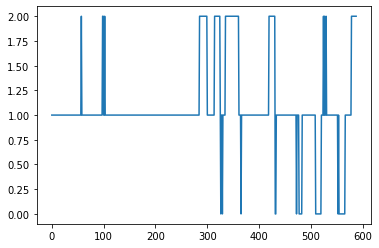

In [44]:
data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(data)

future_window = 12
future_diff_threshold = 0.012

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 1
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 0
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 1

df = df[['c', 'label']]

y = df['label'].values

plt.plot(y)

bot i want to build

1. websocket will eventually just keep streaming any number of pairs (for example, now it's just BTC_USDC, ETH_USDC, ETH_BTC, but should be able to just include any)
2. save the streamed data (into let's say CSVs, or maybe even GCP bucket?) but also the bot will be able to take in gaps in the training data (e.g. websocket is closed for 1 week for some reason)
3. should be able to create a bot for various pairs based on the data saved above
4. each bot can take in various parameters to decide indicators, window sizes, etc
5. maybe eventually try to automate (i.e. bot will loop through various parameters to find the one that can produce the best model and by extension strategy)


But anyway for the model building

1. Read in data
2. Initial preprocessing - all up until labelling
3. Train test split?
4. Pipeline
- feature engineering and scaling etc
 

In [131]:
def initial_preprocessing(df, future_window, future_diff_threshold, allow_overlap=False, random_state=None):
    """Takes in a df with columns [instrument, t, o, h, l, c, v] and returns it with labels based on future numbers.
    Label can be [0, 1, 2] where 1 means that within future_window time points in the future, the price went below (latest closing price * (1-future_diff_threshold)).
    2 means that within future_window time points in the future, the price went above (latest closing price * (1+future_diff_threshold))
    0 means neither of the above (latest closing price stayed within +- future_diff threshold)

    If there are gaps between data, such as (assuming 5 min candles) one row ending at 00:05am and the next one starting at 00:15am (and not 00:10am), future windows will not be calculated across the gap.
    That also means that chunks of data smaller than future_window will probably be discarded
    Gaps determined based on MIN of distance between rows. e.g. if the smallest interval is 5 mins, then 5 mins will be the stardard, anything else will be the gap 

    If allow_overlap is False, will drop rows that overlap each other.
    For instance, (assuming 5 min candles) a row that starts from 00:00am with 5 future windows (25 mins into the future) will overlap with a row that starts from 00:15am

    random_state will allow seeding of numpy random generator (is reset before the function returns)
    """

    # drop duplicates because the websocket just gets data every 30s, a lot of repeated data
    df = df.drop_duplicates()

    #  multiple instruments in there, so group by
    # also because of repeated data inflow, only want the last time for each instrument/time combi
    df = df.groupby(['instrument', 't']).last().reset_index()
    df['dt'] = pd.to_datetime(df['t'], unit='ms')

    # separate df into different instruments
    dfs = []
    for instrument in df['instrument'].unique():
        dfs.append(df.loc[df['instrument']==instrument].copy())

    # instrument level
    final_dfs = []
    for sub_df in dfs:

        sub_df = sub_df.sort_values('dt')
        sub_df['dt_diff'] = sub_df['dt'].diff()
        dt_diff_min = sub_df['dt_diff'].min()
        sub_df['dt_diff_check'] = sub_df['dt_diff'] == dt_diff_min
        sub_df = sub_df.reset_index()

        # get indexes where dt_diff_check is False
        # it's the start of a new sub_df (after the gap)
        new_sub_df_indexes = sub_df.loc[~sub_df['dt_diff_check']].index.tolist()
        sub_sub_dfs = []
        for i, index in enumerate(new_sub_df_indexes):
            # if there's only one value, then the whole thing is the sub sub df
            if len(new_sub_df_indexes) == 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_dfs.append(sub_sub_df.copy())
            # whereas if it's the last value, then it's that til the end
            elif i == len(new_sub_df_indexes) - 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_dfs.append(sub_sub_df.copy())
            # otherwise, stop before next value in list
            else:
                sub_sub_df = sub_df.iloc[index:new_sub_df_indexes[i+1]]
                sub_sub_dfs.append(sub_sub_df.copy())

        # for sub_sub_df in sub_sub_dfs:
        #     print(sub_sub_df.head())

        

        for sub_sub_df in sub_sub_dfs:
            
            # simply throw out sub_sub_dfs that cannot even get the future window
            if len(sub_sub_df) > future_window:

                sub_sub_df['future_max'] = sub_sub_df['h'].iloc[::-1].rolling(future_window+1).max().iloc[::-1]
                sub_sub_df['future_min'] = sub_sub_df['l'].iloc[::-1].rolling(future_window+1).min().iloc[::-1]
                sub_sub_df = sub_sub_df.loc[~sub_sub_df['future_max'].isna()].copy()
                sub_sub_df['min_flag'] = ((sub_sub_df['c'] - sub_sub_df['future_min']) / sub_sub_df['c']) > future_diff_threshold
                sub_sub_df['max_flag'] = ((sub_sub_df['future_max'] - sub_sub_df['c']) / sub_sub_df['c']) > future_diff_threshold
                sub_sub_df['label'] = 0
                sub_sub_df.loc[(sub_sub_df['min_flag']==True)&(sub_sub_df['max_flag']==False), 'label'] = 1
                sub_sub_df.loc[(sub_sub_df['min_flag']==False)&(sub_sub_df['max_flag']==True), 'label'] = 2
                sub_sub_df.loc[(sub_sub_df['min_flag']==True)&(sub_sub_df['max_flag']==True), 'label'] = 0
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label']]
                # only append if len sub sub df > future window
                final_dfs.append(sub_sub_df)

    df = pd.concat(final_dfs, axis=0)
    return df

def basic_feature_engineering(df, past_window, remove_overlap=True, random_state=None):
    """Takes in a initially preprocessed df (run through the initial_preprocessing function) and
    does basic feature engineering of adding past windows, as well as removing overlap
    """
    np.random.seed(random_state)
    random_choice = np.random.choice(past_window)
    print('random choice:', random_choice)

    # firstly, break out into instruments again

    sub_dfs = []
    for instrument in df['instrument'].unique():
        sub_dfs.append(df.loc[df['instrument']==instrument].copy())

    final_dfs = []

    for sub_df in sub_dfs:

        sub_df = sub_df.sort_values('dt')
        sub_df['dt_diff'] = sub_df['dt'].diff()
        dt_diff_min = sub_df['dt_diff'].min()
        sub_df['dt_diff_check'] = sub_df['dt_diff'] == dt_diff_min
        sub_df = sub_df.reset_index()

        # get indexes where dt_diff_check is False
        # it's the start of a new sub_df (after the gap)
        new_sub_df_indexes = sub_df.loc[~sub_df['dt_diff_check']].index.tolist()
        sub_sub_dfs = []
        for i, index in enumerate(new_sub_df_indexes):
            # if there's only one value, then the whole thing is the sub sub df
            if len(new_sub_df_indexes) == 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label']]
                sub_sub_dfs.append(sub_sub_df.copy())
            # whereas if it's the last value, then it's that til the end
            elif i == len(new_sub_df_indexes) - 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label']]
                sub_sub_dfs.append(sub_sub_df.copy())
            # otherwise, stop before next value in list
            else:
                sub_sub_df = sub_df.iloc[index:new_sub_df_indexes[i+1]]
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label']]
                sub_sub_dfs.append(sub_sub_df.copy())



        for sub_sub_df in sub_sub_dfs:
            if len(sub_sub_df) >= past_window:
                frames = [sub_sub_df]
                for i in range(1, past_window):
                    temp = pd.DataFrame()
                    temp[f'o_{i}'] = sub_sub_df['o'].shift(i).copy()
                    temp[f'h_{i}'] = sub_sub_df['h'].shift(i).copy()
                    temp[f'l_{i}'] = sub_sub_df['l'].shift(i).copy()
                    temp[f'c_{i}'] = sub_sub_df['c'].shift(i).copy()
                    temp[f'v_{i}'] = sub_sub_df['v'].shift(i).copy()
                    frames.append(temp)

                sub_sub_df = pd.concat(frames, axis=1)
                sub_sub_df = sub_sub_df.loc[~sub_sub_df[f'o_{past_window-1}'].isna()]
                sub_sub_df['temp_index'] = sub_sub_df.index + 1
                sub_sub_df['temp_index_2'] = sub_sub_df['temp_index'] % random_choice
                sub_sub_df = sub_sub_df.loc[sub_sub_df['temp_index_2']==0].copy()
                sub_sub_df = sub_sub_df.drop(columns=['temp_index', 'temp_index_2'])
                final_dfs.append(sub_sub_df)

    df = pd.concat(final_dfs, axis=0)
    np.random.seed()
    return df    

In [194]:
data_file_name = 'data3.csv'
instrument = 'ETH_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

data_filenames = [filename for filename in os.listdir() if filename.startswith('data') and filename.endswith('.csv')]

dfs = []

for filename in data_filenames:
    df = pd.read_csv(filename)
    dfs.append(df)

df = pd.concat(dfs)

df = initial_preprocessing(df, future_window=future_window, future_diff_threshold=future_diff_threshold, random_state=1)

df = basic_feature_engineering(df, past_window=24, random_state=1)

df


random choice: 5


,instrument,dt,o,h,l,c,v,label,o_1,h_1,...,o_22,h_22,l_22,c_22,v_22,o_23,h_23,l_23,c_23,v_23
24,BTC_USDC,2022-07-08 11:50:00,21630.63,21638.96,21594.25,21604.20,0.457086,1,21599.86,21635.35,...,21557.01,21587.16,21541.21,21563.42,2.690903,21493.98,21578.70,21485.45,21555.08,5.224304
29,BTC_USDC,2022-07-08 12:15:00,21630.71,21700.68,21630.71,21644.68,2.202582,1,21592.83,21674.63,...,21679.73,21720.29,21660.15,21676.94,4.292558,21602.81,21683.32,21591.01,21679.73,1.976149
34,BTC_USDC,2022-07-08 12:40:00,21444.22,21453.82,21322.92,21322.92,2.285154,0,21440.43,21506.68,...,21604.52,21604.57,21532.50,21565.23,0.500846,21630.60,21630.60,21569.79,21603.38,0.819615
39,BTC_USDC,2022-07-08 13:05:00,21401.38,21411.77,21339.96,21377.08,2.697587,0,21357.32,21403.66,...,21507.84,21530.32,21475.02,21517.15,1.579408,21484.92,21506.92,21454.68,21503.91,1.146705
44,BTC_USDC,2022-07-08 13:30:00,21363.08,21379.71,21255.83,21324.77,4.836931,0,21366.21,21376.07,...,21625.52,21627.70,21581.20,21598.85,0.914025,21653.29,21653.29,21595.69,21627.38,0.484637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9414,ETH_USDC,2022-08-11 14:50:00,1897.88,1908.75,1897.88,1906.60,10.195570,0,1892.99,1898.82,...,1928.85,1929.18,1919.81,1921.36,31.862900,1925.87,1929.45,1924.67,1928.22,59.430320
9419,ETH_USDC,2022-08-11 15:15:00,1894.72,1901.12,1888.86,1889.42,22.711110,0,1899.13,1902.18,...,1910.00,1916.44,1908.70,1914.53,12.171440,1909.68,1911.95,1908.65,1910.31,32.724640
9424,ETH_USDC,2022-08-11 15:40:00,1903.02,1903.02,1897.78,1898.24,9.743060,0,1906.82,1909.45,...,1910.67,1916.09,1910.11,1915.01,40.992480,1909.94,1915.85,1907.30,1910.65,28.200240
9429,ETH_USDC,2022-08-11 16:05:00,1894.00,1895.57,1887.73,1894.85,9.349050,0,1891.35,1896.26,...,1922.53,1926.87,1918.60,1919.17,26.012100,1920.98,1926.71,1917.33,1921.82,47.757550


Low sample size, let's do k fold cross validation

[0]	validation_0-mlogloss:1.09829
[1]	validation_0-mlogloss:1.09856
[2]	validation_0-mlogloss:1.09819
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09766
[5]	validation_0-mlogloss:1.09782
[6]	validation_0-mlogloss:1.09755
[7]	validation_0-mlogloss:1.09811
[8]	validation_0-mlogloss:1.09777
[9]	validation_0-mlogloss:1.09814


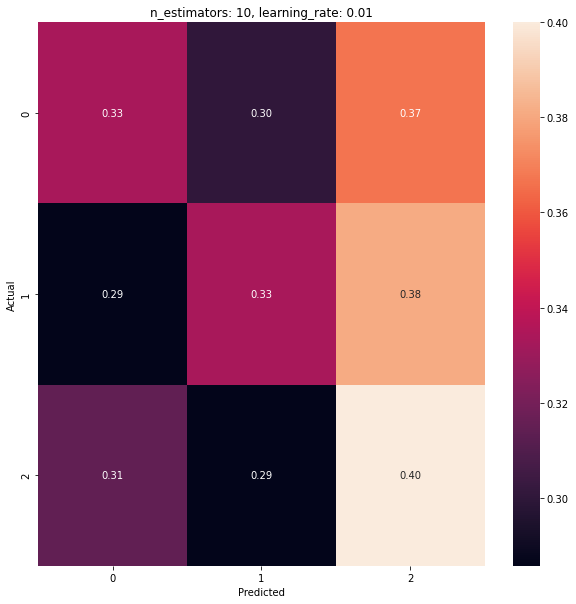

[0]	validation_0-mlogloss:1.09906
[1]	validation_0-mlogloss:1.09866
[2]	validation_0-mlogloss:1.09807
[3]	validation_0-mlogloss:1.09768
[4]	validation_0-mlogloss:1.09793
[5]	validation_0-mlogloss:1.09860
[6]	validation_0-mlogloss:1.09920
[7]	validation_0-mlogloss:1.09852
[8]	validation_0-mlogloss:1.09789
[9]	validation_0-mlogloss:1.09708


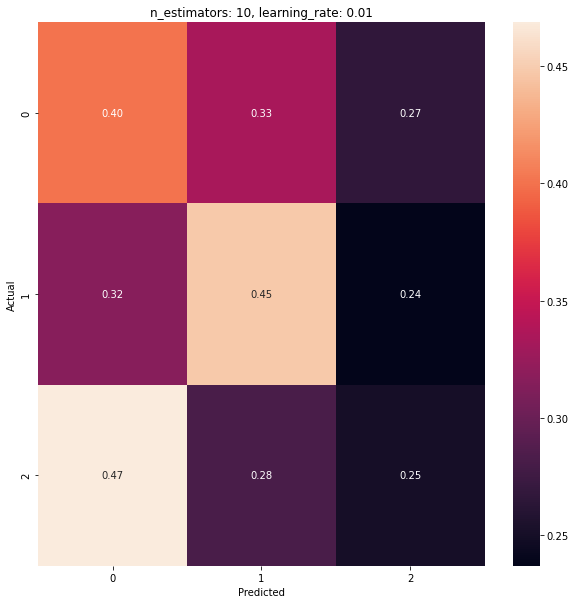

[0]	validation_0-mlogloss:1.09738
[1]	validation_0-mlogloss:1.09697
[2]	validation_0-mlogloss:1.09658
[3]	validation_0-mlogloss:1.09646
[4]	validation_0-mlogloss:1.09573
[5]	validation_0-mlogloss:1.09557
[6]	validation_0-mlogloss:1.09501
[7]	validation_0-mlogloss:1.09426
[8]	validation_0-mlogloss:1.09379
[9]	validation_0-mlogloss:1.09276


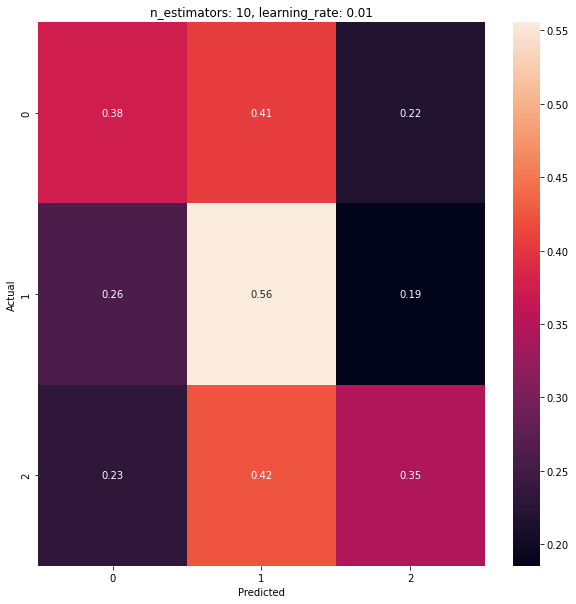

[0]	validation_0-mlogloss:1.09838
[1]	validation_0-mlogloss:1.09799
[2]	validation_0-mlogloss:1.09741
[3]	validation_0-mlogloss:1.09724
[4]	validation_0-mlogloss:1.09715
[5]	validation_0-mlogloss:1.09674
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09661
[8]	validation_0-mlogloss:1.09657
[9]	validation_0-mlogloss:1.09616


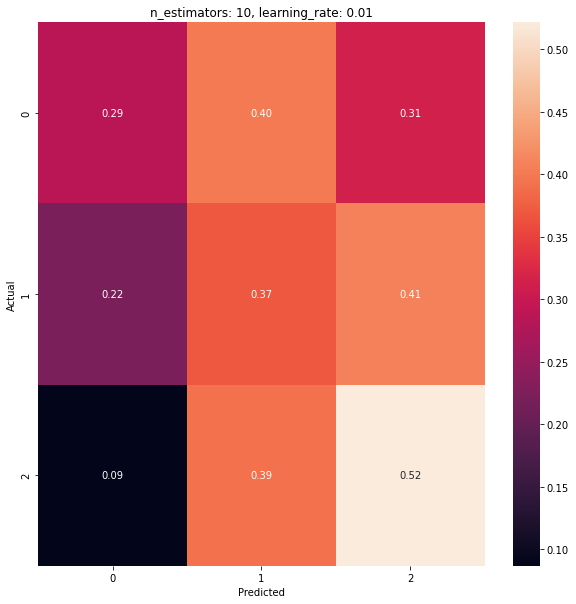

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09750
[2]	validation_0-mlogloss:1.09713
[3]	validation_0-mlogloss:1.09633
[4]	validation_0-mlogloss:1.09577
[5]	validation_0-mlogloss:1.09540
[6]	validation_0-mlogloss:1.09482
[7]	validation_0-mlogloss:1.09403
[8]	validation_0-mlogloss:1.09372
[9]	validation_0-mlogloss:1.09311


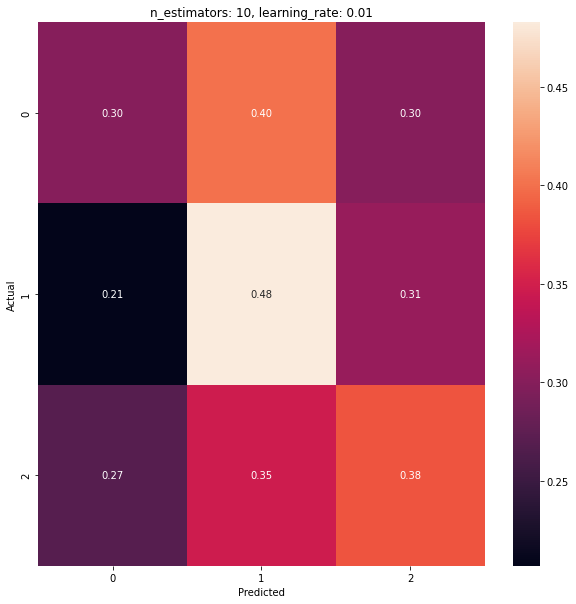

[0]	validation_0-mlogloss:1.09788
[1]	validation_0-mlogloss:1.09841
[2]	validation_0-mlogloss:1.09775
[3]	validation_0-mlogloss:1.09746
[4]	validation_0-mlogloss:1.09851
[5]	validation_0-mlogloss:1.09904
[6]	validation_0-mlogloss:1.10026
[7]	validation_0-mlogloss:1.10109
[8]	validation_0-mlogloss:1.10163
[9]	validation_0-mlogloss:1.10304


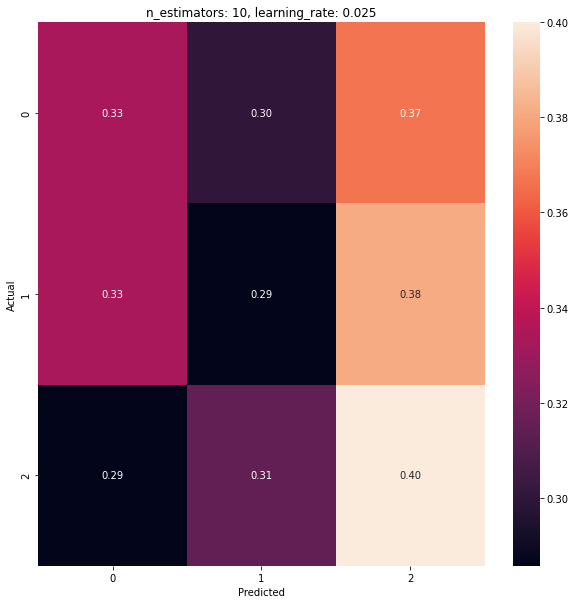

[0]	validation_0-mlogloss:1.09978
[1]	validation_0-mlogloss:1.09891
[2]	validation_0-mlogloss:1.09797
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09908
[5]	validation_0-mlogloss:1.09721
[6]	validation_0-mlogloss:1.09810
[7]	validation_0-mlogloss:1.09851
[8]	validation_0-mlogloss:1.10021
[9]	validation_0-mlogloss:1.10240


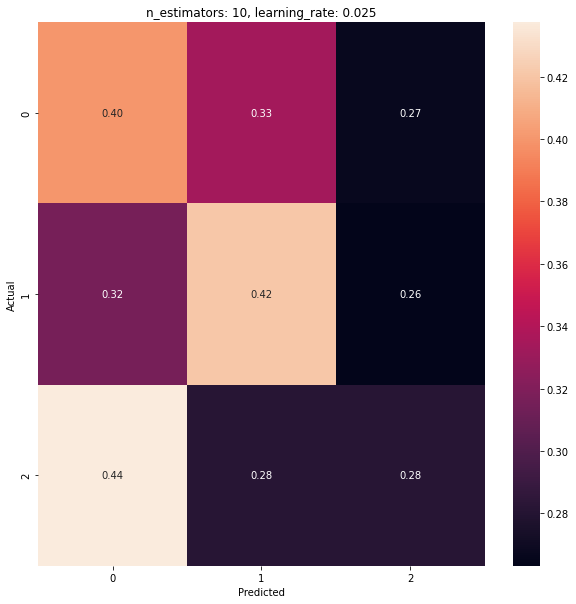

[0]	validation_0-mlogloss:1.09559
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09309
[3]	validation_0-mlogloss:1.09169
[4]	validation_0-mlogloss:1.08951
[5]	validation_0-mlogloss:1.08788
[6]	validation_0-mlogloss:1.08571
[7]	validation_0-mlogloss:1.08218
[8]	validation_0-mlogloss:1.08081
[9]	validation_0-mlogloss:1.07886


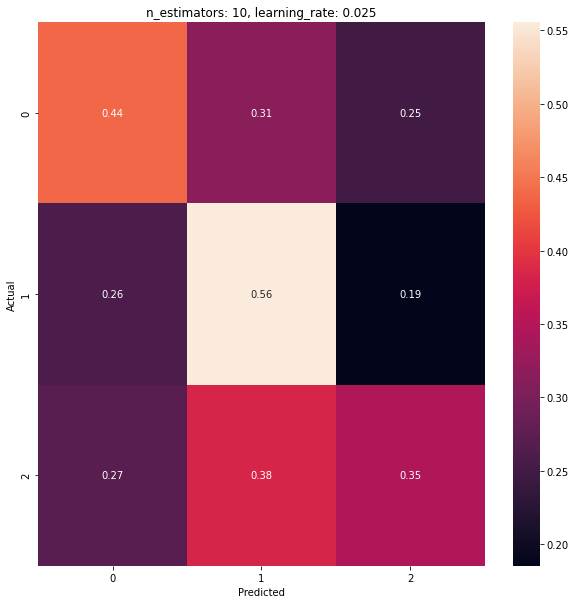

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09758
[2]	validation_0-mlogloss:1.09677
[3]	validation_0-mlogloss:1.09705
[4]	validation_0-mlogloss:1.09740
[5]	validation_0-mlogloss:1.09884
[6]	validation_0-mlogloss:1.09988
[7]	validation_0-mlogloss:1.10149
[8]	validation_0-mlogloss:1.10360
[9]	validation_0-mlogloss:1.10496


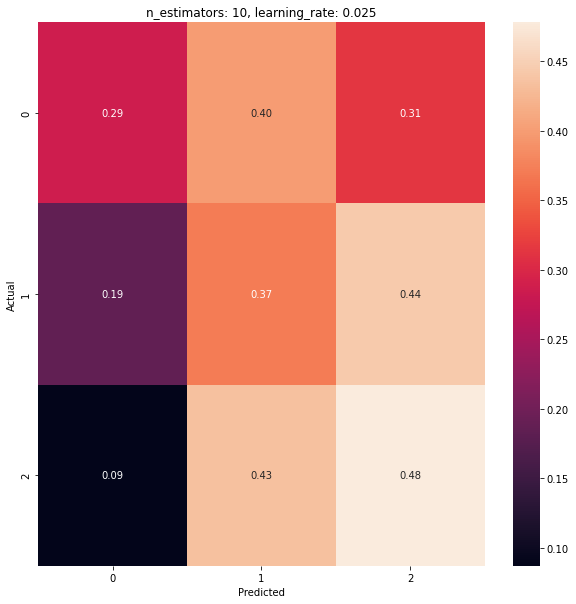

[0]	validation_0-mlogloss:1.09737
[1]	validation_0-mlogloss:1.09590
[2]	validation_0-mlogloss:1.09493
[3]	validation_0-mlogloss:1.09387
[4]	validation_0-mlogloss:1.09285
[5]	validation_0-mlogloss:1.09080
[6]	validation_0-mlogloss:1.08990
[7]	validation_0-mlogloss:1.09032
[8]	validation_0-mlogloss:1.09054
[9]	validation_0-mlogloss:1.09047


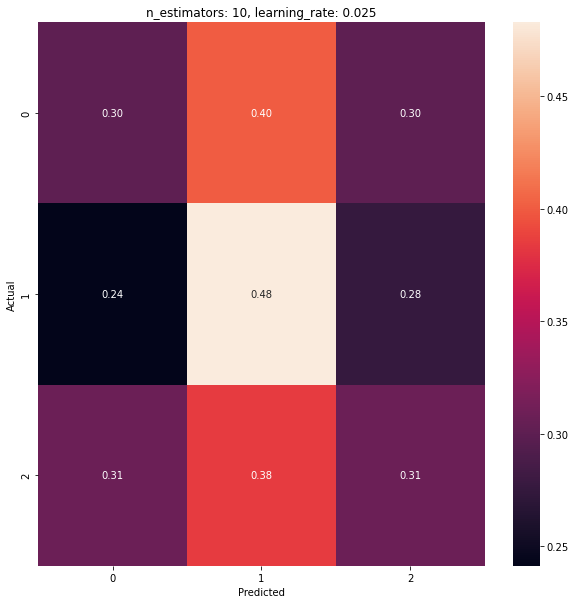

[0]	validation_0-mlogloss:1.09740
[1]	validation_0-mlogloss:1.09911
[2]	validation_0-mlogloss:1.10073
[3]	validation_0-mlogloss:1.10038
[4]	validation_0-mlogloss:1.10323
[5]	validation_0-mlogloss:1.10281
[6]	validation_0-mlogloss:1.10531
[7]	validation_0-mlogloss:1.10876
[8]	validation_0-mlogloss:1.11068
[9]	validation_0-mlogloss:1.11266


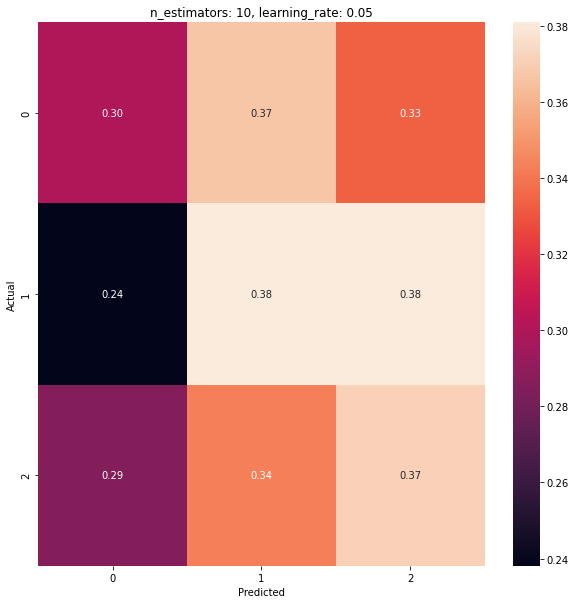

[0]	validation_0-mlogloss:1.10113
[1]	validation_0-mlogloss:1.10013
[2]	validation_0-mlogloss:1.10111
[3]	validation_0-mlogloss:1.09839
[4]	validation_0-mlogloss:1.10285
[5]	validation_0-mlogloss:1.10316
[6]	validation_0-mlogloss:1.10488
[7]	validation_0-mlogloss:1.10410
[8]	validation_0-mlogloss:1.10576
[9]	validation_0-mlogloss:1.10405


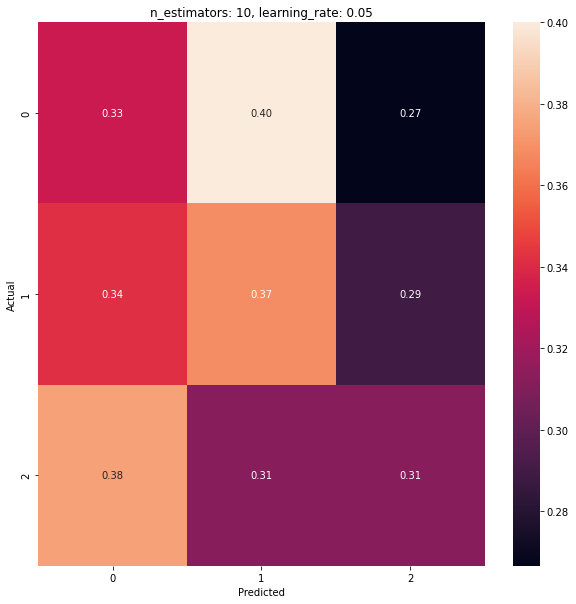

[0]	validation_0-mlogloss:1.09281
[1]	validation_0-mlogloss:1.08971
[2]	validation_0-mlogloss:1.08655
[3]	validation_0-mlogloss:1.08418
[4]	validation_0-mlogloss:1.07656
[5]	validation_0-mlogloss:1.07297
[6]	validation_0-mlogloss:1.06904
[7]	validation_0-mlogloss:1.06581
[8]	validation_0-mlogloss:1.06612
[9]	validation_0-mlogloss:1.06327


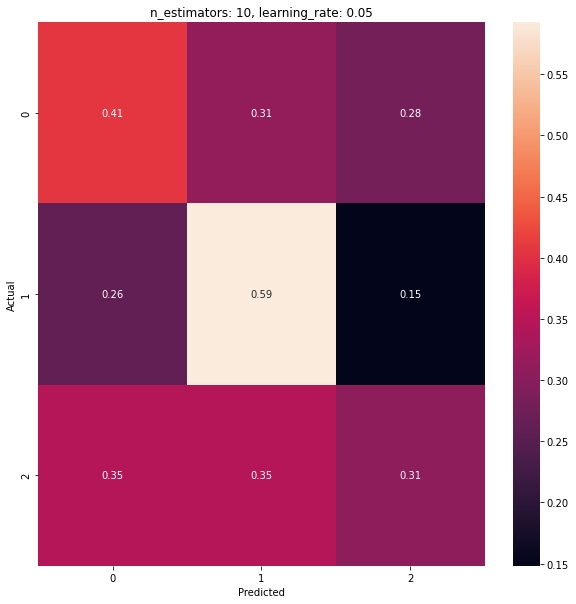

[0]	validation_0-mlogloss:1.09781
[1]	validation_0-mlogloss:1.09764
[2]	validation_0-mlogloss:1.10021
[3]	validation_0-mlogloss:1.10267
[4]	validation_0-mlogloss:1.10874
[5]	validation_0-mlogloss:1.11259
[6]	validation_0-mlogloss:1.11425
[7]	validation_0-mlogloss:1.11787
[8]	validation_0-mlogloss:1.12066
[9]	validation_0-mlogloss:1.12619


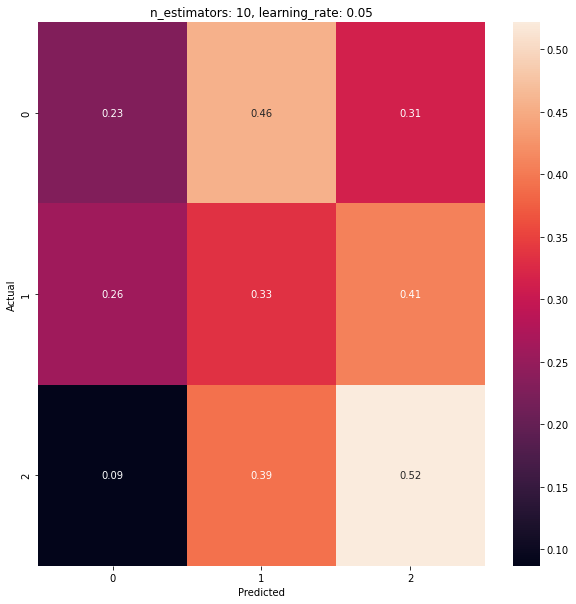

[0]	validation_0-mlogloss:1.09634
[1]	validation_0-mlogloss:1.09444
[2]	validation_0-mlogloss:1.09290
[3]	validation_0-mlogloss:1.09276
[4]	validation_0-mlogloss:1.09197
[5]	validation_0-mlogloss:1.09180
[6]	validation_0-mlogloss:1.09114
[7]	validation_0-mlogloss:1.09111
[8]	validation_0-mlogloss:1.09128
[9]	validation_0-mlogloss:1.09588


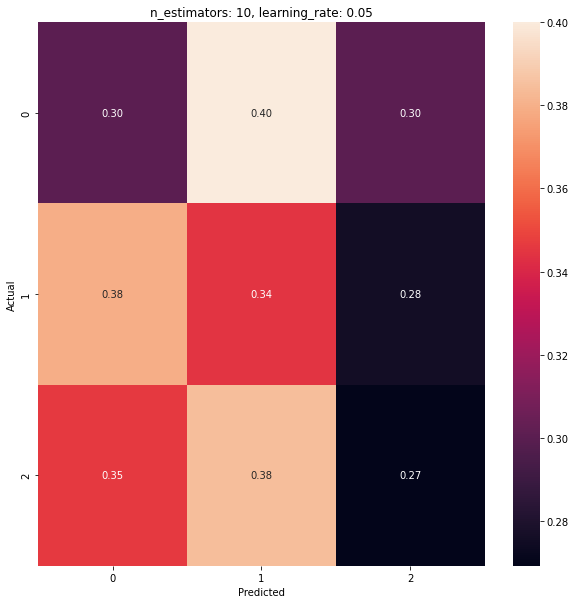

[0]	validation_0-mlogloss:1.09724
[1]	validation_0-mlogloss:1.10274
[2]	validation_0-mlogloss:1.10457
[3]	validation_0-mlogloss:1.11642
[4]	validation_0-mlogloss:1.12113
[5]	validation_0-mlogloss:1.12194
[6]	validation_0-mlogloss:1.12291
[7]	validation_0-mlogloss:1.12334
[8]	validation_0-mlogloss:1.12568
[9]	validation_0-mlogloss:1.13071


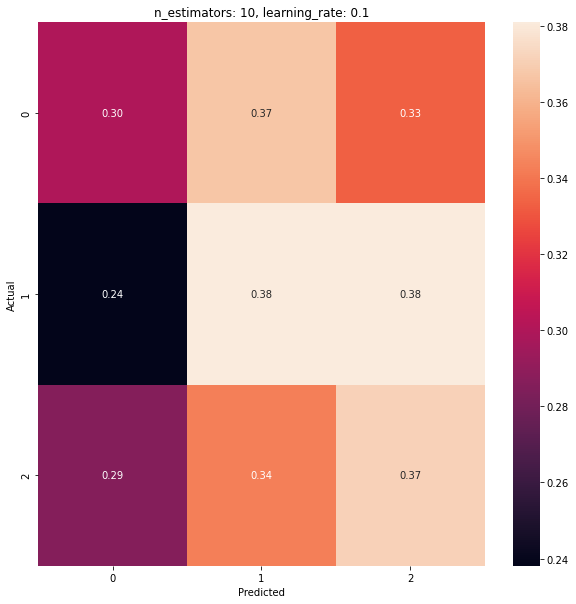

[0]	validation_0-mlogloss:1.10437
[1]	validation_0-mlogloss:1.09846
[2]	validation_0-mlogloss:1.09525
[3]	validation_0-mlogloss:1.10131
[4]	validation_0-mlogloss:1.10533
[5]	validation_0-mlogloss:1.10307
[6]	validation_0-mlogloss:1.10573
[7]	validation_0-mlogloss:1.11502
[8]	validation_0-mlogloss:1.10833
[9]	validation_0-mlogloss:1.11055


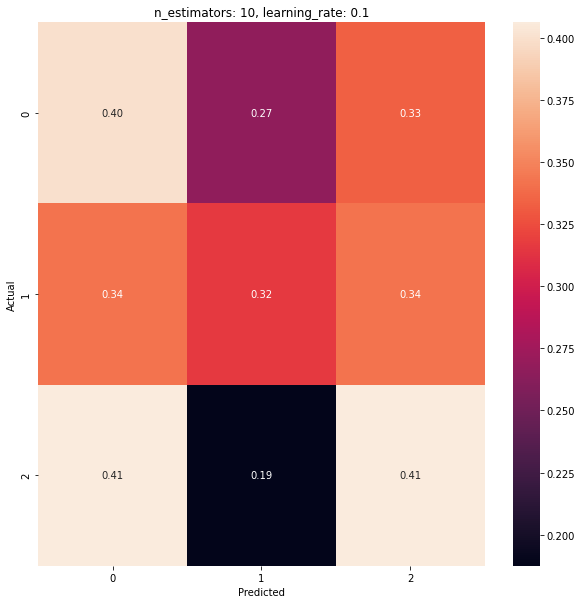

[0]	validation_0-mlogloss:1.08795
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07301
[3]	validation_0-mlogloss:1.06549
[4]	validation_0-mlogloss:1.06049
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05704
[7]	validation_0-mlogloss:1.05613
[8]	validation_0-mlogloss:1.05914
[9]	validation_0-mlogloss:1.05990


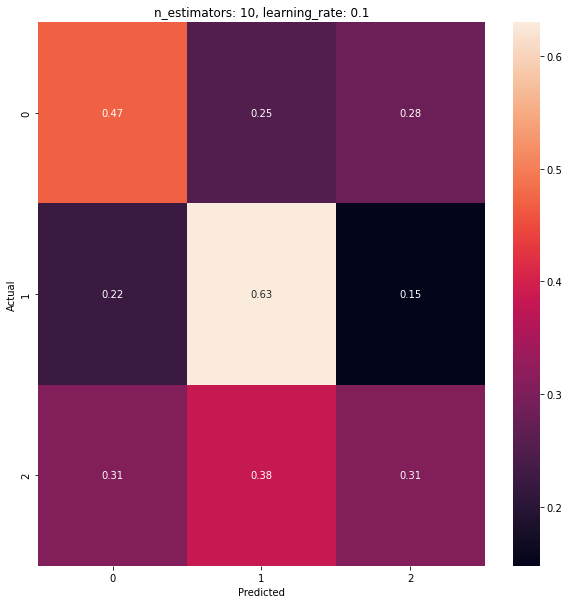

[0]	validation_0-mlogloss:1.09798
[1]	validation_0-mlogloss:1.10043
[2]	validation_0-mlogloss:1.11191
[3]	validation_0-mlogloss:1.11688
[4]	validation_0-mlogloss:1.12780
[5]	validation_0-mlogloss:1.13067
[6]	validation_0-mlogloss:1.13585
[7]	validation_0-mlogloss:1.13626
[8]	validation_0-mlogloss:1.13844
[9]	validation_0-mlogloss:1.14301


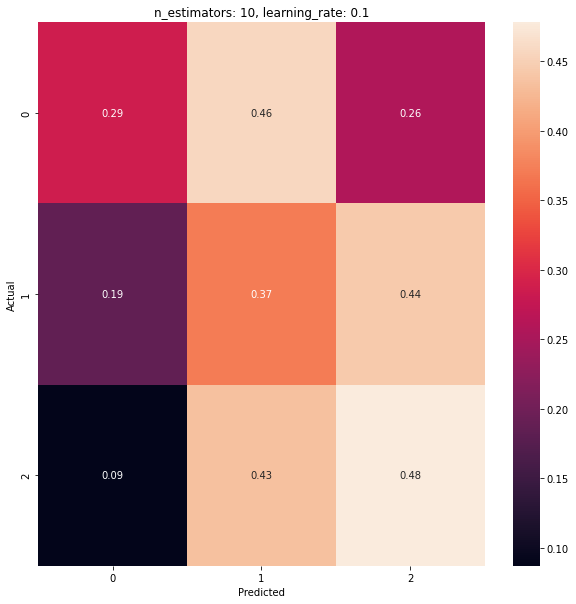

[0]	validation_0-mlogloss:1.09489
[1]	validation_0-mlogloss:1.09319
[2]	validation_0-mlogloss:1.09175
[3]	validation_0-mlogloss:1.09473
[4]	validation_0-mlogloss:1.09655
[5]	validation_0-mlogloss:1.09891
[6]	validation_0-mlogloss:1.09313
[7]	validation_0-mlogloss:1.09663
[8]	validation_0-mlogloss:1.09612
[9]	validation_0-mlogloss:1.09428


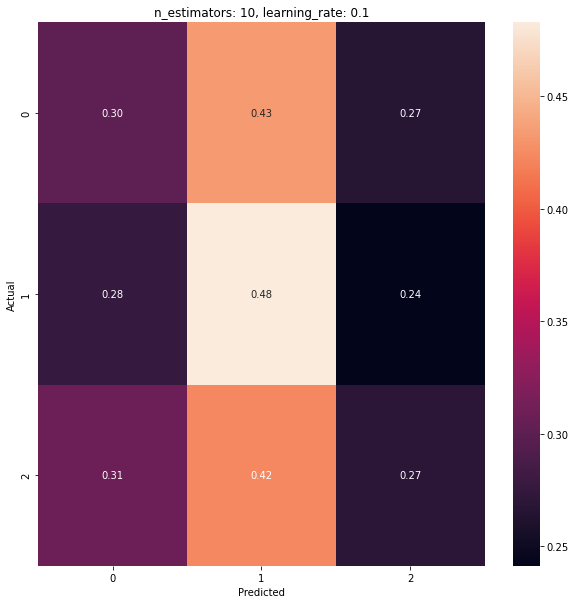

[0]	validation_0-mlogloss:1.09829
[1]	validation_0-mlogloss:1.09856
[2]	validation_0-mlogloss:1.09819
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09766
[5]	validation_0-mlogloss:1.09782
[6]	validation_0-mlogloss:1.09755
[7]	validation_0-mlogloss:1.09811
[8]	validation_0-mlogloss:1.09777
[9]	validation_0-mlogloss:1.09814
[10]	validation_0-mlogloss:1.09834
[11]	validation_0-mlogloss:1.09867
[12]	validation_0-mlogloss:1.09918
[13]	validation_0-mlogloss:1.09916
[14]	validation_0-mlogloss:1.09976
[15]	validation_0-mlogloss:1.10051


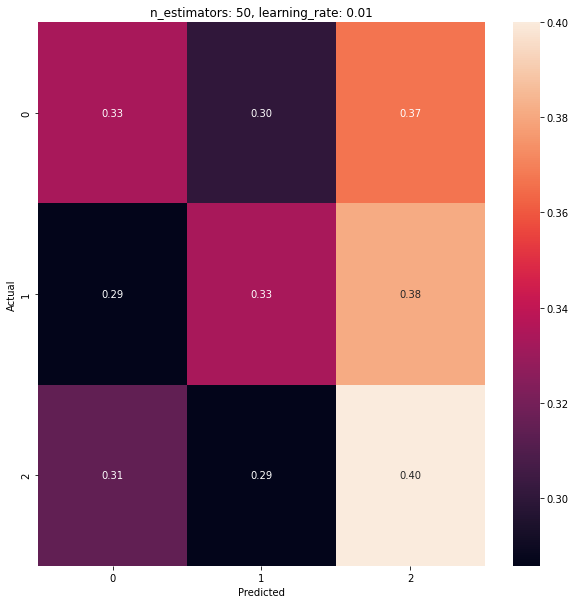

[0]	validation_0-mlogloss:1.09906
[1]	validation_0-mlogloss:1.09866
[2]	validation_0-mlogloss:1.09807
[3]	validation_0-mlogloss:1.09768
[4]	validation_0-mlogloss:1.09793
[5]	validation_0-mlogloss:1.09860
[6]	validation_0-mlogloss:1.09920
[7]	validation_0-mlogloss:1.09852
[8]	validation_0-mlogloss:1.09789
[9]	validation_0-mlogloss:1.09708
[10]	validation_0-mlogloss:1.09676
[11]	validation_0-mlogloss:1.09629
[12]	validation_0-mlogloss:1.09645
[13]	validation_0-mlogloss:1.09589
[14]	validation_0-mlogloss:1.09528
[15]	validation_0-mlogloss:1.09565
[16]	validation_0-mlogloss:1.09559
[17]	validation_0-mlogloss:1.09679
[18]	validation_0-mlogloss:1.09716
[19]	validation_0-mlogloss:1.09731
[20]	validation_0-mlogloss:1.09845
[21]	validation_0-mlogloss:1.09873
[22]	validation_0-mlogloss:1.09999
[23]	validation_0-mlogloss:1.10030


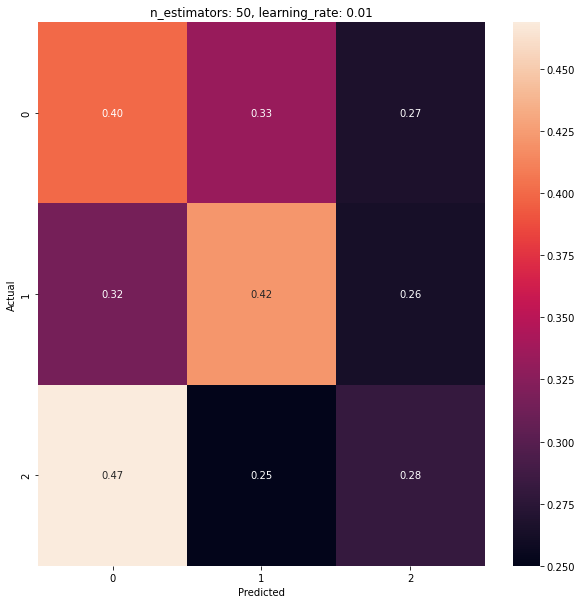

[0]	validation_0-mlogloss:1.09738
[1]	validation_0-mlogloss:1.09697
[2]	validation_0-mlogloss:1.09658
[3]	validation_0-mlogloss:1.09646
[4]	validation_0-mlogloss:1.09573
[5]	validation_0-mlogloss:1.09557
[6]	validation_0-mlogloss:1.09501
[7]	validation_0-mlogloss:1.09426
[8]	validation_0-mlogloss:1.09379
[9]	validation_0-mlogloss:1.09276
[10]	validation_0-mlogloss:1.09217
[11]	validation_0-mlogloss:1.09171
[12]	validation_0-mlogloss:1.09038
[13]	validation_0-mlogloss:1.08957
[14]	validation_0-mlogloss:1.08843
[15]	validation_0-mlogloss:1.08716
[16]	validation_0-mlogloss:1.08662
[17]	validation_0-mlogloss:1.08531
[18]	validation_0-mlogloss:1.08383
[19]	validation_0-mlogloss:1.08246
[20]	validation_0-mlogloss:1.08189
[21]	validation_0-mlogloss:1.08101
[22]	validation_0-mlogloss:1.08013
[23]	validation_0-mlogloss:1.07917
[24]	validation_0-mlogloss:1.07787
[25]	validation_0-mlogloss:1.07712
[26]	validation_0-mlogloss:1.07613
[27]	validation_0-mlogloss:1.07541
[28]	validation_0-mlogloss:1.0

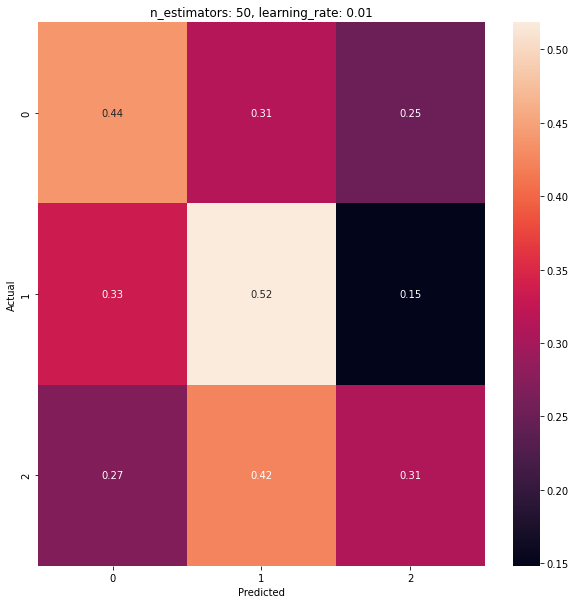

[0]	validation_0-mlogloss:1.09838
[1]	validation_0-mlogloss:1.09799
[2]	validation_0-mlogloss:1.09741
[3]	validation_0-mlogloss:1.09724
[4]	validation_0-mlogloss:1.09715
[5]	validation_0-mlogloss:1.09674
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09661
[8]	validation_0-mlogloss:1.09657
[9]	validation_0-mlogloss:1.09616
[10]	validation_0-mlogloss:1.09672
[11]	validation_0-mlogloss:1.09691
[12]	validation_0-mlogloss:1.09731
[13]	validation_0-mlogloss:1.09763
[14]	validation_0-mlogloss:1.09807
[15]	validation_0-mlogloss:1.09852
[16]	validation_0-mlogloss:1.09884
[17]	validation_0-mlogloss:1.09944
[18]	validation_0-mlogloss:1.09995
[19]	validation_0-mlogloss:1.10070


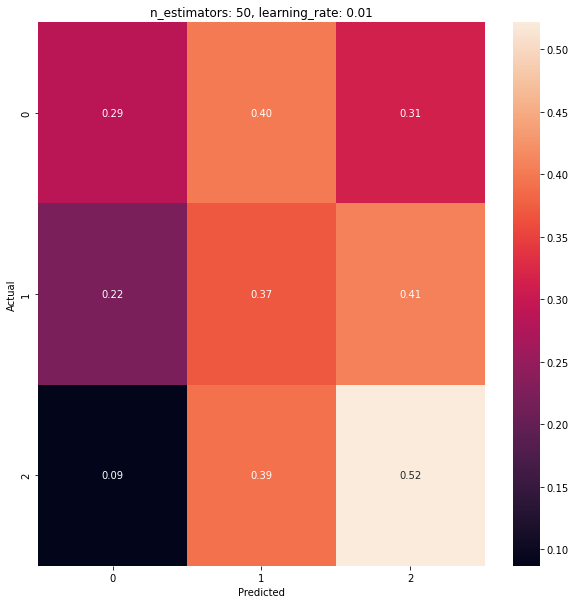

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09750
[2]	validation_0-mlogloss:1.09713
[3]	validation_0-mlogloss:1.09633
[4]	validation_0-mlogloss:1.09577
[5]	validation_0-mlogloss:1.09540
[6]	validation_0-mlogloss:1.09482
[7]	validation_0-mlogloss:1.09403
[8]	validation_0-mlogloss:1.09372
[9]	validation_0-mlogloss:1.09311
[10]	validation_0-mlogloss:1.09256
[11]	validation_0-mlogloss:1.09253
[12]	validation_0-mlogloss:1.09201
[13]	validation_0-mlogloss:1.09127
[14]	validation_0-mlogloss:1.09112
[15]	validation_0-mlogloss:1.09113
[16]	validation_0-mlogloss:1.09078
[17]	validation_0-mlogloss:1.09044
[18]	validation_0-mlogloss:1.09038
[19]	validation_0-mlogloss:1.09063
[20]	validation_0-mlogloss:1.09073
[21]	validation_0-mlogloss:1.09074
[22]	validation_0-mlogloss:1.09034
[23]	validation_0-mlogloss:1.09036
[24]	validation_0-mlogloss:1.09032
[25]	validation_0-mlogloss:1.09038
[26]	validation_0-mlogloss:1.09016
[27]	validation_0-mlogloss:1.09044
[28]	validation_0-mlogloss:1.0

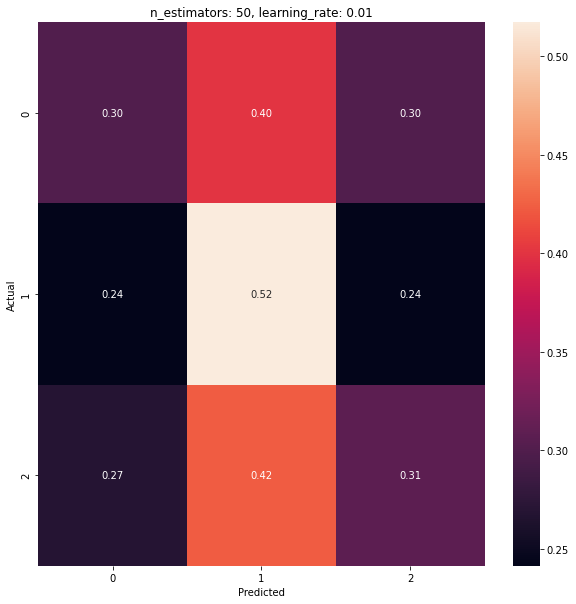

[0]	validation_0-mlogloss:1.09788
[1]	validation_0-mlogloss:1.09841
[2]	validation_0-mlogloss:1.09775
[3]	validation_0-mlogloss:1.09746
[4]	validation_0-mlogloss:1.09851
[5]	validation_0-mlogloss:1.09904
[6]	validation_0-mlogloss:1.10026
[7]	validation_0-mlogloss:1.10109
[8]	validation_0-mlogloss:1.10163
[9]	validation_0-mlogloss:1.10304
[10]	validation_0-mlogloss:1.10478
[11]	validation_0-mlogloss:1.10502
[12]	validation_0-mlogloss:1.10639
[13]	validation_0-mlogloss:1.10949


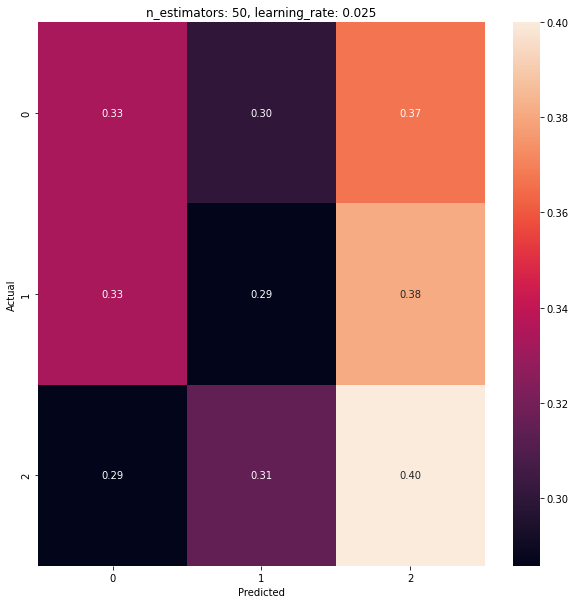

[0]	validation_0-mlogloss:1.09978
[1]	validation_0-mlogloss:1.09891
[2]	validation_0-mlogloss:1.09797
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09908
[5]	validation_0-mlogloss:1.09721
[6]	validation_0-mlogloss:1.09810
[7]	validation_0-mlogloss:1.09851
[8]	validation_0-mlogloss:1.10021
[9]	validation_0-mlogloss:1.10240
[10]	validation_0-mlogloss:1.10294
[11]	validation_0-mlogloss:1.10349
[12]	validation_0-mlogloss:1.10464
[13]	validation_0-mlogloss:1.10368
[14]	validation_0-mlogloss:1.10499


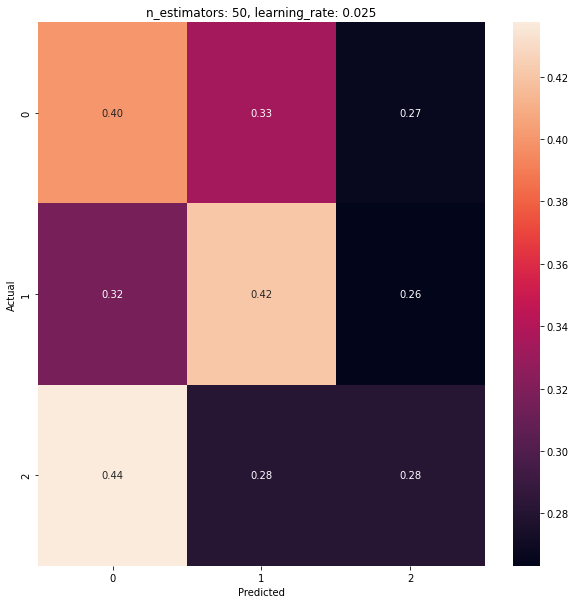

[0]	validation_0-mlogloss:1.09559
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09309
[3]	validation_0-mlogloss:1.09169
[4]	validation_0-mlogloss:1.08951
[5]	validation_0-mlogloss:1.08788
[6]	validation_0-mlogloss:1.08571
[7]	validation_0-mlogloss:1.08218
[8]	validation_0-mlogloss:1.08081
[9]	validation_0-mlogloss:1.07886
[10]	validation_0-mlogloss:1.07640
[11]	validation_0-mlogloss:1.07452
[12]	validation_0-mlogloss:1.07227
[13]	validation_0-mlogloss:1.07052
[14]	validation_0-mlogloss:1.07071
[15]	validation_0-mlogloss:1.06843
[16]	validation_0-mlogloss:1.06816
[17]	validation_0-mlogloss:1.06827
[18]	validation_0-mlogloss:1.06673
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06530
[21]	validation_0-mlogloss:1.06441
[22]	validation_0-mlogloss:1.06342
[23]	validation_0-mlogloss:1.06280
[24]	validation_0-mlogloss:1.06187
[25]	validation_0-mlogloss:1.06193
[26]	validation_0-mlogloss:1.06137
[27]	validation_0-mlogloss:1.06103
[28]	validation_0-mlogloss:1.0

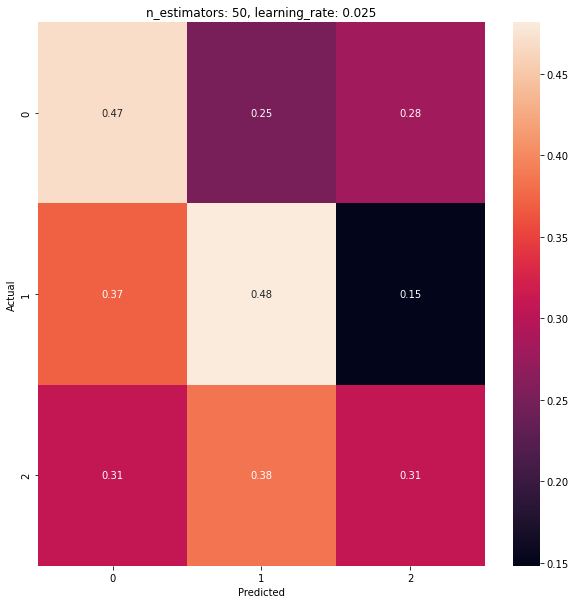

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09758
[2]	validation_0-mlogloss:1.09677
[3]	validation_0-mlogloss:1.09705
[4]	validation_0-mlogloss:1.09740
[5]	validation_0-mlogloss:1.09884
[6]	validation_0-mlogloss:1.09988
[7]	validation_0-mlogloss:1.10149
[8]	validation_0-mlogloss:1.10360
[9]	validation_0-mlogloss:1.10496
[10]	validation_0-mlogloss:1.10622
[11]	validation_0-mlogloss:1.10638


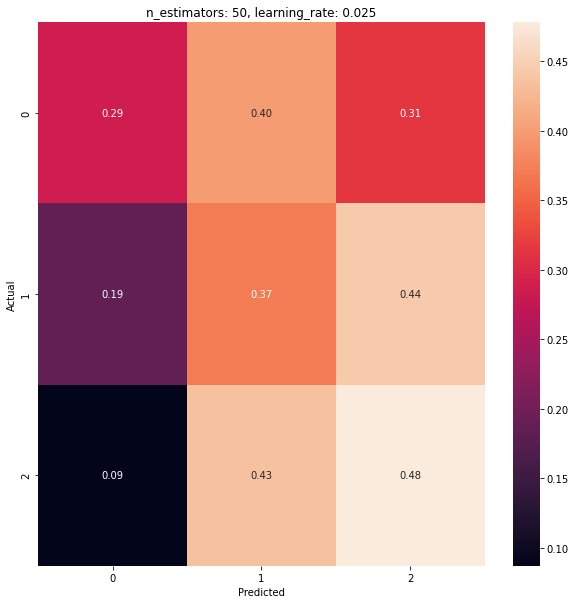

[0]	validation_0-mlogloss:1.09737
[1]	validation_0-mlogloss:1.09590
[2]	validation_0-mlogloss:1.09493
[3]	validation_0-mlogloss:1.09387
[4]	validation_0-mlogloss:1.09285
[5]	validation_0-mlogloss:1.09080
[6]	validation_0-mlogloss:1.08990
[7]	validation_0-mlogloss:1.09032
[8]	validation_0-mlogloss:1.09054
[9]	validation_0-mlogloss:1.09047
[10]	validation_0-mlogloss:1.08970
[11]	validation_0-mlogloss:1.08949
[12]	validation_0-mlogloss:1.08948
[13]	validation_0-mlogloss:1.08969
[14]	validation_0-mlogloss:1.09041
[15]	validation_0-mlogloss:1.09137
[16]	validation_0-mlogloss:1.09135
[17]	validation_0-mlogloss:1.09186
[18]	validation_0-mlogloss:1.09140
[19]	validation_0-mlogloss:1.09212
[20]	validation_0-mlogloss:1.09288
[21]	validation_0-mlogloss:1.09258
[22]	validation_0-mlogloss:1.09306


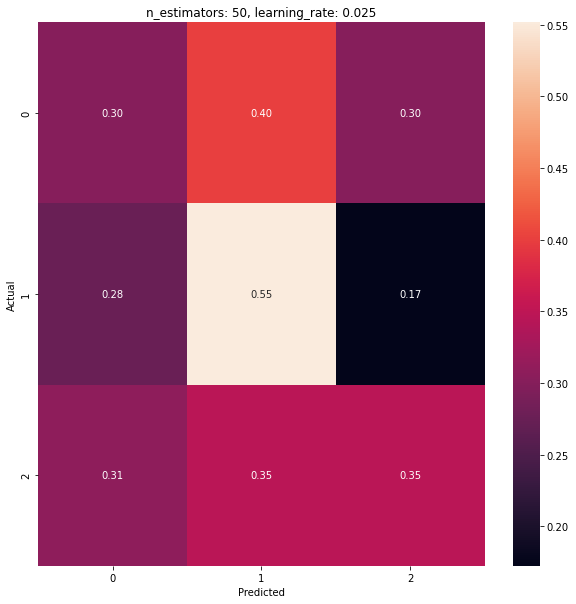

[0]	validation_0-mlogloss:1.09740
[1]	validation_0-mlogloss:1.09911
[2]	validation_0-mlogloss:1.10073
[3]	validation_0-mlogloss:1.10038
[4]	validation_0-mlogloss:1.10323
[5]	validation_0-mlogloss:1.10281
[6]	validation_0-mlogloss:1.10531
[7]	validation_0-mlogloss:1.10876
[8]	validation_0-mlogloss:1.11068
[9]	validation_0-mlogloss:1.11266
[10]	validation_0-mlogloss:1.11642


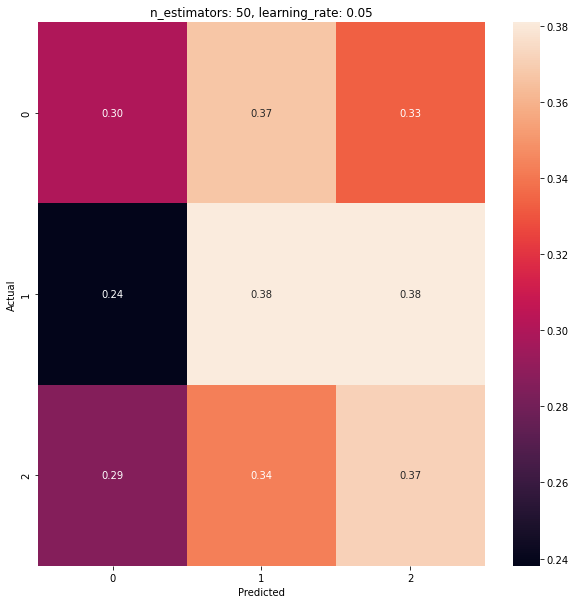

[0]	validation_0-mlogloss:1.10113
[1]	validation_0-mlogloss:1.10013
[2]	validation_0-mlogloss:1.10111
[3]	validation_0-mlogloss:1.09839
[4]	validation_0-mlogloss:1.10285
[5]	validation_0-mlogloss:1.10316
[6]	validation_0-mlogloss:1.10488
[7]	validation_0-mlogloss:1.10410
[8]	validation_0-mlogloss:1.10576
[9]	validation_0-mlogloss:1.10405
[10]	validation_0-mlogloss:1.10492
[11]	validation_0-mlogloss:1.10447
[12]	validation_0-mlogloss:1.10698
[13]	validation_0-mlogloss:1.10368


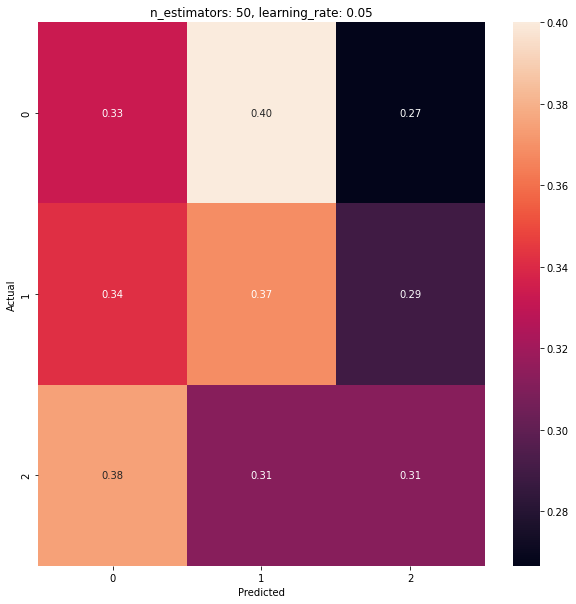

[0]	validation_0-mlogloss:1.09281
[1]	validation_0-mlogloss:1.08971
[2]	validation_0-mlogloss:1.08655
[3]	validation_0-mlogloss:1.08418
[4]	validation_0-mlogloss:1.07656
[5]	validation_0-mlogloss:1.07297
[6]	validation_0-mlogloss:1.06904
[7]	validation_0-mlogloss:1.06581
[8]	validation_0-mlogloss:1.06612
[9]	validation_0-mlogloss:1.06327
[10]	validation_0-mlogloss:1.06027
[11]	validation_0-mlogloss:1.06034
[12]	validation_0-mlogloss:1.06064
[13]	validation_0-mlogloss:1.05975
[14]	validation_0-mlogloss:1.06121
[15]	validation_0-mlogloss:1.06287
[16]	validation_0-mlogloss:1.06382
[17]	validation_0-mlogloss:1.06441
[18]	validation_0-mlogloss:1.06873
[19]	validation_0-mlogloss:1.07052
[20]	validation_0-mlogloss:1.07333
[21]	validation_0-mlogloss:1.07565
[22]	validation_0-mlogloss:1.07767


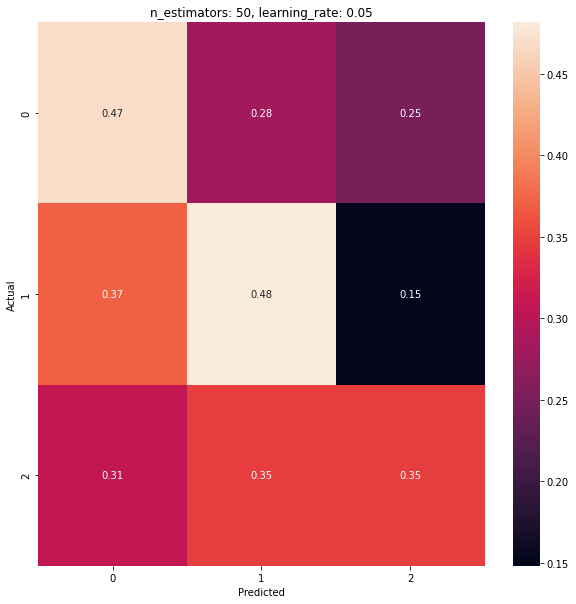

[0]	validation_0-mlogloss:1.09781
[1]	validation_0-mlogloss:1.09764
[2]	validation_0-mlogloss:1.10021
[3]	validation_0-mlogloss:1.10267
[4]	validation_0-mlogloss:1.10874
[5]	validation_0-mlogloss:1.11259
[6]	validation_0-mlogloss:1.11425
[7]	validation_0-mlogloss:1.11787
[8]	validation_0-mlogloss:1.12066
[9]	validation_0-mlogloss:1.12619
[10]	validation_0-mlogloss:1.12930
[11]	validation_0-mlogloss:1.13503


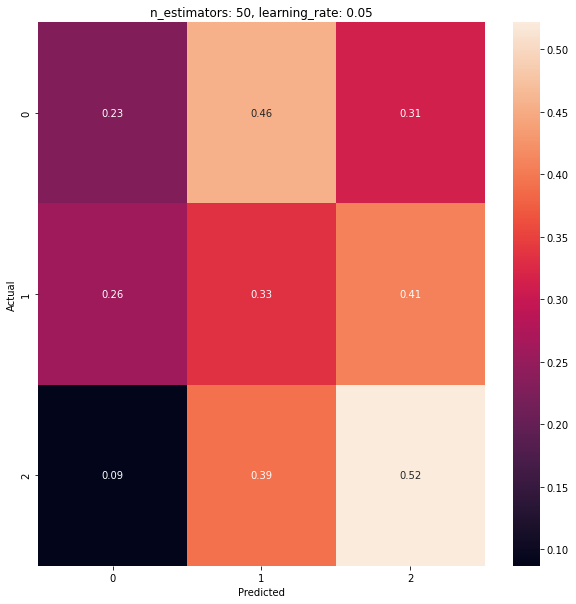

[0]	validation_0-mlogloss:1.09634
[1]	validation_0-mlogloss:1.09444
[2]	validation_0-mlogloss:1.09290
[3]	validation_0-mlogloss:1.09276
[4]	validation_0-mlogloss:1.09197
[5]	validation_0-mlogloss:1.09180
[6]	validation_0-mlogloss:1.09114
[7]	validation_0-mlogloss:1.09111
[8]	validation_0-mlogloss:1.09128
[9]	validation_0-mlogloss:1.09588
[10]	validation_0-mlogloss:1.09280
[11]	validation_0-mlogloss:1.09302
[12]	validation_0-mlogloss:1.08974
[13]	validation_0-mlogloss:1.08843
[14]	validation_0-mlogloss:1.08827
[15]	validation_0-mlogloss:1.08868
[16]	validation_0-mlogloss:1.08605
[17]	validation_0-mlogloss:1.08521
[18]	validation_0-mlogloss:1.08698
[19]	validation_0-mlogloss:1.08856
[20]	validation_0-mlogloss:1.08944
[21]	validation_0-mlogloss:1.09035
[22]	validation_0-mlogloss:1.09231
[23]	validation_0-mlogloss:1.09253
[24]	validation_0-mlogloss:1.09323
[25]	validation_0-mlogloss:1.09434
[26]	validation_0-mlogloss:1.09501
[27]	validation_0-mlogloss:1.09431


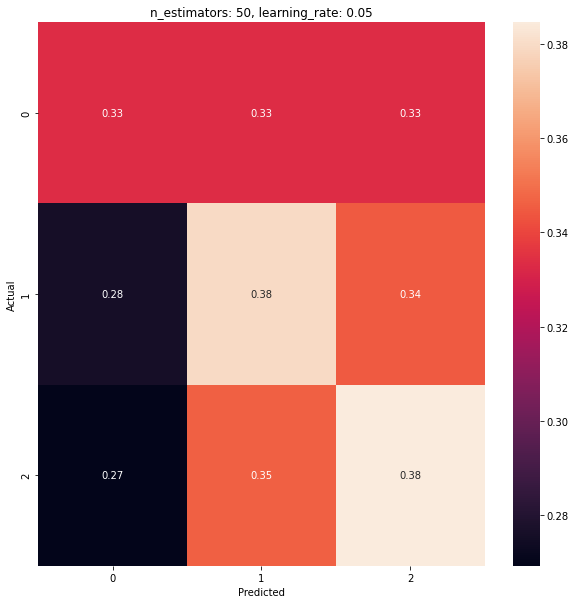

[0]	validation_0-mlogloss:1.09724
[1]	validation_0-mlogloss:1.10274
[2]	validation_0-mlogloss:1.10457
[3]	validation_0-mlogloss:1.11642
[4]	validation_0-mlogloss:1.12113
[5]	validation_0-mlogloss:1.12194
[6]	validation_0-mlogloss:1.12291
[7]	validation_0-mlogloss:1.12334
[8]	validation_0-mlogloss:1.12568
[9]	validation_0-mlogloss:1.13071


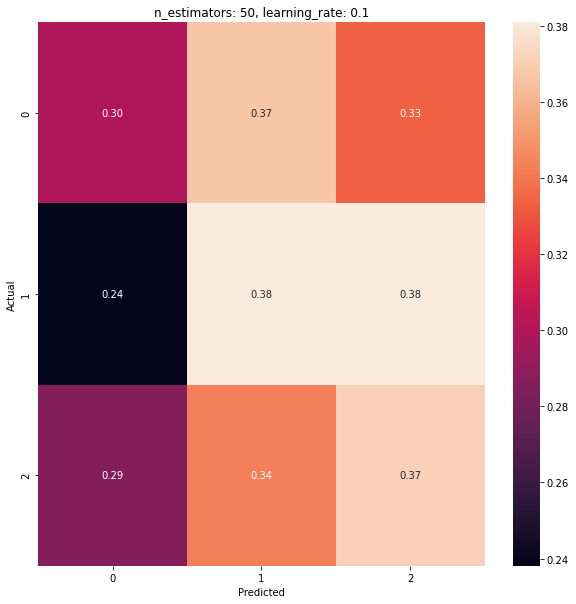

[0]	validation_0-mlogloss:1.10437
[1]	validation_0-mlogloss:1.09846
[2]	validation_0-mlogloss:1.09525
[3]	validation_0-mlogloss:1.10131
[4]	validation_0-mlogloss:1.10533
[5]	validation_0-mlogloss:1.10307
[6]	validation_0-mlogloss:1.10573
[7]	validation_0-mlogloss:1.11502
[8]	validation_0-mlogloss:1.10833
[9]	validation_0-mlogloss:1.11055
[10]	validation_0-mlogloss:1.11112
[11]	validation_0-mlogloss:1.11318


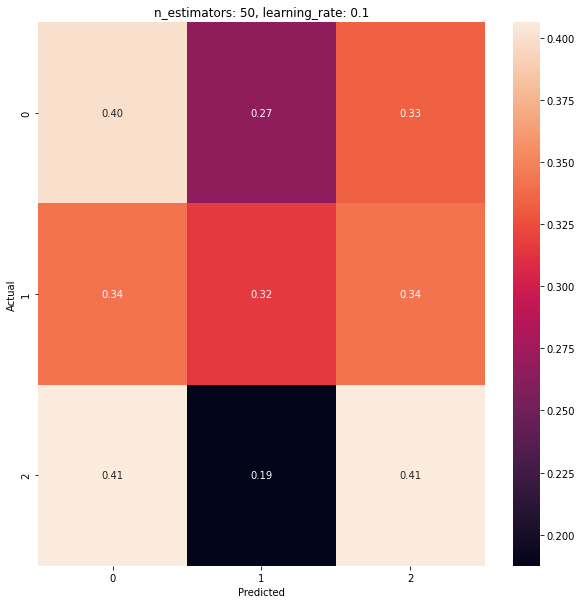

[0]	validation_0-mlogloss:1.08795
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07301
[3]	validation_0-mlogloss:1.06549
[4]	validation_0-mlogloss:1.06049
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05704
[7]	validation_0-mlogloss:1.05613
[8]	validation_0-mlogloss:1.05914
[9]	validation_0-mlogloss:1.05990
[10]	validation_0-mlogloss:1.06619
[11]	validation_0-mlogloss:1.07081
[12]	validation_0-mlogloss:1.07317
[13]	validation_0-mlogloss:1.07471
[14]	validation_0-mlogloss:1.07885
[15]	validation_0-mlogloss:1.07562
[16]	validation_0-mlogloss:1.07781
[17]	validation_0-mlogloss:1.07637


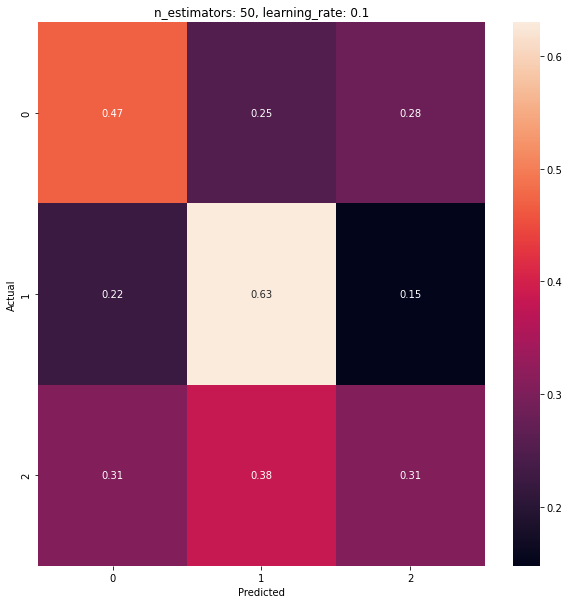

[0]	validation_0-mlogloss:1.09798
[1]	validation_0-mlogloss:1.10043
[2]	validation_0-mlogloss:1.11191
[3]	validation_0-mlogloss:1.11688
[4]	validation_0-mlogloss:1.12780
[5]	validation_0-mlogloss:1.13067
[6]	validation_0-mlogloss:1.13585
[7]	validation_0-mlogloss:1.13626
[8]	validation_0-mlogloss:1.13844
[9]	validation_0-mlogloss:1.14301


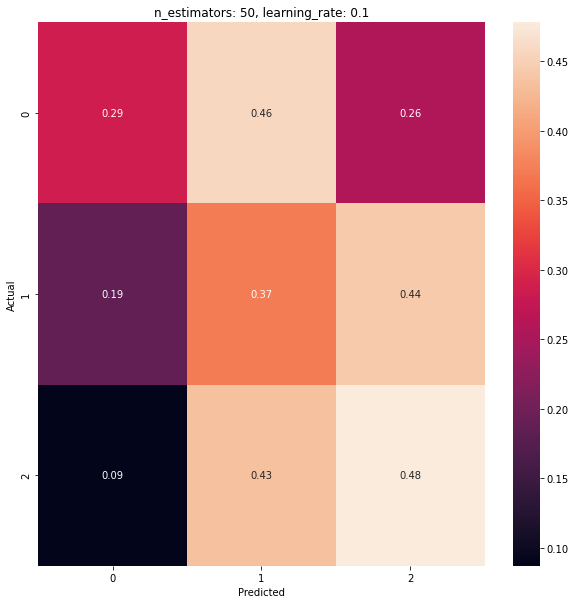

[0]	validation_0-mlogloss:1.09489
[1]	validation_0-mlogloss:1.09319
[2]	validation_0-mlogloss:1.09175
[3]	validation_0-mlogloss:1.09473
[4]	validation_0-mlogloss:1.09655
[5]	validation_0-mlogloss:1.09891
[6]	validation_0-mlogloss:1.09313
[7]	validation_0-mlogloss:1.09663
[8]	validation_0-mlogloss:1.09612
[9]	validation_0-mlogloss:1.09428
[10]	validation_0-mlogloss:1.09100
[11]	validation_0-mlogloss:1.09325
[12]	validation_0-mlogloss:1.09506
[13]	validation_0-mlogloss:1.09566
[14]	validation_0-mlogloss:1.10031
[15]	validation_0-mlogloss:1.09939
[16]	validation_0-mlogloss:1.10318
[17]	validation_0-mlogloss:1.10268
[18]	validation_0-mlogloss:1.10141
[19]	validation_0-mlogloss:1.10802
[20]	validation_0-mlogloss:1.11193


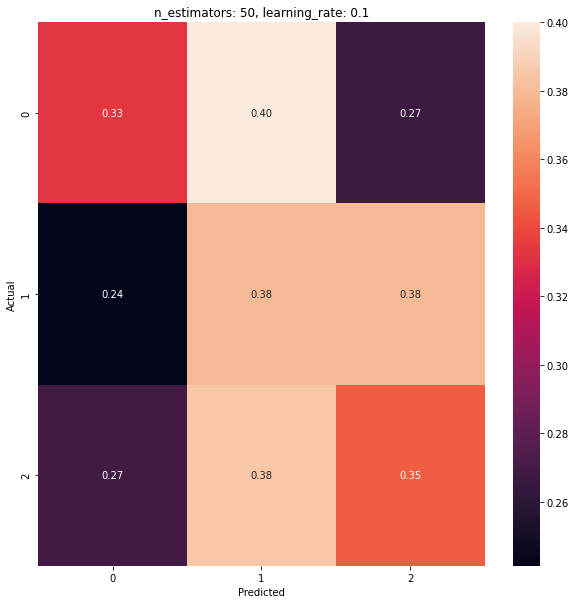

[0]	validation_0-mlogloss:1.09829
[1]	validation_0-mlogloss:1.09856
[2]	validation_0-mlogloss:1.09819
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09766
[5]	validation_0-mlogloss:1.09782
[6]	validation_0-mlogloss:1.09755
[7]	validation_0-mlogloss:1.09811
[8]	validation_0-mlogloss:1.09777
[9]	validation_0-mlogloss:1.09814
[10]	validation_0-mlogloss:1.09834
[11]	validation_0-mlogloss:1.09867
[12]	validation_0-mlogloss:1.09918
[13]	validation_0-mlogloss:1.09916
[14]	validation_0-mlogloss:1.09976
[15]	validation_0-mlogloss:1.10051
[16]	validation_0-mlogloss:1.10089


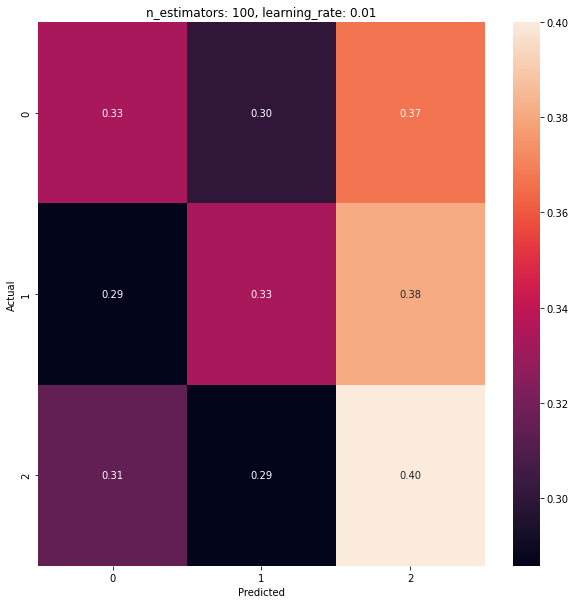

[0]	validation_0-mlogloss:1.09906
[1]	validation_0-mlogloss:1.09866
[2]	validation_0-mlogloss:1.09807
[3]	validation_0-mlogloss:1.09768
[4]	validation_0-mlogloss:1.09793
[5]	validation_0-mlogloss:1.09860
[6]	validation_0-mlogloss:1.09920
[7]	validation_0-mlogloss:1.09852
[8]	validation_0-mlogloss:1.09789
[9]	validation_0-mlogloss:1.09708
[10]	validation_0-mlogloss:1.09676
[11]	validation_0-mlogloss:1.09629
[12]	validation_0-mlogloss:1.09645
[13]	validation_0-mlogloss:1.09589
[14]	validation_0-mlogloss:1.09528
[15]	validation_0-mlogloss:1.09565
[16]	validation_0-mlogloss:1.09559
[17]	validation_0-mlogloss:1.09679
[18]	validation_0-mlogloss:1.09716
[19]	validation_0-mlogloss:1.09731
[20]	validation_0-mlogloss:1.09845
[21]	validation_0-mlogloss:1.09873
[22]	validation_0-mlogloss:1.09999
[23]	validation_0-mlogloss:1.10030
[24]	validation_0-mlogloss:1.10076


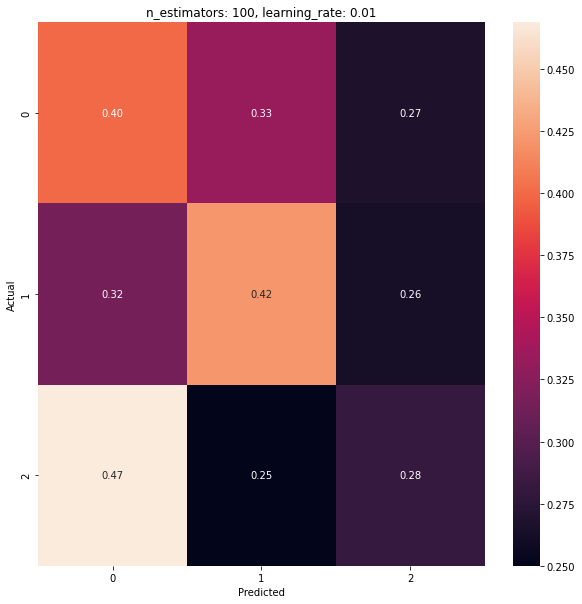

[0]	validation_0-mlogloss:1.09738
[1]	validation_0-mlogloss:1.09697
[2]	validation_0-mlogloss:1.09658
[3]	validation_0-mlogloss:1.09646
[4]	validation_0-mlogloss:1.09573
[5]	validation_0-mlogloss:1.09557
[6]	validation_0-mlogloss:1.09501
[7]	validation_0-mlogloss:1.09426
[8]	validation_0-mlogloss:1.09379
[9]	validation_0-mlogloss:1.09276
[10]	validation_0-mlogloss:1.09217
[11]	validation_0-mlogloss:1.09171
[12]	validation_0-mlogloss:1.09038
[13]	validation_0-mlogloss:1.08957
[14]	validation_0-mlogloss:1.08843
[15]	validation_0-mlogloss:1.08716
[16]	validation_0-mlogloss:1.08662
[17]	validation_0-mlogloss:1.08531
[18]	validation_0-mlogloss:1.08383
[19]	validation_0-mlogloss:1.08246
[20]	validation_0-mlogloss:1.08189
[21]	validation_0-mlogloss:1.08101
[22]	validation_0-mlogloss:1.08013
[23]	validation_0-mlogloss:1.07917
[24]	validation_0-mlogloss:1.07787
[25]	validation_0-mlogloss:1.07712
[26]	validation_0-mlogloss:1.07613
[27]	validation_0-mlogloss:1.07541
[28]	validation_0-mlogloss:1.0

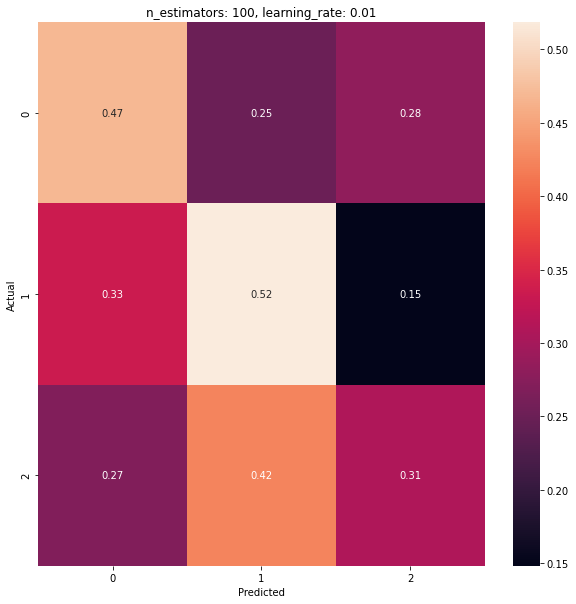

[0]	validation_0-mlogloss:1.09838
[1]	validation_0-mlogloss:1.09799
[2]	validation_0-mlogloss:1.09741
[3]	validation_0-mlogloss:1.09724
[4]	validation_0-mlogloss:1.09715
[5]	validation_0-mlogloss:1.09674
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09661
[8]	validation_0-mlogloss:1.09657
[9]	validation_0-mlogloss:1.09616
[10]	validation_0-mlogloss:1.09672
[11]	validation_0-mlogloss:1.09691
[12]	validation_0-mlogloss:1.09731
[13]	validation_0-mlogloss:1.09763
[14]	validation_0-mlogloss:1.09807
[15]	validation_0-mlogloss:1.09852
[16]	validation_0-mlogloss:1.09884
[17]	validation_0-mlogloss:1.09944
[18]	validation_0-mlogloss:1.09995


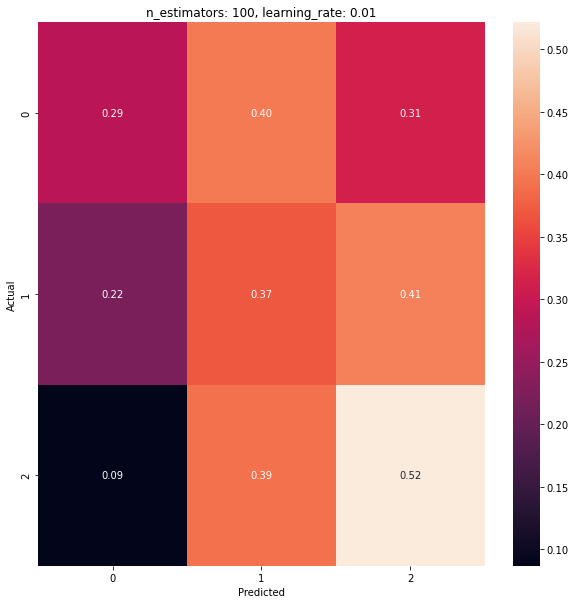

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09750
[2]	validation_0-mlogloss:1.09713
[3]	validation_0-mlogloss:1.09633
[4]	validation_0-mlogloss:1.09577
[5]	validation_0-mlogloss:1.09540
[6]	validation_0-mlogloss:1.09482
[7]	validation_0-mlogloss:1.09403
[8]	validation_0-mlogloss:1.09372
[9]	validation_0-mlogloss:1.09311
[10]	validation_0-mlogloss:1.09256
[11]	validation_0-mlogloss:1.09253
[12]	validation_0-mlogloss:1.09201
[13]	validation_0-mlogloss:1.09127
[14]	validation_0-mlogloss:1.09112
[15]	validation_0-mlogloss:1.09113
[16]	validation_0-mlogloss:1.09078
[17]	validation_0-mlogloss:1.09044
[18]	validation_0-mlogloss:1.09038
[19]	validation_0-mlogloss:1.09063
[20]	validation_0-mlogloss:1.09073
[21]	validation_0-mlogloss:1.09074
[22]	validation_0-mlogloss:1.09034
[23]	validation_0-mlogloss:1.09036
[24]	validation_0-mlogloss:1.09032
[25]	validation_0-mlogloss:1.09038
[26]	validation_0-mlogloss:1.09016
[27]	validation_0-mlogloss:1.09044
[28]	validation_0-mlogloss:1.0

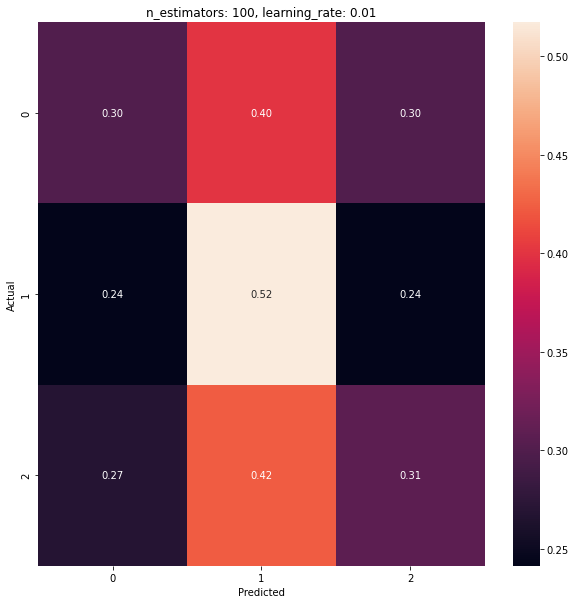

[0]	validation_0-mlogloss:1.09788
[1]	validation_0-mlogloss:1.09841
[2]	validation_0-mlogloss:1.09775
[3]	validation_0-mlogloss:1.09746
[4]	validation_0-mlogloss:1.09851
[5]	validation_0-mlogloss:1.09904
[6]	validation_0-mlogloss:1.10026
[7]	validation_0-mlogloss:1.10109
[8]	validation_0-mlogloss:1.10163
[9]	validation_0-mlogloss:1.10304
[10]	validation_0-mlogloss:1.10478
[11]	validation_0-mlogloss:1.10502
[12]	validation_0-mlogloss:1.10639
[13]	validation_0-mlogloss:1.10949


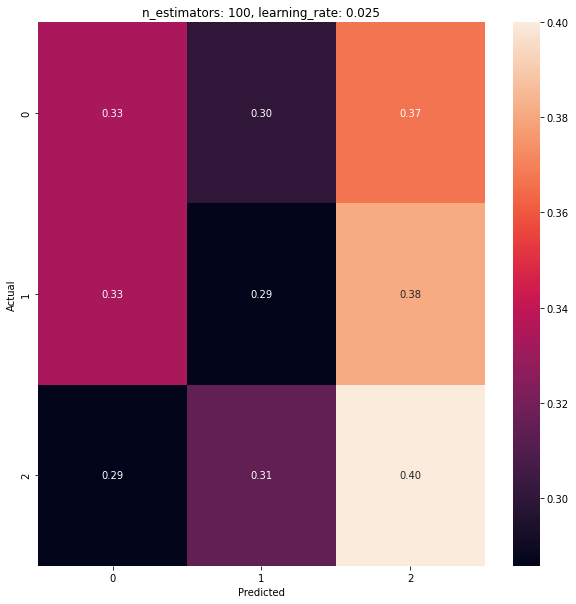

[0]	validation_0-mlogloss:1.09978
[1]	validation_0-mlogloss:1.09891
[2]	validation_0-mlogloss:1.09797
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09908
[5]	validation_0-mlogloss:1.09721
[6]	validation_0-mlogloss:1.09810
[7]	validation_0-mlogloss:1.09851
[8]	validation_0-mlogloss:1.10021
[9]	validation_0-mlogloss:1.10240
[10]	validation_0-mlogloss:1.10294
[11]	validation_0-mlogloss:1.10349
[12]	validation_0-mlogloss:1.10464
[13]	validation_0-mlogloss:1.10368
[14]	validation_0-mlogloss:1.10499
[15]	validation_0-mlogloss:1.10534


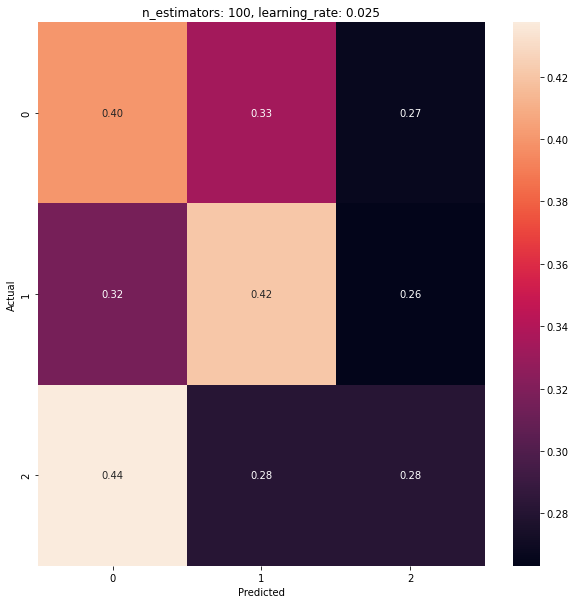

[0]	validation_0-mlogloss:1.09559
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09309
[3]	validation_0-mlogloss:1.09169
[4]	validation_0-mlogloss:1.08951
[5]	validation_0-mlogloss:1.08788
[6]	validation_0-mlogloss:1.08571
[7]	validation_0-mlogloss:1.08218
[8]	validation_0-mlogloss:1.08081
[9]	validation_0-mlogloss:1.07886
[10]	validation_0-mlogloss:1.07640
[11]	validation_0-mlogloss:1.07452
[12]	validation_0-mlogloss:1.07227
[13]	validation_0-mlogloss:1.07052
[14]	validation_0-mlogloss:1.07071
[15]	validation_0-mlogloss:1.06843
[16]	validation_0-mlogloss:1.06816
[17]	validation_0-mlogloss:1.06827
[18]	validation_0-mlogloss:1.06673
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06530
[21]	validation_0-mlogloss:1.06441
[22]	validation_0-mlogloss:1.06342
[23]	validation_0-mlogloss:1.06280
[24]	validation_0-mlogloss:1.06187
[25]	validation_0-mlogloss:1.06193
[26]	validation_0-mlogloss:1.06137
[27]	validation_0-mlogloss:1.06103
[28]	validation_0-mlogloss:1.0

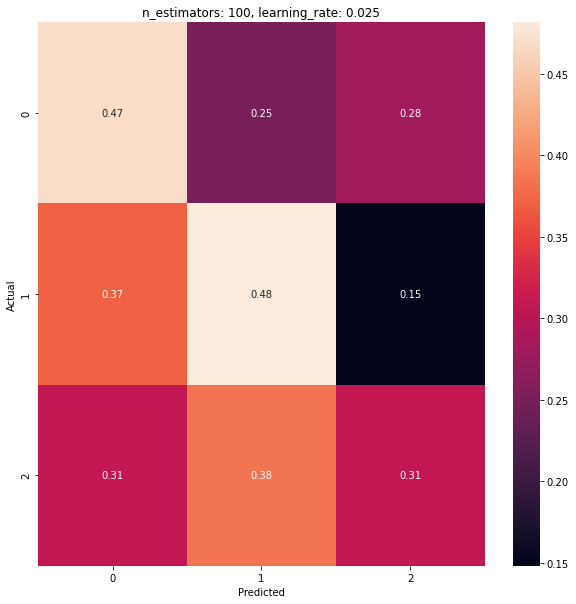

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09758
[2]	validation_0-mlogloss:1.09677
[3]	validation_0-mlogloss:1.09705
[4]	validation_0-mlogloss:1.09740
[5]	validation_0-mlogloss:1.09884
[6]	validation_0-mlogloss:1.09988
[7]	validation_0-mlogloss:1.10149
[8]	validation_0-mlogloss:1.10360
[9]	validation_0-mlogloss:1.10496
[10]	validation_0-mlogloss:1.10622
[11]	validation_0-mlogloss:1.10638
[12]	validation_0-mlogloss:1.10787


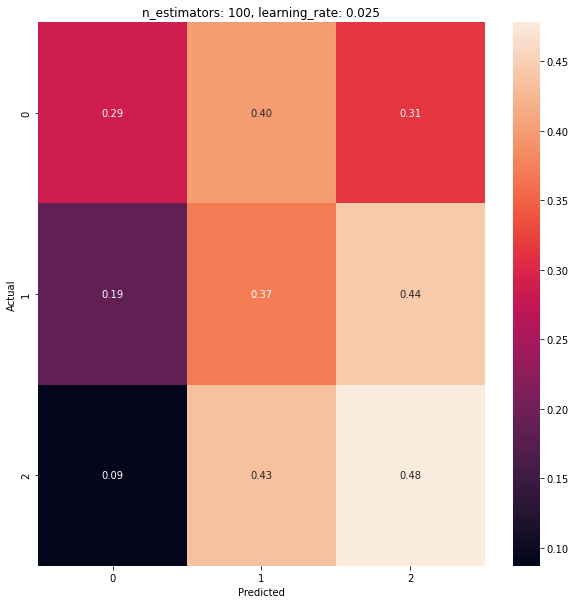

[0]	validation_0-mlogloss:1.09737
[1]	validation_0-mlogloss:1.09590
[2]	validation_0-mlogloss:1.09493
[3]	validation_0-mlogloss:1.09387
[4]	validation_0-mlogloss:1.09285
[5]	validation_0-mlogloss:1.09080
[6]	validation_0-mlogloss:1.08990
[7]	validation_0-mlogloss:1.09032
[8]	validation_0-mlogloss:1.09054
[9]	validation_0-mlogloss:1.09047
[10]	validation_0-mlogloss:1.08970
[11]	validation_0-mlogloss:1.08949
[12]	validation_0-mlogloss:1.08948
[13]	validation_0-mlogloss:1.08969
[14]	validation_0-mlogloss:1.09041
[15]	validation_0-mlogloss:1.09137
[16]	validation_0-mlogloss:1.09135
[17]	validation_0-mlogloss:1.09186
[18]	validation_0-mlogloss:1.09140
[19]	validation_0-mlogloss:1.09212
[20]	validation_0-mlogloss:1.09288
[21]	validation_0-mlogloss:1.09258


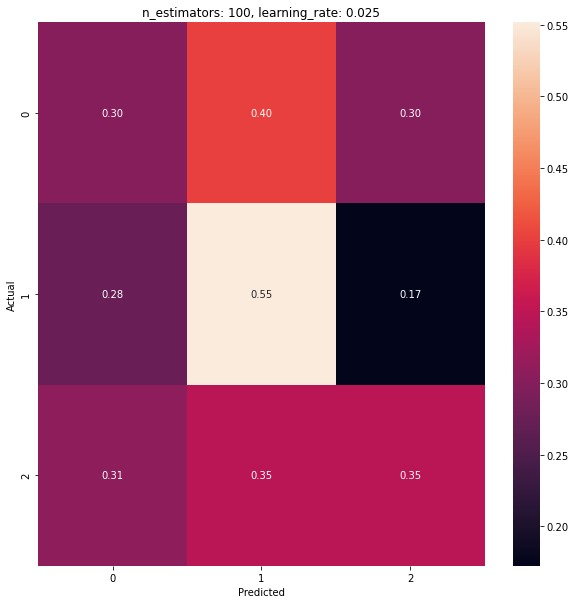

[0]	validation_0-mlogloss:1.09740
[1]	validation_0-mlogloss:1.09911
[2]	validation_0-mlogloss:1.10073
[3]	validation_0-mlogloss:1.10038
[4]	validation_0-mlogloss:1.10323
[5]	validation_0-mlogloss:1.10281
[6]	validation_0-mlogloss:1.10531
[7]	validation_0-mlogloss:1.10876
[8]	validation_0-mlogloss:1.11068
[9]	validation_0-mlogloss:1.11266
[10]	validation_0-mlogloss:1.11642


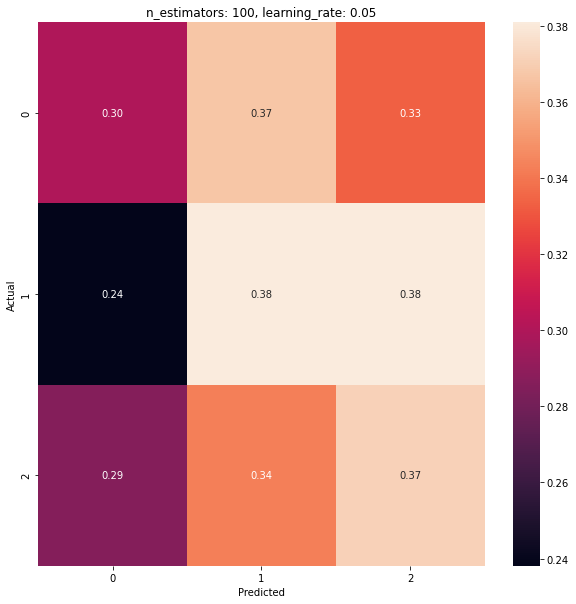

[0]	validation_0-mlogloss:1.10113
[1]	validation_0-mlogloss:1.10013
[2]	validation_0-mlogloss:1.10111
[3]	validation_0-mlogloss:1.09839
[4]	validation_0-mlogloss:1.10285
[5]	validation_0-mlogloss:1.10316
[6]	validation_0-mlogloss:1.10488
[7]	validation_0-mlogloss:1.10410
[8]	validation_0-mlogloss:1.10576
[9]	validation_0-mlogloss:1.10405
[10]	validation_0-mlogloss:1.10492
[11]	validation_0-mlogloss:1.10447
[12]	validation_0-mlogloss:1.10698
[13]	validation_0-mlogloss:1.10368


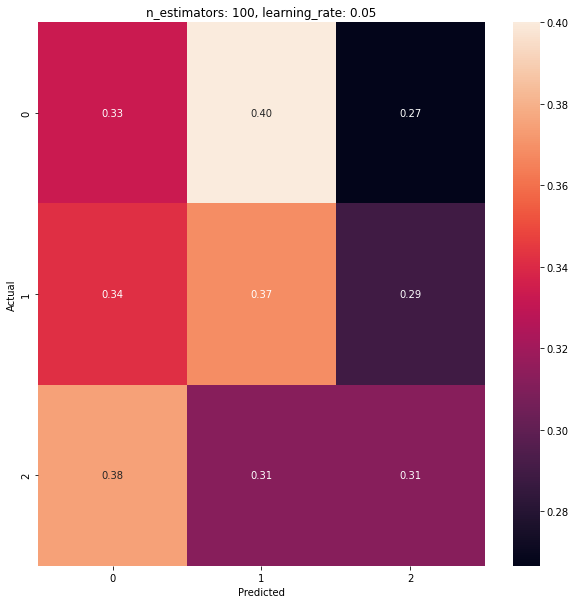

[0]	validation_0-mlogloss:1.09281
[1]	validation_0-mlogloss:1.08971
[2]	validation_0-mlogloss:1.08655
[3]	validation_0-mlogloss:1.08418
[4]	validation_0-mlogloss:1.07656
[5]	validation_0-mlogloss:1.07297
[6]	validation_0-mlogloss:1.06904
[7]	validation_0-mlogloss:1.06581
[8]	validation_0-mlogloss:1.06612
[9]	validation_0-mlogloss:1.06327
[10]	validation_0-mlogloss:1.06027
[11]	validation_0-mlogloss:1.06034
[12]	validation_0-mlogloss:1.06064
[13]	validation_0-mlogloss:1.05975
[14]	validation_0-mlogloss:1.06121
[15]	validation_0-mlogloss:1.06287
[16]	validation_0-mlogloss:1.06382
[17]	validation_0-mlogloss:1.06441
[18]	validation_0-mlogloss:1.06873
[19]	validation_0-mlogloss:1.07052
[20]	validation_0-mlogloss:1.07333
[21]	validation_0-mlogloss:1.07565
[22]	validation_0-mlogloss:1.07767
[23]	validation_0-mlogloss:1.08164


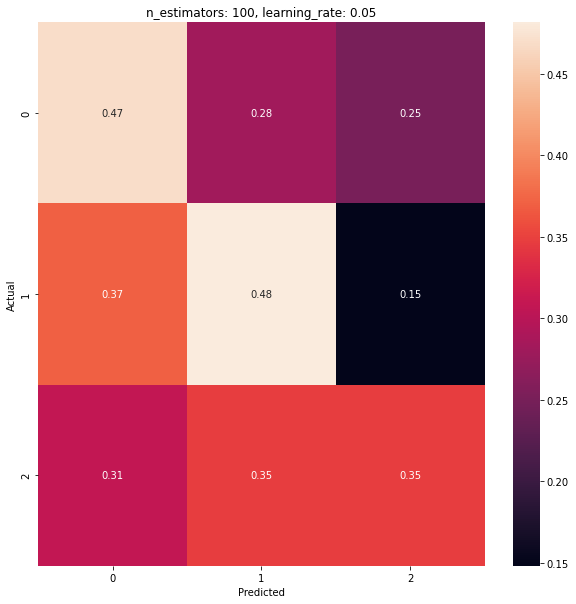

[0]	validation_0-mlogloss:1.09781
[1]	validation_0-mlogloss:1.09764
[2]	validation_0-mlogloss:1.10021
[3]	validation_0-mlogloss:1.10267
[4]	validation_0-mlogloss:1.10874
[5]	validation_0-mlogloss:1.11259
[6]	validation_0-mlogloss:1.11425
[7]	validation_0-mlogloss:1.11787
[8]	validation_0-mlogloss:1.12066
[9]	validation_0-mlogloss:1.12619
[10]	validation_0-mlogloss:1.12930


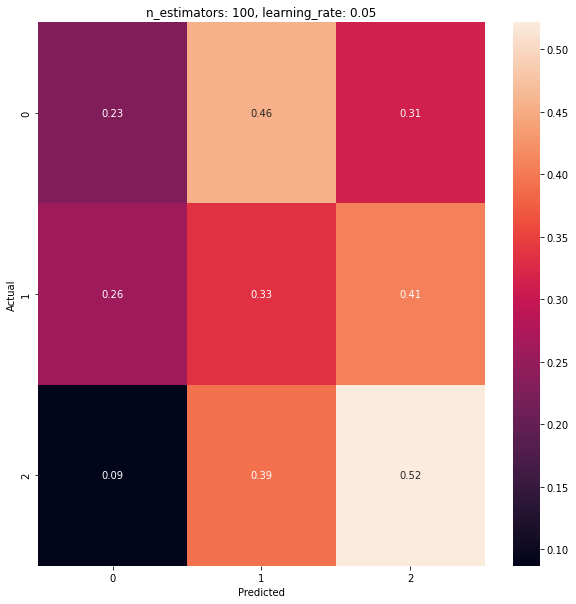

[0]	validation_0-mlogloss:1.09634
[1]	validation_0-mlogloss:1.09444
[2]	validation_0-mlogloss:1.09290
[3]	validation_0-mlogloss:1.09276
[4]	validation_0-mlogloss:1.09197
[5]	validation_0-mlogloss:1.09180
[6]	validation_0-mlogloss:1.09114
[7]	validation_0-mlogloss:1.09111
[8]	validation_0-mlogloss:1.09128
[9]	validation_0-mlogloss:1.09588
[10]	validation_0-mlogloss:1.09280
[11]	validation_0-mlogloss:1.09302
[12]	validation_0-mlogloss:1.08974
[13]	validation_0-mlogloss:1.08843
[14]	validation_0-mlogloss:1.08827
[15]	validation_0-mlogloss:1.08868
[16]	validation_0-mlogloss:1.08605
[17]	validation_0-mlogloss:1.08521
[18]	validation_0-mlogloss:1.08698
[19]	validation_0-mlogloss:1.08856
[20]	validation_0-mlogloss:1.08944
[21]	validation_0-mlogloss:1.09035
[22]	validation_0-mlogloss:1.09231
[23]	validation_0-mlogloss:1.09253
[24]	validation_0-mlogloss:1.09323
[25]	validation_0-mlogloss:1.09434
[26]	validation_0-mlogloss:1.09501


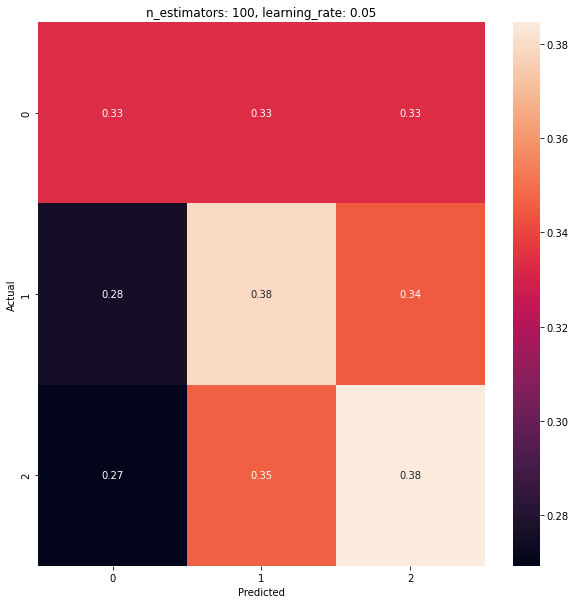

[0]	validation_0-mlogloss:1.09724
[1]	validation_0-mlogloss:1.10274
[2]	validation_0-mlogloss:1.10457
[3]	validation_0-mlogloss:1.11642
[4]	validation_0-mlogloss:1.12113
[5]	validation_0-mlogloss:1.12194
[6]	validation_0-mlogloss:1.12291
[7]	validation_0-mlogloss:1.12334
[8]	validation_0-mlogloss:1.12568
[9]	validation_0-mlogloss:1.13071
[10]	validation_0-mlogloss:1.13432


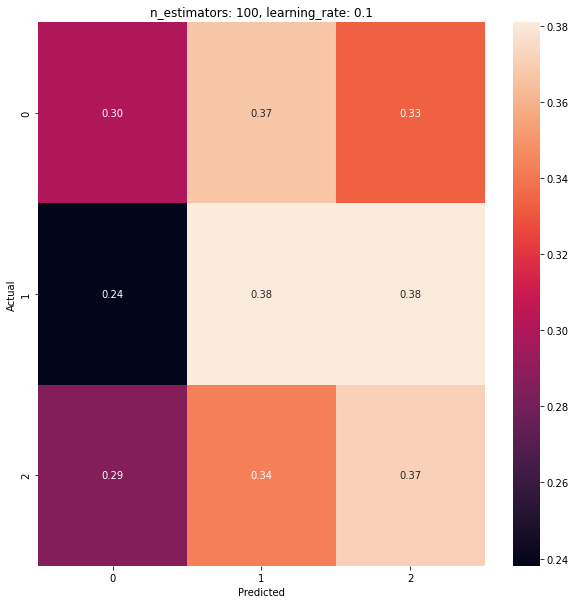

[0]	validation_0-mlogloss:1.10437
[1]	validation_0-mlogloss:1.09846
[2]	validation_0-mlogloss:1.09525
[3]	validation_0-mlogloss:1.10131
[4]	validation_0-mlogloss:1.10533
[5]	validation_0-mlogloss:1.10307
[6]	validation_0-mlogloss:1.10573
[7]	validation_0-mlogloss:1.11502
[8]	validation_0-mlogloss:1.10833
[9]	validation_0-mlogloss:1.11055
[10]	validation_0-mlogloss:1.11112
[11]	validation_0-mlogloss:1.11318
[12]	validation_0-mlogloss:1.11706


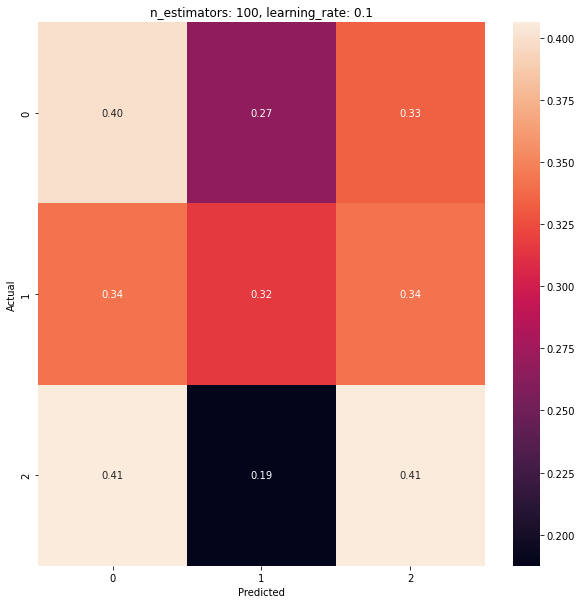

[0]	validation_0-mlogloss:1.08795
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07301
[3]	validation_0-mlogloss:1.06549
[4]	validation_0-mlogloss:1.06049
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05704
[7]	validation_0-mlogloss:1.05613
[8]	validation_0-mlogloss:1.05914
[9]	validation_0-mlogloss:1.05990
[10]	validation_0-mlogloss:1.06619
[11]	validation_0-mlogloss:1.07081
[12]	validation_0-mlogloss:1.07317
[13]	validation_0-mlogloss:1.07471
[14]	validation_0-mlogloss:1.07885
[15]	validation_0-mlogloss:1.07562
[16]	validation_0-mlogloss:1.07781
[17]	validation_0-mlogloss:1.07637


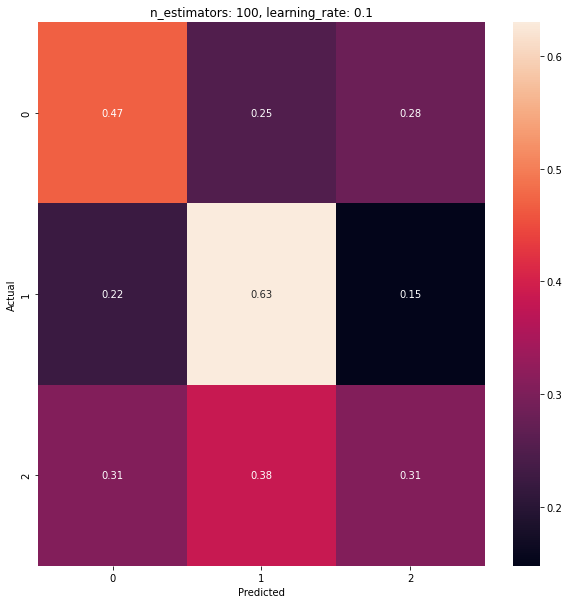

[0]	validation_0-mlogloss:1.09798
[1]	validation_0-mlogloss:1.10043
[2]	validation_0-mlogloss:1.11191
[3]	validation_0-mlogloss:1.11688
[4]	validation_0-mlogloss:1.12780
[5]	validation_0-mlogloss:1.13067
[6]	validation_0-mlogloss:1.13585
[7]	validation_0-mlogloss:1.13626
[8]	validation_0-mlogloss:1.13844
[9]	validation_0-mlogloss:1.14301
[10]	validation_0-mlogloss:1.15277


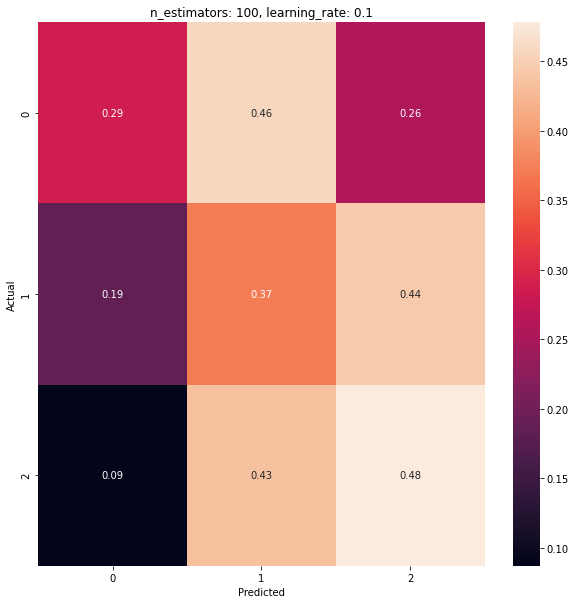

[0]	validation_0-mlogloss:1.09489
[1]	validation_0-mlogloss:1.09319
[2]	validation_0-mlogloss:1.09175
[3]	validation_0-mlogloss:1.09473
[4]	validation_0-mlogloss:1.09655
[5]	validation_0-mlogloss:1.09891
[6]	validation_0-mlogloss:1.09313
[7]	validation_0-mlogloss:1.09663
[8]	validation_0-mlogloss:1.09612
[9]	validation_0-mlogloss:1.09428
[10]	validation_0-mlogloss:1.09100
[11]	validation_0-mlogloss:1.09325
[12]	validation_0-mlogloss:1.09506
[13]	validation_0-mlogloss:1.09566
[14]	validation_0-mlogloss:1.10031
[15]	validation_0-mlogloss:1.09939
[16]	validation_0-mlogloss:1.10318
[17]	validation_0-mlogloss:1.10268
[18]	validation_0-mlogloss:1.10141
[19]	validation_0-mlogloss:1.10802


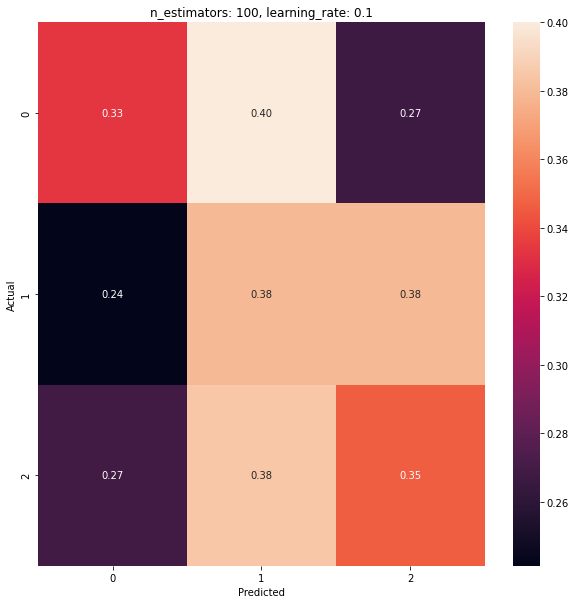

[0]	validation_0-mlogloss:1.09829
[1]	validation_0-mlogloss:1.09856
[2]	validation_0-mlogloss:1.09819
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09766
[5]	validation_0-mlogloss:1.09782
[6]	validation_0-mlogloss:1.09755
[7]	validation_0-mlogloss:1.09811
[8]	validation_0-mlogloss:1.09777
[9]	validation_0-mlogloss:1.09814
[10]	validation_0-mlogloss:1.09834
[11]	validation_0-mlogloss:1.09867
[12]	validation_0-mlogloss:1.09918
[13]	validation_0-mlogloss:1.09916
[14]	validation_0-mlogloss:1.09976
[15]	validation_0-mlogloss:1.10051


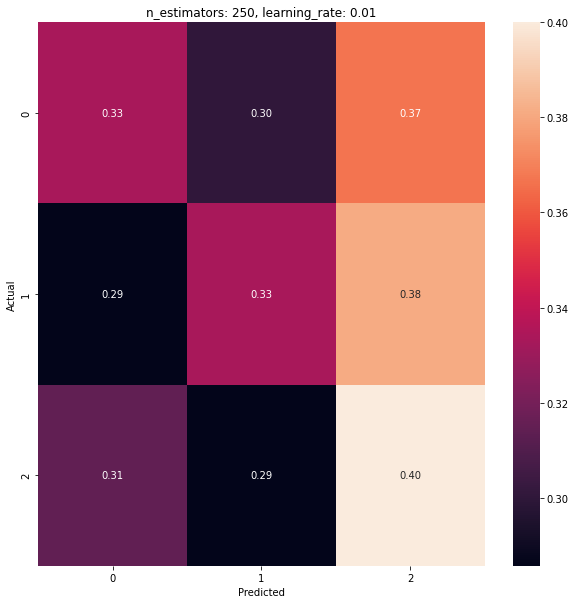

[0]	validation_0-mlogloss:1.09906
[1]	validation_0-mlogloss:1.09866
[2]	validation_0-mlogloss:1.09807
[3]	validation_0-mlogloss:1.09768
[4]	validation_0-mlogloss:1.09793
[5]	validation_0-mlogloss:1.09860
[6]	validation_0-mlogloss:1.09920
[7]	validation_0-mlogloss:1.09852
[8]	validation_0-mlogloss:1.09789
[9]	validation_0-mlogloss:1.09708
[10]	validation_0-mlogloss:1.09676
[11]	validation_0-mlogloss:1.09629
[12]	validation_0-mlogloss:1.09645
[13]	validation_0-mlogloss:1.09589
[14]	validation_0-mlogloss:1.09528
[15]	validation_0-mlogloss:1.09565
[16]	validation_0-mlogloss:1.09559
[17]	validation_0-mlogloss:1.09679
[18]	validation_0-mlogloss:1.09716
[19]	validation_0-mlogloss:1.09731
[20]	validation_0-mlogloss:1.09845
[21]	validation_0-mlogloss:1.09873
[22]	validation_0-mlogloss:1.09999
[23]	validation_0-mlogloss:1.10030


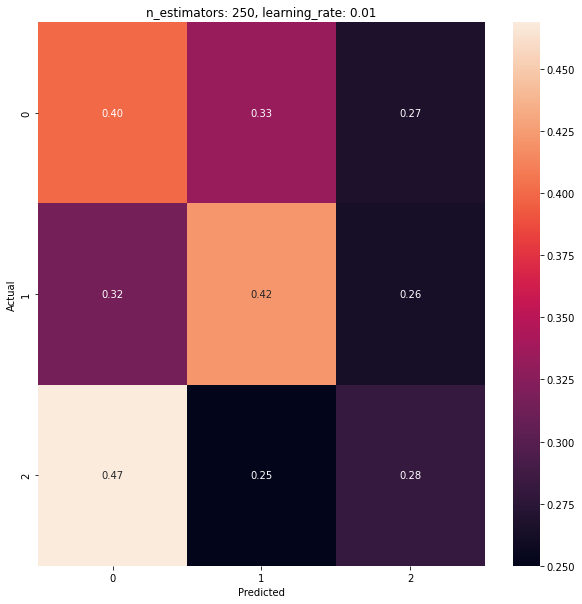

[0]	validation_0-mlogloss:1.09738
[1]	validation_0-mlogloss:1.09697
[2]	validation_0-mlogloss:1.09658
[3]	validation_0-mlogloss:1.09646
[4]	validation_0-mlogloss:1.09573
[5]	validation_0-mlogloss:1.09557
[6]	validation_0-mlogloss:1.09501
[7]	validation_0-mlogloss:1.09426
[8]	validation_0-mlogloss:1.09379
[9]	validation_0-mlogloss:1.09276
[10]	validation_0-mlogloss:1.09217
[11]	validation_0-mlogloss:1.09171
[12]	validation_0-mlogloss:1.09038
[13]	validation_0-mlogloss:1.08957
[14]	validation_0-mlogloss:1.08843
[15]	validation_0-mlogloss:1.08716
[16]	validation_0-mlogloss:1.08662
[17]	validation_0-mlogloss:1.08531
[18]	validation_0-mlogloss:1.08383
[19]	validation_0-mlogloss:1.08246
[20]	validation_0-mlogloss:1.08189
[21]	validation_0-mlogloss:1.08101
[22]	validation_0-mlogloss:1.08013
[23]	validation_0-mlogloss:1.07917
[24]	validation_0-mlogloss:1.07787
[25]	validation_0-mlogloss:1.07712
[26]	validation_0-mlogloss:1.07613
[27]	validation_0-mlogloss:1.07541
[28]	validation_0-mlogloss:1.0

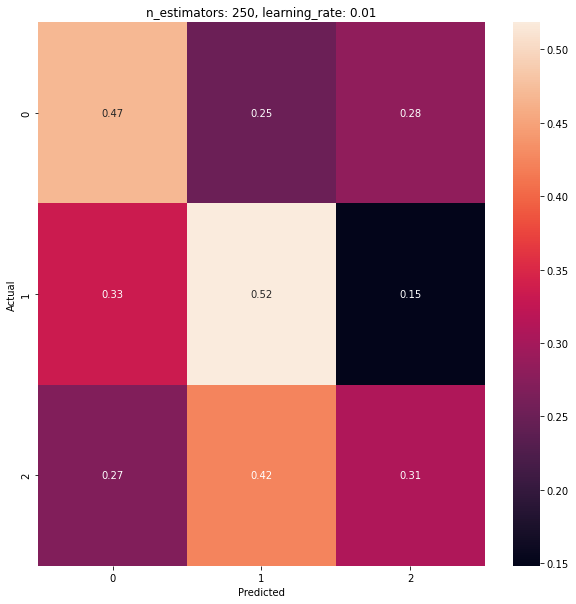

[0]	validation_0-mlogloss:1.09838
[1]	validation_0-mlogloss:1.09799
[2]	validation_0-mlogloss:1.09741
[3]	validation_0-mlogloss:1.09724
[4]	validation_0-mlogloss:1.09715
[5]	validation_0-mlogloss:1.09674
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09661
[8]	validation_0-mlogloss:1.09657
[9]	validation_0-mlogloss:1.09616
[10]	validation_0-mlogloss:1.09672
[11]	validation_0-mlogloss:1.09691
[12]	validation_0-mlogloss:1.09731
[13]	validation_0-mlogloss:1.09763
[14]	validation_0-mlogloss:1.09807
[15]	validation_0-mlogloss:1.09852
[16]	validation_0-mlogloss:1.09884
[17]	validation_0-mlogloss:1.09944
[18]	validation_0-mlogloss:1.09995


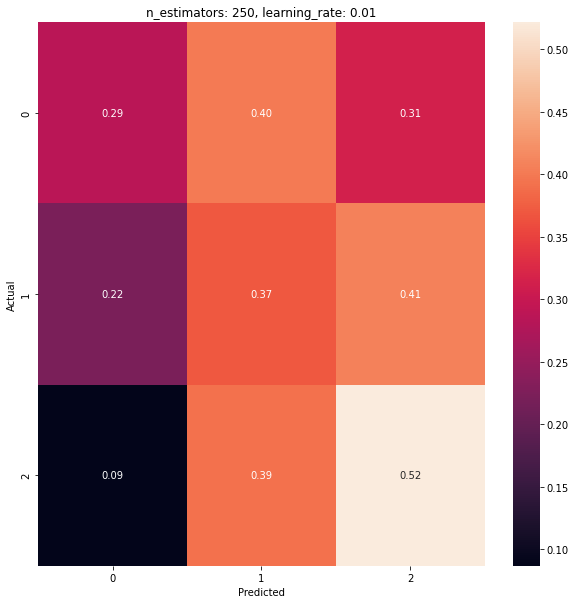

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09750
[2]	validation_0-mlogloss:1.09713
[3]	validation_0-mlogloss:1.09633
[4]	validation_0-mlogloss:1.09577
[5]	validation_0-mlogloss:1.09540
[6]	validation_0-mlogloss:1.09482
[7]	validation_0-mlogloss:1.09403
[8]	validation_0-mlogloss:1.09372
[9]	validation_0-mlogloss:1.09311
[10]	validation_0-mlogloss:1.09256
[11]	validation_0-mlogloss:1.09253
[12]	validation_0-mlogloss:1.09201
[13]	validation_0-mlogloss:1.09127
[14]	validation_0-mlogloss:1.09112
[15]	validation_0-mlogloss:1.09113
[16]	validation_0-mlogloss:1.09078
[17]	validation_0-mlogloss:1.09044
[18]	validation_0-mlogloss:1.09038
[19]	validation_0-mlogloss:1.09063
[20]	validation_0-mlogloss:1.09073
[21]	validation_0-mlogloss:1.09074
[22]	validation_0-mlogloss:1.09034
[23]	validation_0-mlogloss:1.09036
[24]	validation_0-mlogloss:1.09032
[25]	validation_0-mlogloss:1.09038
[26]	validation_0-mlogloss:1.09016
[27]	validation_0-mlogloss:1.09044
[28]	validation_0-mlogloss:1.0

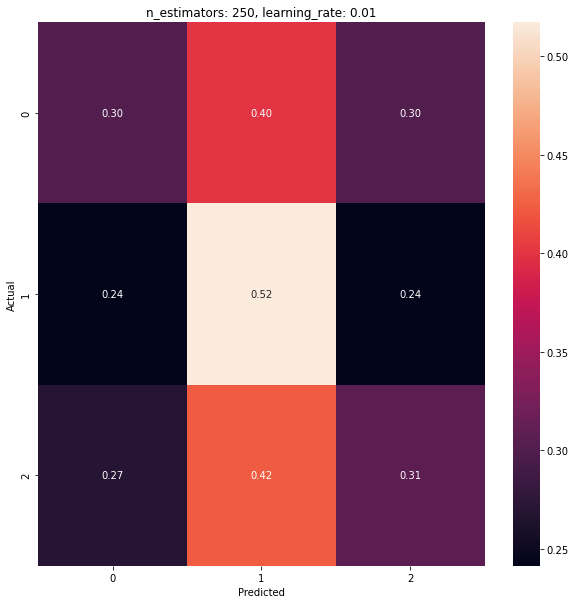

[0]	validation_0-mlogloss:1.09788
[1]	validation_0-mlogloss:1.09841
[2]	validation_0-mlogloss:1.09775
[3]	validation_0-mlogloss:1.09746
[4]	validation_0-mlogloss:1.09851
[5]	validation_0-mlogloss:1.09904
[6]	validation_0-mlogloss:1.10026
[7]	validation_0-mlogloss:1.10109
[8]	validation_0-mlogloss:1.10163
[9]	validation_0-mlogloss:1.10304
[10]	validation_0-mlogloss:1.10478
[11]	validation_0-mlogloss:1.10502
[12]	validation_0-mlogloss:1.10639


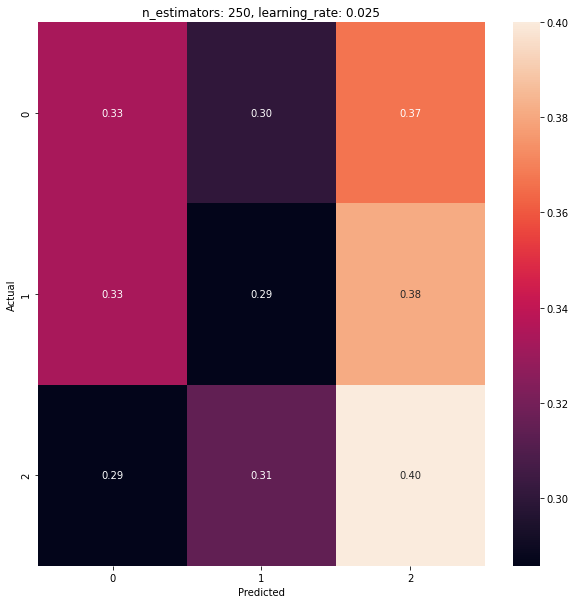

[0]	validation_0-mlogloss:1.09978
[1]	validation_0-mlogloss:1.09891
[2]	validation_0-mlogloss:1.09797
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09908
[5]	validation_0-mlogloss:1.09721
[6]	validation_0-mlogloss:1.09810
[7]	validation_0-mlogloss:1.09851
[8]	validation_0-mlogloss:1.10021
[9]	validation_0-mlogloss:1.10240
[10]	validation_0-mlogloss:1.10294
[11]	validation_0-mlogloss:1.10349
[12]	validation_0-mlogloss:1.10464
[13]	validation_0-mlogloss:1.10368
[14]	validation_0-mlogloss:1.10499
[15]	validation_0-mlogloss:1.10534


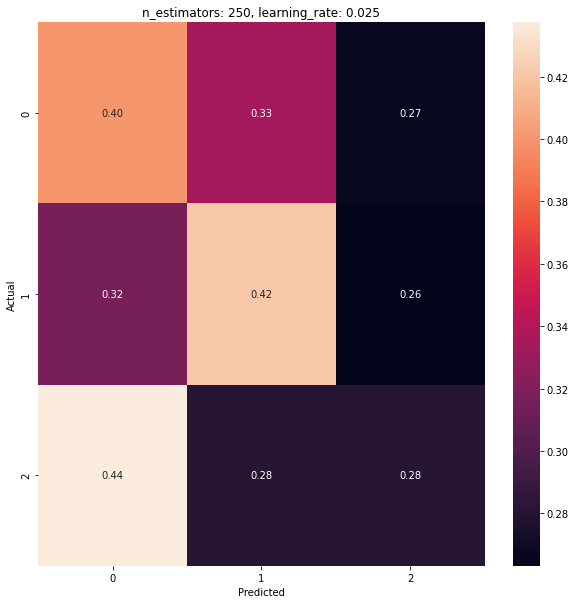

[0]	validation_0-mlogloss:1.09559
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09309
[3]	validation_0-mlogloss:1.09169
[4]	validation_0-mlogloss:1.08951
[5]	validation_0-mlogloss:1.08788
[6]	validation_0-mlogloss:1.08571
[7]	validation_0-mlogloss:1.08218
[8]	validation_0-mlogloss:1.08081
[9]	validation_0-mlogloss:1.07886
[10]	validation_0-mlogloss:1.07640
[11]	validation_0-mlogloss:1.07452
[12]	validation_0-mlogloss:1.07227
[13]	validation_0-mlogloss:1.07052
[14]	validation_0-mlogloss:1.07071
[15]	validation_0-mlogloss:1.06843
[16]	validation_0-mlogloss:1.06816
[17]	validation_0-mlogloss:1.06827
[18]	validation_0-mlogloss:1.06673
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06530
[21]	validation_0-mlogloss:1.06441
[22]	validation_0-mlogloss:1.06342
[23]	validation_0-mlogloss:1.06280
[24]	validation_0-mlogloss:1.06187
[25]	validation_0-mlogloss:1.06193
[26]	validation_0-mlogloss:1.06137
[27]	validation_0-mlogloss:1.06103
[28]	validation_0-mlogloss:1.0

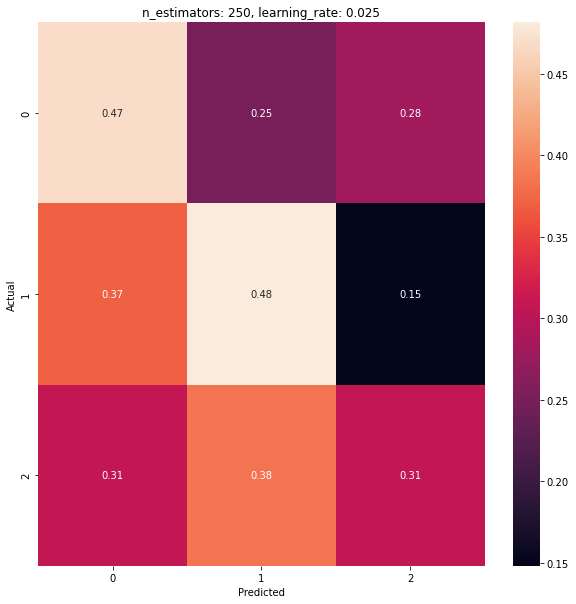

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09758
[2]	validation_0-mlogloss:1.09677
[3]	validation_0-mlogloss:1.09705
[4]	validation_0-mlogloss:1.09740
[5]	validation_0-mlogloss:1.09884
[6]	validation_0-mlogloss:1.09988
[7]	validation_0-mlogloss:1.10149
[8]	validation_0-mlogloss:1.10360
[9]	validation_0-mlogloss:1.10496
[10]	validation_0-mlogloss:1.10622
[11]	validation_0-mlogloss:1.10638
[12]	validation_0-mlogloss:1.10787


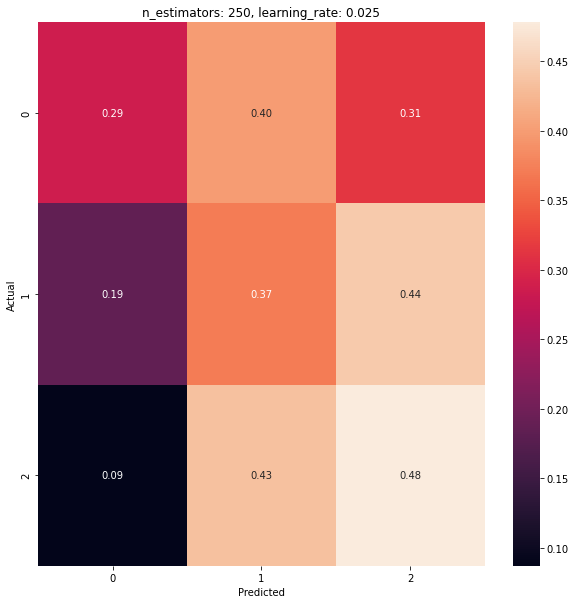

[0]	validation_0-mlogloss:1.09737
[1]	validation_0-mlogloss:1.09590
[2]	validation_0-mlogloss:1.09493
[3]	validation_0-mlogloss:1.09387
[4]	validation_0-mlogloss:1.09285
[5]	validation_0-mlogloss:1.09080
[6]	validation_0-mlogloss:1.08990
[7]	validation_0-mlogloss:1.09032
[8]	validation_0-mlogloss:1.09054
[9]	validation_0-mlogloss:1.09047
[10]	validation_0-mlogloss:1.08970
[11]	validation_0-mlogloss:1.08949
[12]	validation_0-mlogloss:1.08948
[13]	validation_0-mlogloss:1.08969
[14]	validation_0-mlogloss:1.09041
[15]	validation_0-mlogloss:1.09137
[16]	validation_0-mlogloss:1.09135
[17]	validation_0-mlogloss:1.09186
[18]	validation_0-mlogloss:1.09140
[19]	validation_0-mlogloss:1.09212
[20]	validation_0-mlogloss:1.09288
[21]	validation_0-mlogloss:1.09258


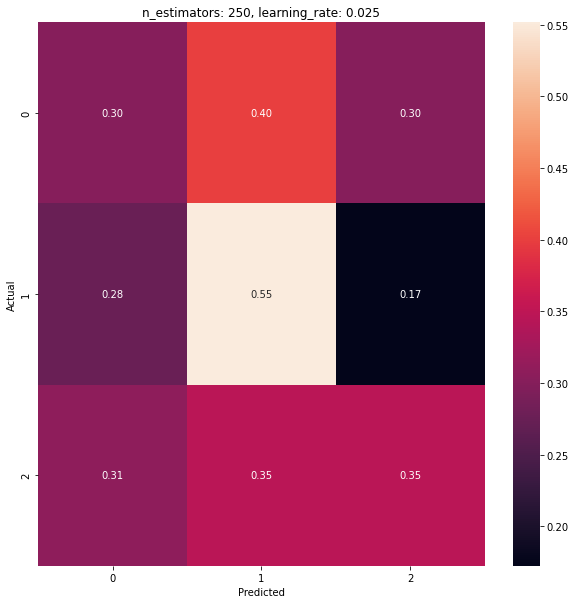

[0]	validation_0-mlogloss:1.09740
[1]	validation_0-mlogloss:1.09911
[2]	validation_0-mlogloss:1.10073
[3]	validation_0-mlogloss:1.10038
[4]	validation_0-mlogloss:1.10323
[5]	validation_0-mlogloss:1.10281
[6]	validation_0-mlogloss:1.10531
[7]	validation_0-mlogloss:1.10876
[8]	validation_0-mlogloss:1.11068
[9]	validation_0-mlogloss:1.11266
[10]	validation_0-mlogloss:1.11642


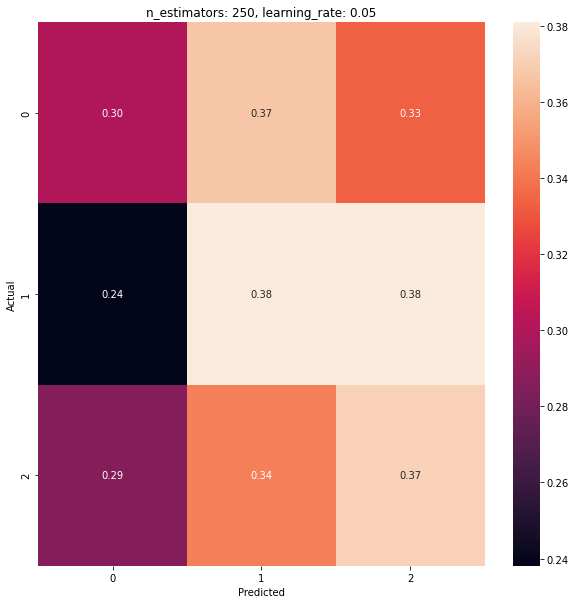

[0]	validation_0-mlogloss:1.10113
[1]	validation_0-mlogloss:1.10013
[2]	validation_0-mlogloss:1.10111
[3]	validation_0-mlogloss:1.09839
[4]	validation_0-mlogloss:1.10285
[5]	validation_0-mlogloss:1.10316
[6]	validation_0-mlogloss:1.10488
[7]	validation_0-mlogloss:1.10410
[8]	validation_0-mlogloss:1.10576
[9]	validation_0-mlogloss:1.10405
[10]	validation_0-mlogloss:1.10492
[11]	validation_0-mlogloss:1.10447
[12]	validation_0-mlogloss:1.10698


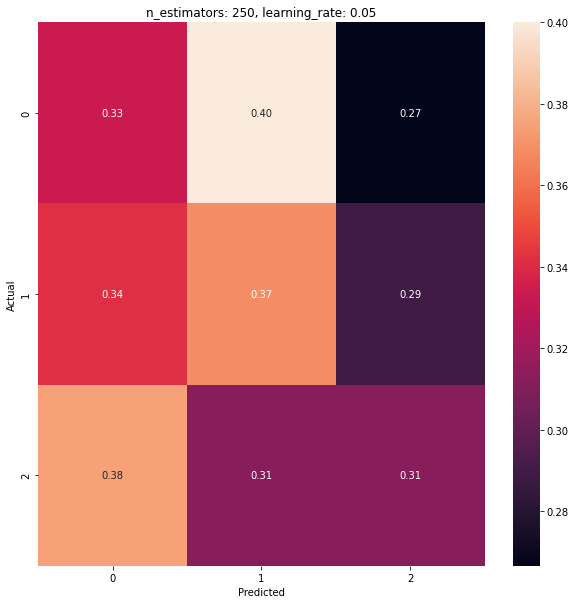

[0]	validation_0-mlogloss:1.09281
[1]	validation_0-mlogloss:1.08971
[2]	validation_0-mlogloss:1.08655
[3]	validation_0-mlogloss:1.08418
[4]	validation_0-mlogloss:1.07656
[5]	validation_0-mlogloss:1.07297
[6]	validation_0-mlogloss:1.06904
[7]	validation_0-mlogloss:1.06581
[8]	validation_0-mlogloss:1.06612
[9]	validation_0-mlogloss:1.06327
[10]	validation_0-mlogloss:1.06027
[11]	validation_0-mlogloss:1.06034
[12]	validation_0-mlogloss:1.06064
[13]	validation_0-mlogloss:1.05975
[14]	validation_0-mlogloss:1.06121
[15]	validation_0-mlogloss:1.06287
[16]	validation_0-mlogloss:1.06382
[17]	validation_0-mlogloss:1.06441
[18]	validation_0-mlogloss:1.06873
[19]	validation_0-mlogloss:1.07052
[20]	validation_0-mlogloss:1.07333
[21]	validation_0-mlogloss:1.07565
[22]	validation_0-mlogloss:1.07767
[23]	validation_0-mlogloss:1.08164


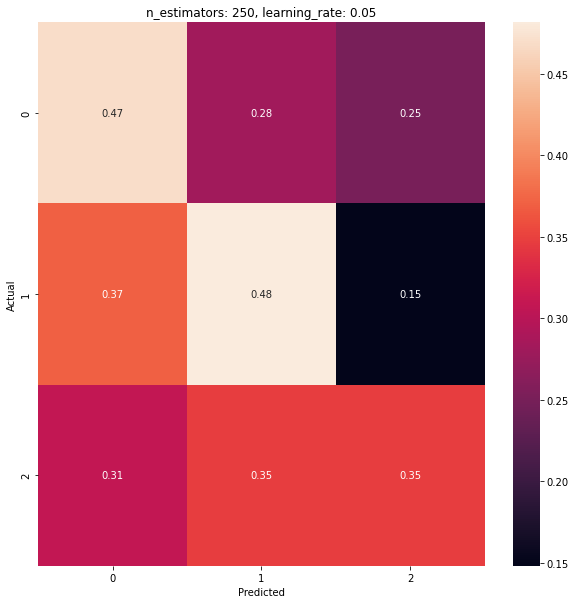

[0]	validation_0-mlogloss:1.09781
[1]	validation_0-mlogloss:1.09764
[2]	validation_0-mlogloss:1.10021
[3]	validation_0-mlogloss:1.10267
[4]	validation_0-mlogloss:1.10874
[5]	validation_0-mlogloss:1.11259
[6]	validation_0-mlogloss:1.11425
[7]	validation_0-mlogloss:1.11787
[8]	validation_0-mlogloss:1.12066
[9]	validation_0-mlogloss:1.12619
[10]	validation_0-mlogloss:1.12930


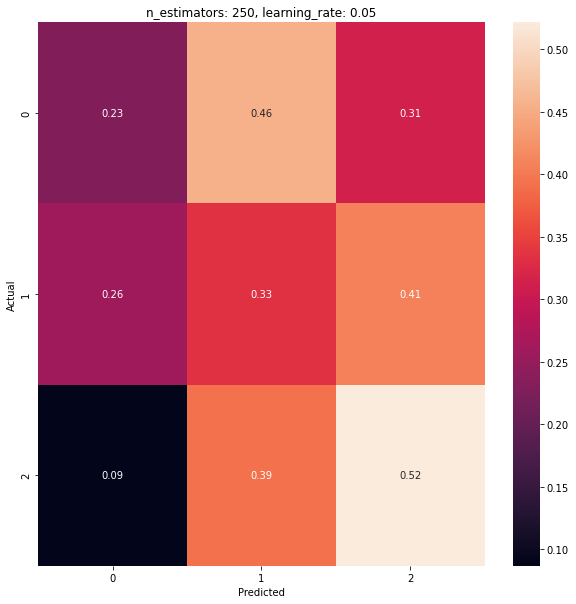

[0]	validation_0-mlogloss:1.09634
[1]	validation_0-mlogloss:1.09444
[2]	validation_0-mlogloss:1.09290
[3]	validation_0-mlogloss:1.09276
[4]	validation_0-mlogloss:1.09197
[5]	validation_0-mlogloss:1.09180
[6]	validation_0-mlogloss:1.09114
[7]	validation_0-mlogloss:1.09111
[8]	validation_0-mlogloss:1.09128
[9]	validation_0-mlogloss:1.09588
[10]	validation_0-mlogloss:1.09280
[11]	validation_0-mlogloss:1.09302
[12]	validation_0-mlogloss:1.08974
[13]	validation_0-mlogloss:1.08843
[14]	validation_0-mlogloss:1.08827
[15]	validation_0-mlogloss:1.08868
[16]	validation_0-mlogloss:1.08605
[17]	validation_0-mlogloss:1.08521
[18]	validation_0-mlogloss:1.08698
[19]	validation_0-mlogloss:1.08856
[20]	validation_0-mlogloss:1.08944
[21]	validation_0-mlogloss:1.09035
[22]	validation_0-mlogloss:1.09231
[23]	validation_0-mlogloss:1.09253
[24]	validation_0-mlogloss:1.09323
[25]	validation_0-mlogloss:1.09434
[26]	validation_0-mlogloss:1.09501
[27]	validation_0-mlogloss:1.09431


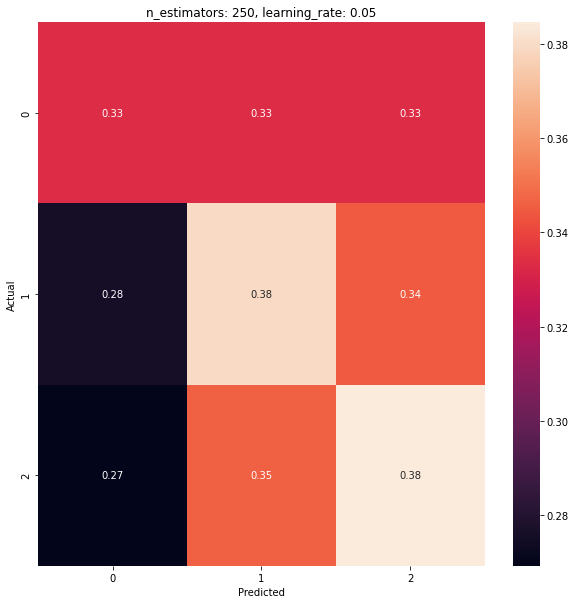

[0]	validation_0-mlogloss:1.09724
[1]	validation_0-mlogloss:1.10274
[2]	validation_0-mlogloss:1.10457
[3]	validation_0-mlogloss:1.11642
[4]	validation_0-mlogloss:1.12113
[5]	validation_0-mlogloss:1.12194
[6]	validation_0-mlogloss:1.12291
[7]	validation_0-mlogloss:1.12334
[8]	validation_0-mlogloss:1.12568
[9]	validation_0-mlogloss:1.13071
[10]	validation_0-mlogloss:1.13432


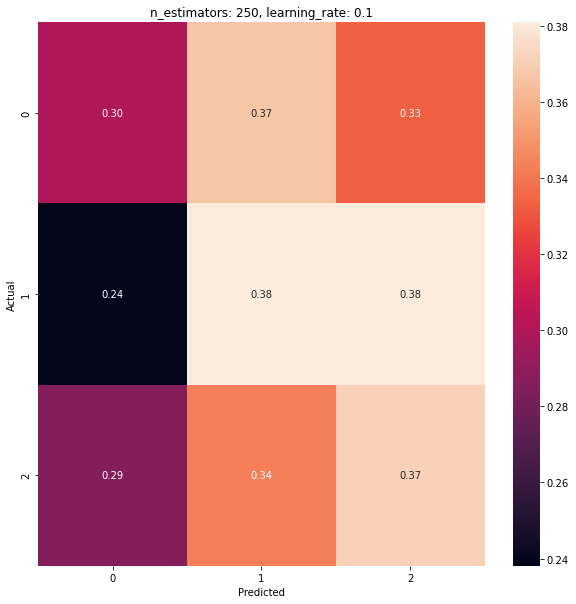

[0]	validation_0-mlogloss:1.10437
[1]	validation_0-mlogloss:1.09846
[2]	validation_0-mlogloss:1.09525
[3]	validation_0-mlogloss:1.10131
[4]	validation_0-mlogloss:1.10533
[5]	validation_0-mlogloss:1.10307
[6]	validation_0-mlogloss:1.10573
[7]	validation_0-mlogloss:1.11502
[8]	validation_0-mlogloss:1.10833
[9]	validation_0-mlogloss:1.11055
[10]	validation_0-mlogloss:1.11112
[11]	validation_0-mlogloss:1.11318
[12]	validation_0-mlogloss:1.11706


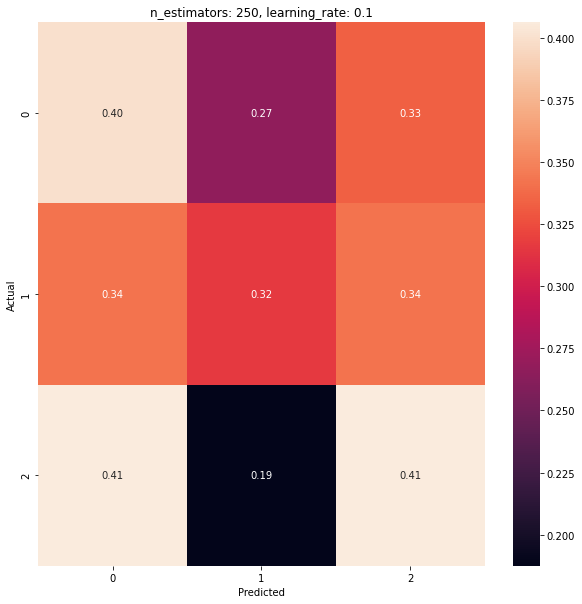

[0]	validation_0-mlogloss:1.08795
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07301
[3]	validation_0-mlogloss:1.06549
[4]	validation_0-mlogloss:1.06049
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05704
[7]	validation_0-mlogloss:1.05613
[8]	validation_0-mlogloss:1.05914
[9]	validation_0-mlogloss:1.05990
[10]	validation_0-mlogloss:1.06619
[11]	validation_0-mlogloss:1.07081
[12]	validation_0-mlogloss:1.07317
[13]	validation_0-mlogloss:1.07471
[14]	validation_0-mlogloss:1.07885
[15]	validation_0-mlogloss:1.07562
[16]	validation_0-mlogloss:1.07781


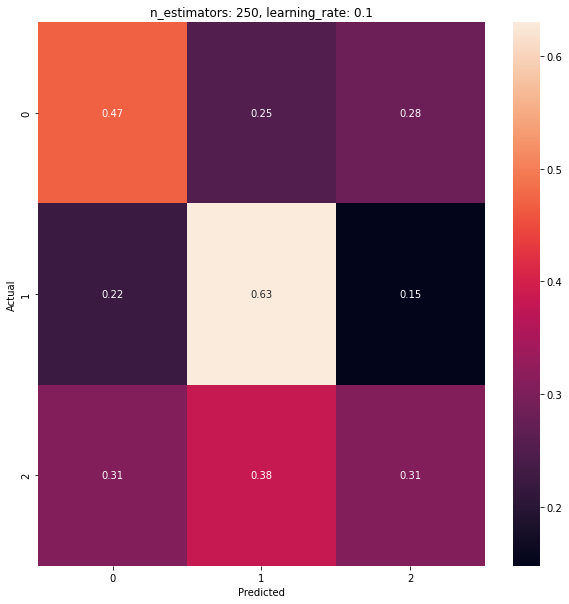

[0]	validation_0-mlogloss:1.09798
[1]	validation_0-mlogloss:1.10043
[2]	validation_0-mlogloss:1.11191
[3]	validation_0-mlogloss:1.11688
[4]	validation_0-mlogloss:1.12780
[5]	validation_0-mlogloss:1.13067
[6]	validation_0-mlogloss:1.13585
[7]	validation_0-mlogloss:1.13626
[8]	validation_0-mlogloss:1.13844
[9]	validation_0-mlogloss:1.14301


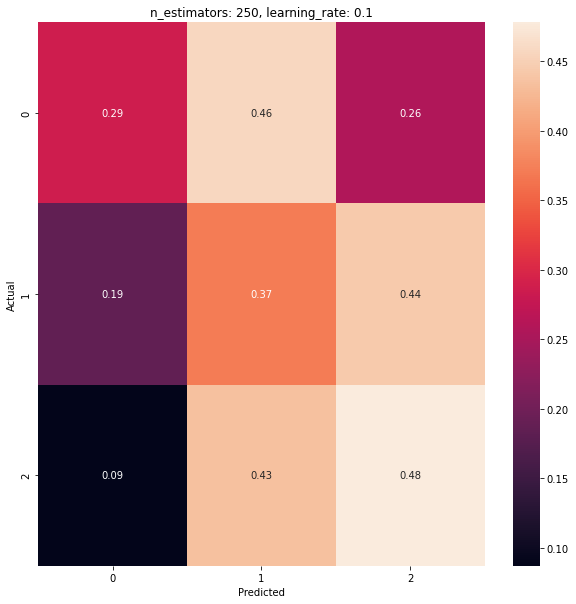

[0]	validation_0-mlogloss:1.09489
[1]	validation_0-mlogloss:1.09319
[2]	validation_0-mlogloss:1.09175
[3]	validation_0-mlogloss:1.09473
[4]	validation_0-mlogloss:1.09655
[5]	validation_0-mlogloss:1.09891
[6]	validation_0-mlogloss:1.09313
[7]	validation_0-mlogloss:1.09663
[8]	validation_0-mlogloss:1.09612
[9]	validation_0-mlogloss:1.09428
[10]	validation_0-mlogloss:1.09100
[11]	validation_0-mlogloss:1.09325
[12]	validation_0-mlogloss:1.09506
[13]	validation_0-mlogloss:1.09566
[14]	validation_0-mlogloss:1.10031
[15]	validation_0-mlogloss:1.09939
[16]	validation_0-mlogloss:1.10318
[17]	validation_0-mlogloss:1.10268
[18]	validation_0-mlogloss:1.10141
[19]	validation_0-mlogloss:1.10802
[20]	validation_0-mlogloss:1.11193


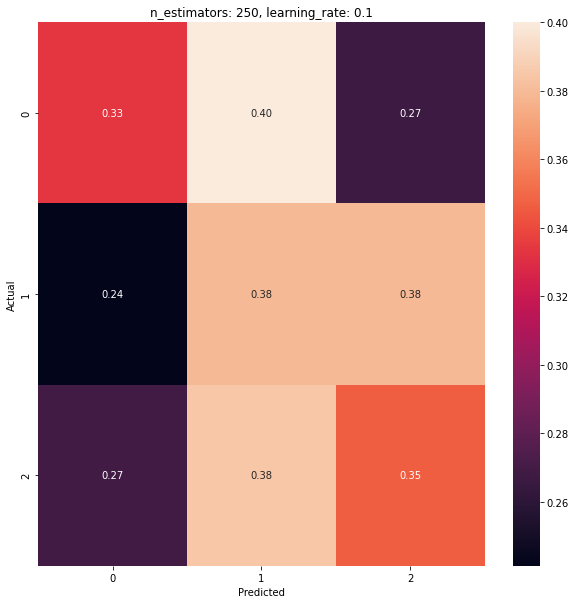

[0]	validation_0-mlogloss:1.09829
[1]	validation_0-mlogloss:1.09856
[2]	validation_0-mlogloss:1.09819
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09766
[5]	validation_0-mlogloss:1.09782
[6]	validation_0-mlogloss:1.09755
[7]	validation_0-mlogloss:1.09811
[8]	validation_0-mlogloss:1.09777
[9]	validation_0-mlogloss:1.09814
[10]	validation_0-mlogloss:1.09834
[11]	validation_0-mlogloss:1.09867
[12]	validation_0-mlogloss:1.09918
[13]	validation_0-mlogloss:1.09916
[14]	validation_0-mlogloss:1.09976
[15]	validation_0-mlogloss:1.10051


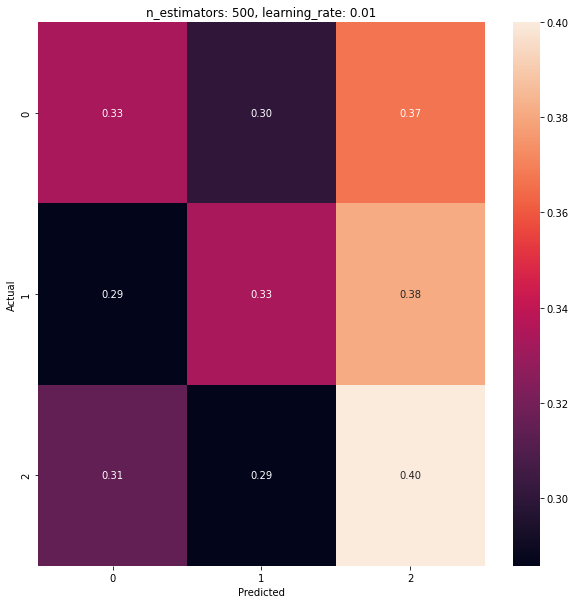

[0]	validation_0-mlogloss:1.09906
[1]	validation_0-mlogloss:1.09866
[2]	validation_0-mlogloss:1.09807
[3]	validation_0-mlogloss:1.09768
[4]	validation_0-mlogloss:1.09793
[5]	validation_0-mlogloss:1.09860
[6]	validation_0-mlogloss:1.09920
[7]	validation_0-mlogloss:1.09852
[8]	validation_0-mlogloss:1.09789
[9]	validation_0-mlogloss:1.09708
[10]	validation_0-mlogloss:1.09676
[11]	validation_0-mlogloss:1.09629
[12]	validation_0-mlogloss:1.09645
[13]	validation_0-mlogloss:1.09589
[14]	validation_0-mlogloss:1.09528
[15]	validation_0-mlogloss:1.09565
[16]	validation_0-mlogloss:1.09559
[17]	validation_0-mlogloss:1.09679
[18]	validation_0-mlogloss:1.09716
[19]	validation_0-mlogloss:1.09731
[20]	validation_0-mlogloss:1.09845
[21]	validation_0-mlogloss:1.09873
[22]	validation_0-mlogloss:1.09999
[23]	validation_0-mlogloss:1.10030


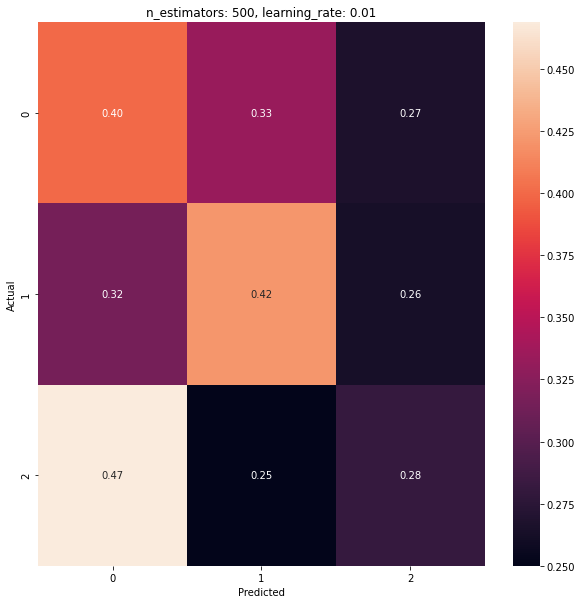

[0]	validation_0-mlogloss:1.09738
[1]	validation_0-mlogloss:1.09697
[2]	validation_0-mlogloss:1.09658
[3]	validation_0-mlogloss:1.09646
[4]	validation_0-mlogloss:1.09573
[5]	validation_0-mlogloss:1.09557
[6]	validation_0-mlogloss:1.09501
[7]	validation_0-mlogloss:1.09426
[8]	validation_0-mlogloss:1.09379
[9]	validation_0-mlogloss:1.09276
[10]	validation_0-mlogloss:1.09217
[11]	validation_0-mlogloss:1.09171
[12]	validation_0-mlogloss:1.09038
[13]	validation_0-mlogloss:1.08957
[14]	validation_0-mlogloss:1.08843
[15]	validation_0-mlogloss:1.08716
[16]	validation_0-mlogloss:1.08662
[17]	validation_0-mlogloss:1.08531
[18]	validation_0-mlogloss:1.08383
[19]	validation_0-mlogloss:1.08246
[20]	validation_0-mlogloss:1.08189
[21]	validation_0-mlogloss:1.08101
[22]	validation_0-mlogloss:1.08013
[23]	validation_0-mlogloss:1.07917
[24]	validation_0-mlogloss:1.07787
[25]	validation_0-mlogloss:1.07712
[26]	validation_0-mlogloss:1.07613
[27]	validation_0-mlogloss:1.07541
[28]	validation_0-mlogloss:1.0

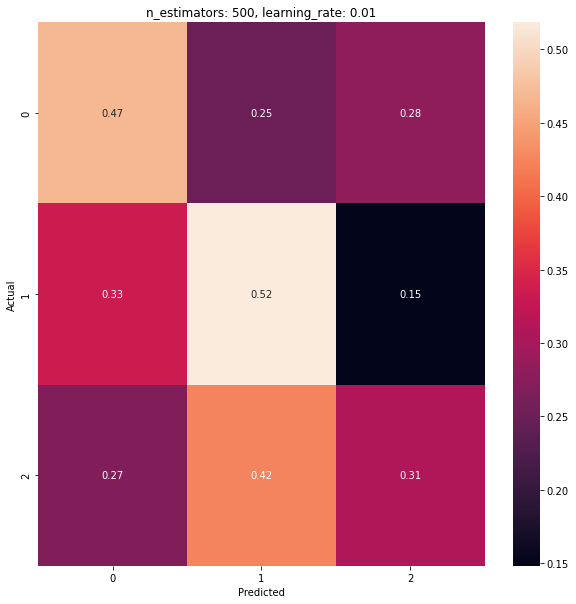

[0]	validation_0-mlogloss:1.09838
[1]	validation_0-mlogloss:1.09799
[2]	validation_0-mlogloss:1.09741
[3]	validation_0-mlogloss:1.09724
[4]	validation_0-mlogloss:1.09715
[5]	validation_0-mlogloss:1.09674
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09661
[8]	validation_0-mlogloss:1.09657
[9]	validation_0-mlogloss:1.09616
[10]	validation_0-mlogloss:1.09672
[11]	validation_0-mlogloss:1.09691
[12]	validation_0-mlogloss:1.09731
[13]	validation_0-mlogloss:1.09763
[14]	validation_0-mlogloss:1.09807
[15]	validation_0-mlogloss:1.09852
[16]	validation_0-mlogloss:1.09884
[17]	validation_0-mlogloss:1.09944
[18]	validation_0-mlogloss:1.09995
[19]	validation_0-mlogloss:1.10070


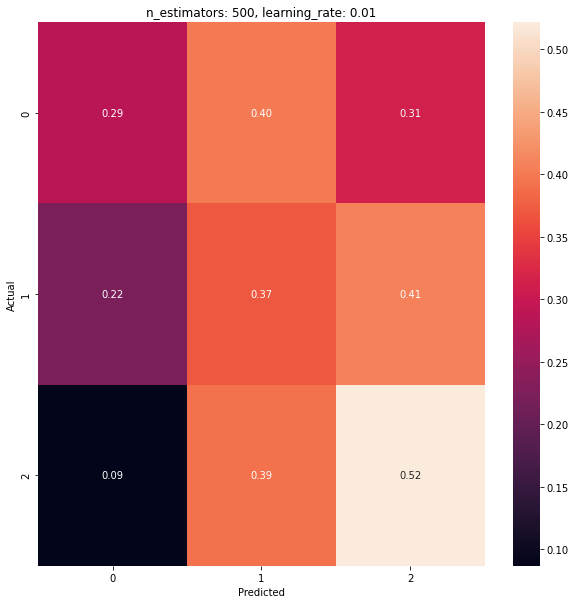

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09750
[2]	validation_0-mlogloss:1.09713
[3]	validation_0-mlogloss:1.09633
[4]	validation_0-mlogloss:1.09577
[5]	validation_0-mlogloss:1.09540
[6]	validation_0-mlogloss:1.09482
[7]	validation_0-mlogloss:1.09403
[8]	validation_0-mlogloss:1.09372
[9]	validation_0-mlogloss:1.09311
[10]	validation_0-mlogloss:1.09256
[11]	validation_0-mlogloss:1.09253
[12]	validation_0-mlogloss:1.09201
[13]	validation_0-mlogloss:1.09127
[14]	validation_0-mlogloss:1.09112
[15]	validation_0-mlogloss:1.09113
[16]	validation_0-mlogloss:1.09078
[17]	validation_0-mlogloss:1.09044
[18]	validation_0-mlogloss:1.09038
[19]	validation_0-mlogloss:1.09063
[20]	validation_0-mlogloss:1.09073
[21]	validation_0-mlogloss:1.09074
[22]	validation_0-mlogloss:1.09034
[23]	validation_0-mlogloss:1.09036
[24]	validation_0-mlogloss:1.09032
[25]	validation_0-mlogloss:1.09038
[26]	validation_0-mlogloss:1.09016
[27]	validation_0-mlogloss:1.09044
[28]	validation_0-mlogloss:1.0

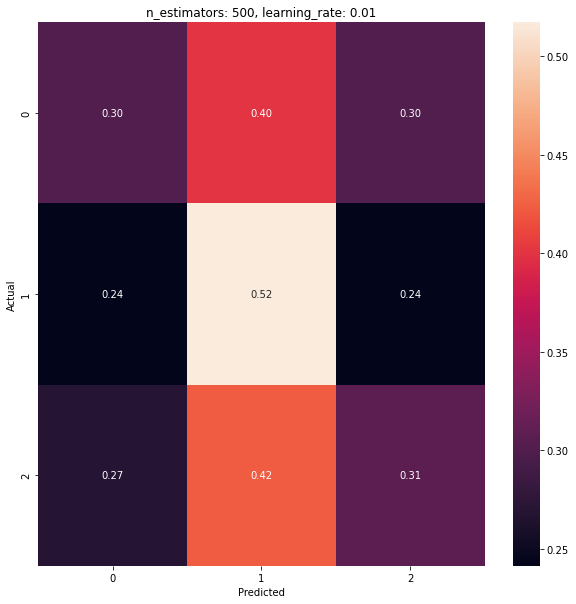

[0]	validation_0-mlogloss:1.09788
[1]	validation_0-mlogloss:1.09841
[2]	validation_0-mlogloss:1.09775
[3]	validation_0-mlogloss:1.09746
[4]	validation_0-mlogloss:1.09851
[5]	validation_0-mlogloss:1.09904
[6]	validation_0-mlogloss:1.10026
[7]	validation_0-mlogloss:1.10109
[8]	validation_0-mlogloss:1.10163
[9]	validation_0-mlogloss:1.10304
[10]	validation_0-mlogloss:1.10478
[11]	validation_0-mlogloss:1.10502
[12]	validation_0-mlogloss:1.10639


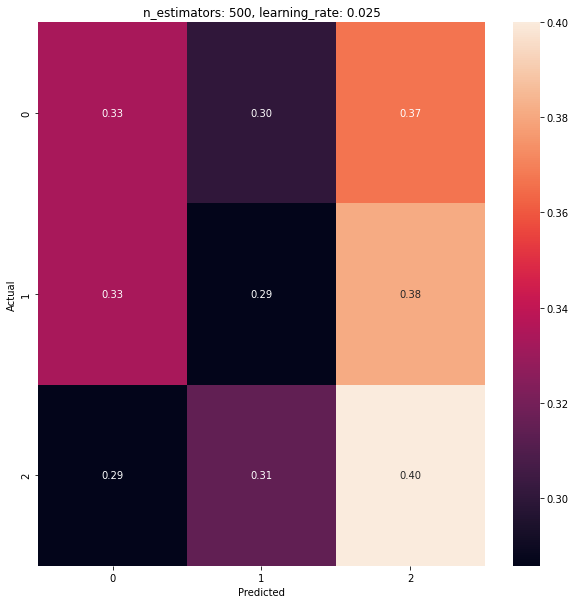

[0]	validation_0-mlogloss:1.09978
[1]	validation_0-mlogloss:1.09891
[2]	validation_0-mlogloss:1.09797
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09908
[5]	validation_0-mlogloss:1.09721
[6]	validation_0-mlogloss:1.09810
[7]	validation_0-mlogloss:1.09851
[8]	validation_0-mlogloss:1.10021
[9]	validation_0-mlogloss:1.10240
[10]	validation_0-mlogloss:1.10294
[11]	validation_0-mlogloss:1.10349
[12]	validation_0-mlogloss:1.10464
[13]	validation_0-mlogloss:1.10368
[14]	validation_0-mlogloss:1.10499
[15]	validation_0-mlogloss:1.10534


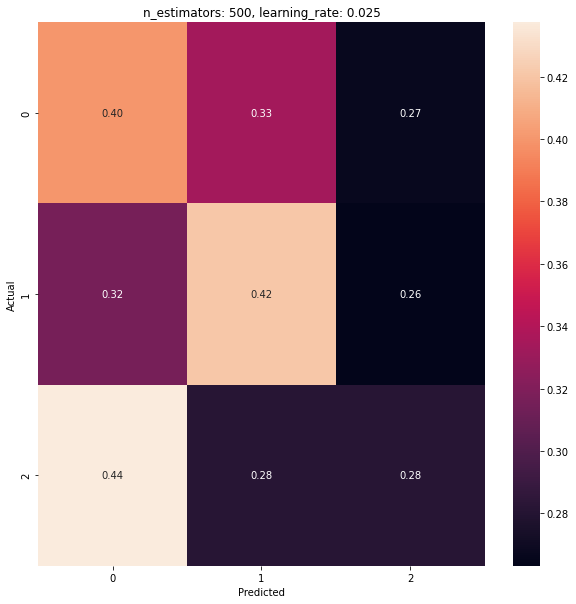

[0]	validation_0-mlogloss:1.09559
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09309
[3]	validation_0-mlogloss:1.09169
[4]	validation_0-mlogloss:1.08951
[5]	validation_0-mlogloss:1.08788
[6]	validation_0-mlogloss:1.08571
[7]	validation_0-mlogloss:1.08218
[8]	validation_0-mlogloss:1.08081
[9]	validation_0-mlogloss:1.07886
[10]	validation_0-mlogloss:1.07640
[11]	validation_0-mlogloss:1.07452
[12]	validation_0-mlogloss:1.07227
[13]	validation_0-mlogloss:1.07052
[14]	validation_0-mlogloss:1.07071
[15]	validation_0-mlogloss:1.06843
[16]	validation_0-mlogloss:1.06816
[17]	validation_0-mlogloss:1.06827
[18]	validation_0-mlogloss:1.06673
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06530
[21]	validation_0-mlogloss:1.06441
[22]	validation_0-mlogloss:1.06342
[23]	validation_0-mlogloss:1.06280
[24]	validation_0-mlogloss:1.06187
[25]	validation_0-mlogloss:1.06193
[26]	validation_0-mlogloss:1.06137
[27]	validation_0-mlogloss:1.06103
[28]	validation_0-mlogloss:1.0

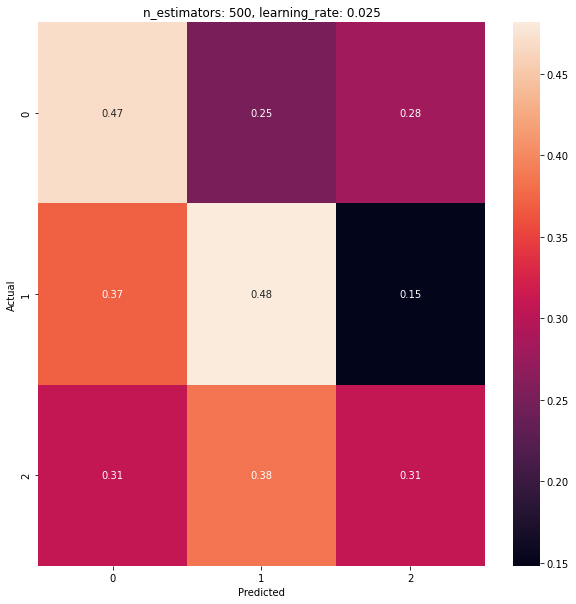

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09758
[2]	validation_0-mlogloss:1.09677
[3]	validation_0-mlogloss:1.09705
[4]	validation_0-mlogloss:1.09740
[5]	validation_0-mlogloss:1.09884
[6]	validation_0-mlogloss:1.09988
[7]	validation_0-mlogloss:1.10149
[8]	validation_0-mlogloss:1.10360
[9]	validation_0-mlogloss:1.10496
[10]	validation_0-mlogloss:1.10622
[11]	validation_0-mlogloss:1.10638


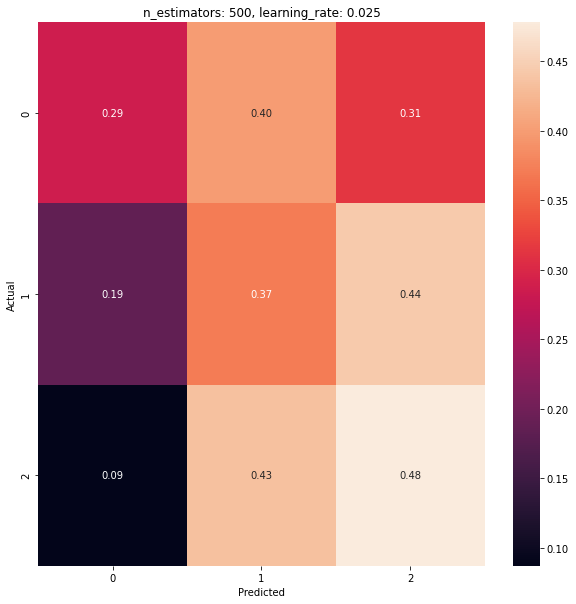

[0]	validation_0-mlogloss:1.09737
[1]	validation_0-mlogloss:1.09590
[2]	validation_0-mlogloss:1.09493
[3]	validation_0-mlogloss:1.09387
[4]	validation_0-mlogloss:1.09285
[5]	validation_0-mlogloss:1.09080
[6]	validation_0-mlogloss:1.08990
[7]	validation_0-mlogloss:1.09032
[8]	validation_0-mlogloss:1.09054
[9]	validation_0-mlogloss:1.09047
[10]	validation_0-mlogloss:1.08970
[11]	validation_0-mlogloss:1.08949
[12]	validation_0-mlogloss:1.08948
[13]	validation_0-mlogloss:1.08969
[14]	validation_0-mlogloss:1.09041
[15]	validation_0-mlogloss:1.09137
[16]	validation_0-mlogloss:1.09135
[17]	validation_0-mlogloss:1.09186
[18]	validation_0-mlogloss:1.09140
[19]	validation_0-mlogloss:1.09212
[20]	validation_0-mlogloss:1.09288
[21]	validation_0-mlogloss:1.09258


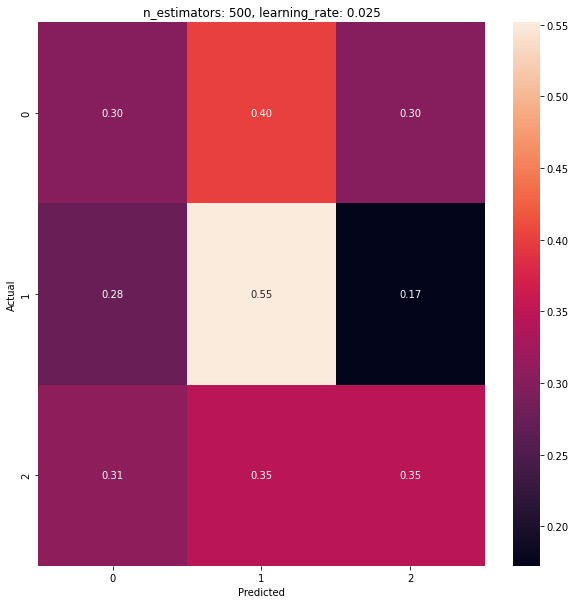

[0]	validation_0-mlogloss:1.09740
[1]	validation_0-mlogloss:1.09911
[2]	validation_0-mlogloss:1.10073
[3]	validation_0-mlogloss:1.10038
[4]	validation_0-mlogloss:1.10323
[5]	validation_0-mlogloss:1.10281
[6]	validation_0-mlogloss:1.10531
[7]	validation_0-mlogloss:1.10876
[8]	validation_0-mlogloss:1.11068
[9]	validation_0-mlogloss:1.11266
[10]	validation_0-mlogloss:1.11642


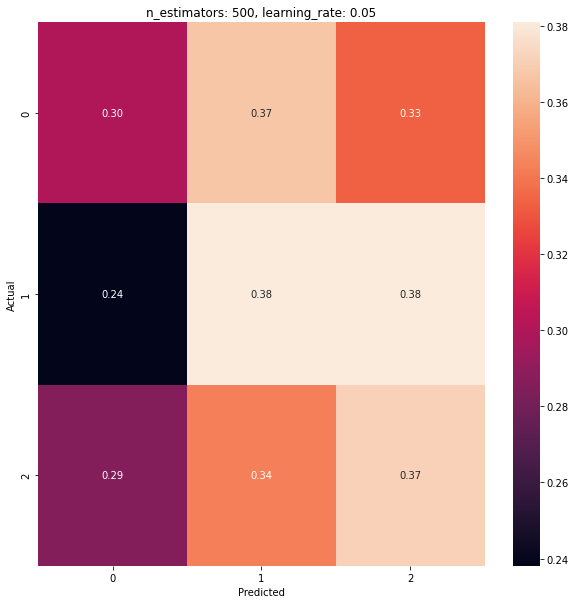

[0]	validation_0-mlogloss:1.10113
[1]	validation_0-mlogloss:1.10013
[2]	validation_0-mlogloss:1.10111
[3]	validation_0-mlogloss:1.09839
[4]	validation_0-mlogloss:1.10285
[5]	validation_0-mlogloss:1.10316
[6]	validation_0-mlogloss:1.10488
[7]	validation_0-mlogloss:1.10410
[8]	validation_0-mlogloss:1.10576
[9]	validation_0-mlogloss:1.10405
[10]	validation_0-mlogloss:1.10492
[11]	validation_0-mlogloss:1.10447
[12]	validation_0-mlogloss:1.10698


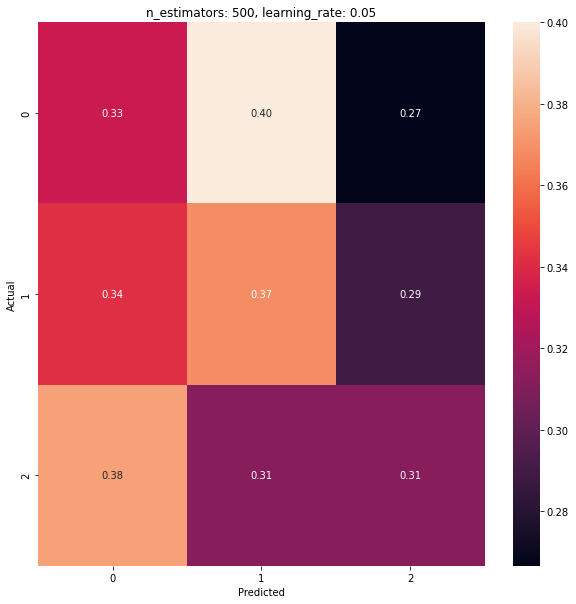

[0]	validation_0-mlogloss:1.09281
[1]	validation_0-mlogloss:1.08971
[2]	validation_0-mlogloss:1.08655
[3]	validation_0-mlogloss:1.08418
[4]	validation_0-mlogloss:1.07656
[5]	validation_0-mlogloss:1.07297
[6]	validation_0-mlogloss:1.06904
[7]	validation_0-mlogloss:1.06581
[8]	validation_0-mlogloss:1.06612
[9]	validation_0-mlogloss:1.06327
[10]	validation_0-mlogloss:1.06027
[11]	validation_0-mlogloss:1.06034
[12]	validation_0-mlogloss:1.06064
[13]	validation_0-mlogloss:1.05975
[14]	validation_0-mlogloss:1.06121
[15]	validation_0-mlogloss:1.06287
[16]	validation_0-mlogloss:1.06382
[17]	validation_0-mlogloss:1.06441
[18]	validation_0-mlogloss:1.06873
[19]	validation_0-mlogloss:1.07052
[20]	validation_0-mlogloss:1.07333
[21]	validation_0-mlogloss:1.07565
[22]	validation_0-mlogloss:1.07767
[23]	validation_0-mlogloss:1.08164


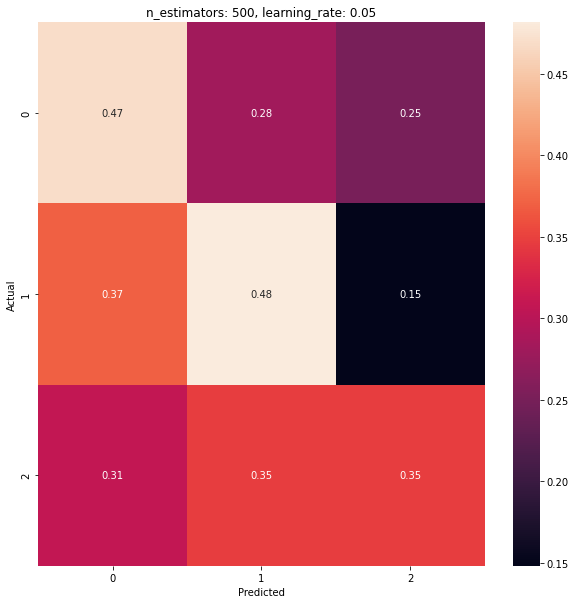

[0]	validation_0-mlogloss:1.09781
[1]	validation_0-mlogloss:1.09764
[2]	validation_0-mlogloss:1.10021
[3]	validation_0-mlogloss:1.10267
[4]	validation_0-mlogloss:1.10874
[5]	validation_0-mlogloss:1.11259
[6]	validation_0-mlogloss:1.11425
[7]	validation_0-mlogloss:1.11787
[8]	validation_0-mlogloss:1.12066
[9]	validation_0-mlogloss:1.12619
[10]	validation_0-mlogloss:1.12930
[11]	validation_0-mlogloss:1.13503


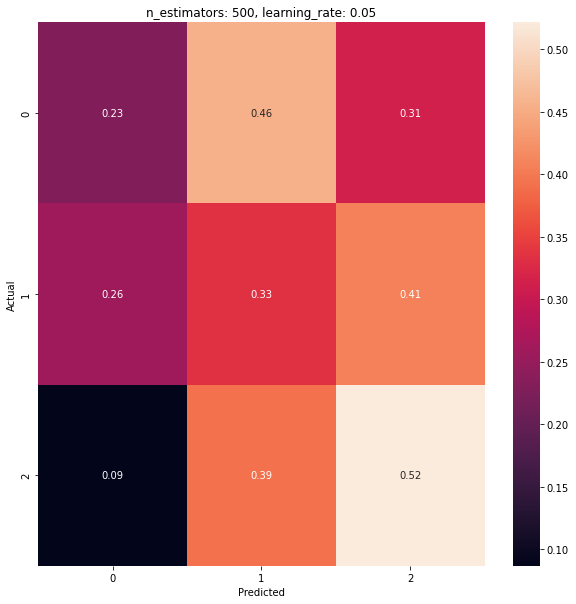

[0]	validation_0-mlogloss:1.09634
[1]	validation_0-mlogloss:1.09444
[2]	validation_0-mlogloss:1.09290
[3]	validation_0-mlogloss:1.09276
[4]	validation_0-mlogloss:1.09197
[5]	validation_0-mlogloss:1.09180
[6]	validation_0-mlogloss:1.09114
[7]	validation_0-mlogloss:1.09111
[8]	validation_0-mlogloss:1.09128
[9]	validation_0-mlogloss:1.09588
[10]	validation_0-mlogloss:1.09280
[11]	validation_0-mlogloss:1.09302
[12]	validation_0-mlogloss:1.08974
[13]	validation_0-mlogloss:1.08843
[14]	validation_0-mlogloss:1.08827
[15]	validation_0-mlogloss:1.08868
[16]	validation_0-mlogloss:1.08605
[17]	validation_0-mlogloss:1.08521
[18]	validation_0-mlogloss:1.08698
[19]	validation_0-mlogloss:1.08856
[20]	validation_0-mlogloss:1.08944
[21]	validation_0-mlogloss:1.09035
[22]	validation_0-mlogloss:1.09231
[23]	validation_0-mlogloss:1.09253
[24]	validation_0-mlogloss:1.09323
[25]	validation_0-mlogloss:1.09434
[26]	validation_0-mlogloss:1.09501
[27]	validation_0-mlogloss:1.09431


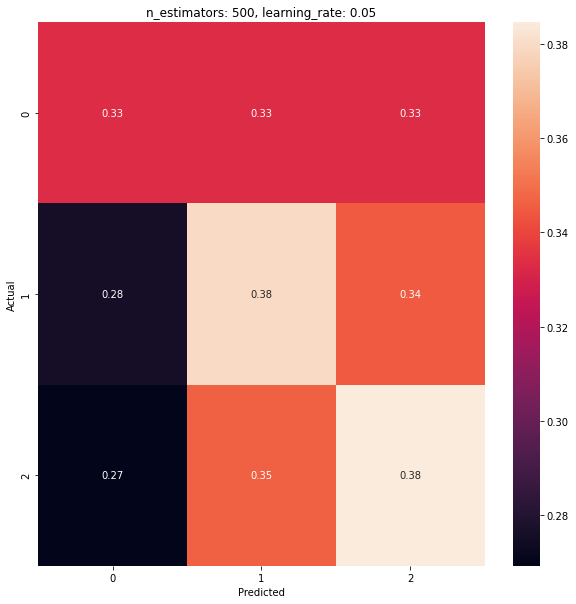

[0]	validation_0-mlogloss:1.09724
[1]	validation_0-mlogloss:1.10274
[2]	validation_0-mlogloss:1.10457
[3]	validation_0-mlogloss:1.11642
[4]	validation_0-mlogloss:1.12113
[5]	validation_0-mlogloss:1.12194
[6]	validation_0-mlogloss:1.12291
[7]	validation_0-mlogloss:1.12334
[8]	validation_0-mlogloss:1.12568
[9]	validation_0-mlogloss:1.13071


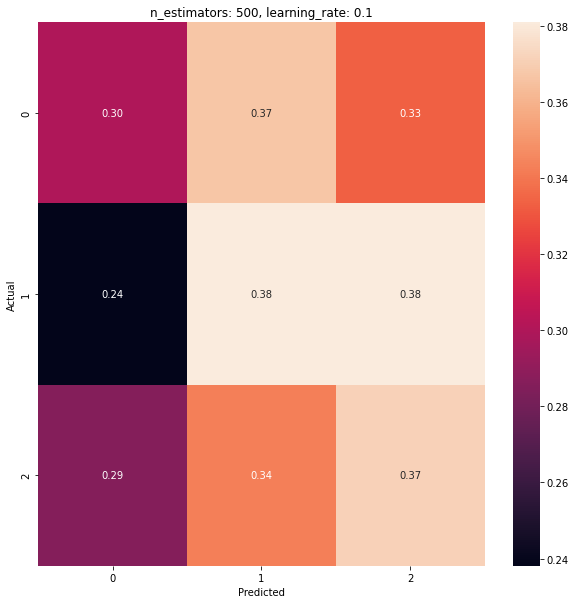

[0]	validation_0-mlogloss:1.10437
[1]	validation_0-mlogloss:1.09846
[2]	validation_0-mlogloss:1.09525
[3]	validation_0-mlogloss:1.10131
[4]	validation_0-mlogloss:1.10533
[5]	validation_0-mlogloss:1.10307
[6]	validation_0-mlogloss:1.10573
[7]	validation_0-mlogloss:1.11502
[8]	validation_0-mlogloss:1.10833
[9]	validation_0-mlogloss:1.11055
[10]	validation_0-mlogloss:1.11112
[11]	validation_0-mlogloss:1.11318


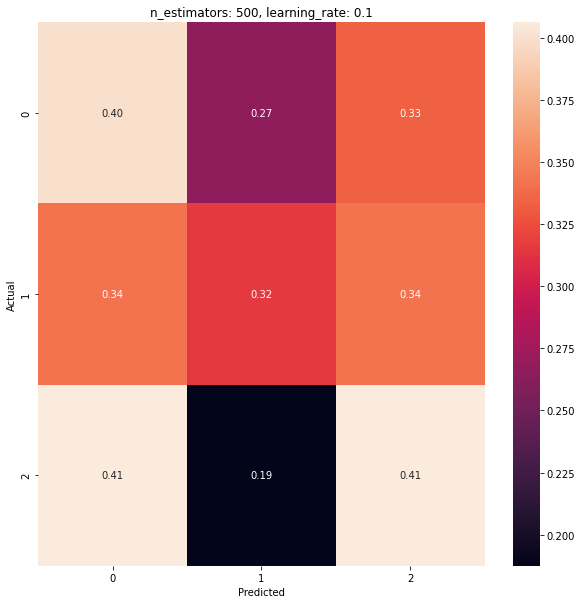

[0]	validation_0-mlogloss:1.08795
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07301
[3]	validation_0-mlogloss:1.06549
[4]	validation_0-mlogloss:1.06049
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05704
[7]	validation_0-mlogloss:1.05613
[8]	validation_0-mlogloss:1.05914
[9]	validation_0-mlogloss:1.05990
[10]	validation_0-mlogloss:1.06619
[11]	validation_0-mlogloss:1.07081
[12]	validation_0-mlogloss:1.07317
[13]	validation_0-mlogloss:1.07471
[14]	validation_0-mlogloss:1.07885
[15]	validation_0-mlogloss:1.07562
[16]	validation_0-mlogloss:1.07781


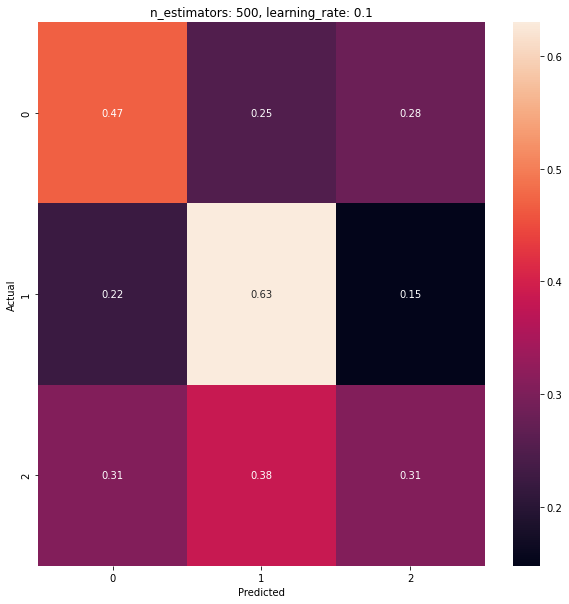

[0]	validation_0-mlogloss:1.09798
[1]	validation_0-mlogloss:1.10043
[2]	validation_0-mlogloss:1.11191
[3]	validation_0-mlogloss:1.11688
[4]	validation_0-mlogloss:1.12780
[5]	validation_0-mlogloss:1.13067
[6]	validation_0-mlogloss:1.13585
[7]	validation_0-mlogloss:1.13626
[8]	validation_0-mlogloss:1.13844
[9]	validation_0-mlogloss:1.14301


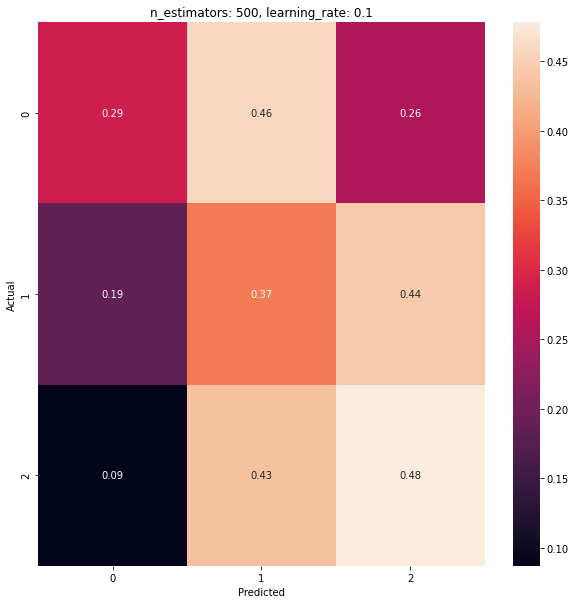

[0]	validation_0-mlogloss:1.09489
[1]	validation_0-mlogloss:1.09319
[2]	validation_0-mlogloss:1.09175
[3]	validation_0-mlogloss:1.09473
[4]	validation_0-mlogloss:1.09655
[5]	validation_0-mlogloss:1.09891
[6]	validation_0-mlogloss:1.09313
[7]	validation_0-mlogloss:1.09663
[8]	validation_0-mlogloss:1.09612
[9]	validation_0-mlogloss:1.09428
[10]	validation_0-mlogloss:1.09100
[11]	validation_0-mlogloss:1.09325
[12]	validation_0-mlogloss:1.09506
[13]	validation_0-mlogloss:1.09566
[14]	validation_0-mlogloss:1.10031
[15]	validation_0-mlogloss:1.09939
[16]	validation_0-mlogloss:1.10318
[17]	validation_0-mlogloss:1.10268
[18]	validation_0-mlogloss:1.10141
[19]	validation_0-mlogloss:1.10802
[20]	validation_0-mlogloss:1.11193


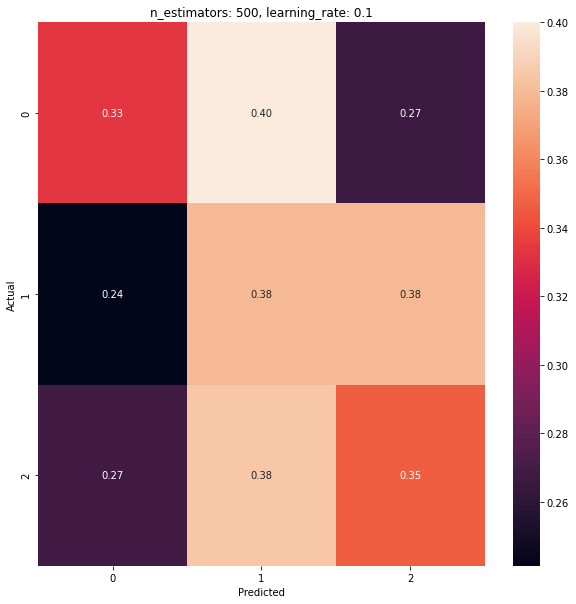

[0]	validation_0-mlogloss:1.09829
[1]	validation_0-mlogloss:1.09856
[2]	validation_0-mlogloss:1.09819
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09766
[5]	validation_0-mlogloss:1.09782
[6]	validation_0-mlogloss:1.09755
[7]	validation_0-mlogloss:1.09811
[8]	validation_0-mlogloss:1.09777
[9]	validation_0-mlogloss:1.09814
[10]	validation_0-mlogloss:1.09834
[11]	validation_0-mlogloss:1.09867
[12]	validation_0-mlogloss:1.09918
[13]	validation_0-mlogloss:1.09916
[14]	validation_0-mlogloss:1.09976
[15]	validation_0-mlogloss:1.10051
[16]	validation_0-mlogloss:1.10089


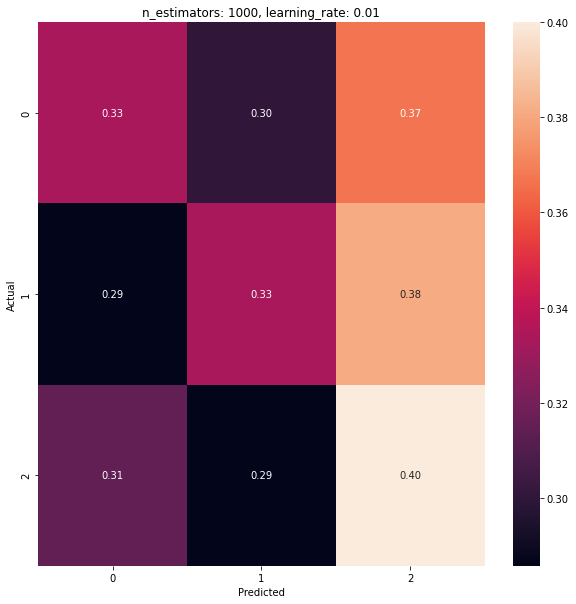

[0]	validation_0-mlogloss:1.09906
[1]	validation_0-mlogloss:1.09866
[2]	validation_0-mlogloss:1.09807
[3]	validation_0-mlogloss:1.09768
[4]	validation_0-mlogloss:1.09793
[5]	validation_0-mlogloss:1.09860
[6]	validation_0-mlogloss:1.09920
[7]	validation_0-mlogloss:1.09852
[8]	validation_0-mlogloss:1.09789
[9]	validation_0-mlogloss:1.09708
[10]	validation_0-mlogloss:1.09676
[11]	validation_0-mlogloss:1.09629
[12]	validation_0-mlogloss:1.09645
[13]	validation_0-mlogloss:1.09589
[14]	validation_0-mlogloss:1.09528
[15]	validation_0-mlogloss:1.09565
[16]	validation_0-mlogloss:1.09559
[17]	validation_0-mlogloss:1.09679
[18]	validation_0-mlogloss:1.09716
[19]	validation_0-mlogloss:1.09731
[20]	validation_0-mlogloss:1.09845
[21]	validation_0-mlogloss:1.09873
[22]	validation_0-mlogloss:1.09999
[23]	validation_0-mlogloss:1.10030
[24]	validation_0-mlogloss:1.10076


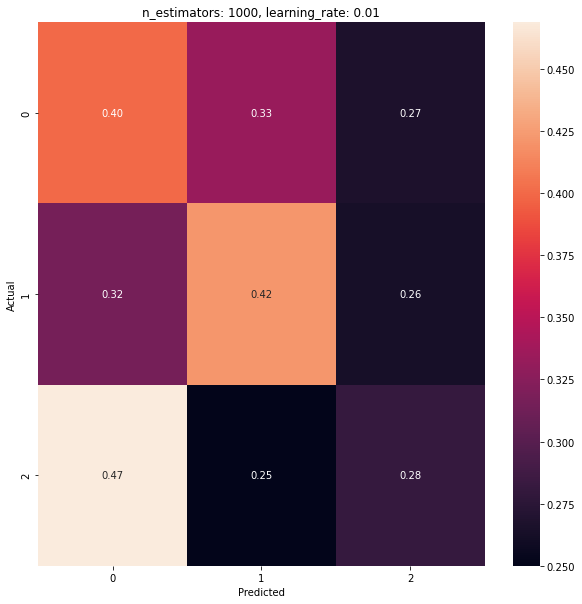

[0]	validation_0-mlogloss:1.09738
[1]	validation_0-mlogloss:1.09697
[2]	validation_0-mlogloss:1.09658
[3]	validation_0-mlogloss:1.09646
[4]	validation_0-mlogloss:1.09573
[5]	validation_0-mlogloss:1.09557
[6]	validation_0-mlogloss:1.09501
[7]	validation_0-mlogloss:1.09426
[8]	validation_0-mlogloss:1.09379
[9]	validation_0-mlogloss:1.09276
[10]	validation_0-mlogloss:1.09217
[11]	validation_0-mlogloss:1.09171
[12]	validation_0-mlogloss:1.09038
[13]	validation_0-mlogloss:1.08957
[14]	validation_0-mlogloss:1.08843
[15]	validation_0-mlogloss:1.08716
[16]	validation_0-mlogloss:1.08662
[17]	validation_0-mlogloss:1.08531
[18]	validation_0-mlogloss:1.08383
[19]	validation_0-mlogloss:1.08246
[20]	validation_0-mlogloss:1.08189
[21]	validation_0-mlogloss:1.08101
[22]	validation_0-mlogloss:1.08013
[23]	validation_0-mlogloss:1.07917
[24]	validation_0-mlogloss:1.07787
[25]	validation_0-mlogloss:1.07712
[26]	validation_0-mlogloss:1.07613
[27]	validation_0-mlogloss:1.07541
[28]	validation_0-mlogloss:1.0

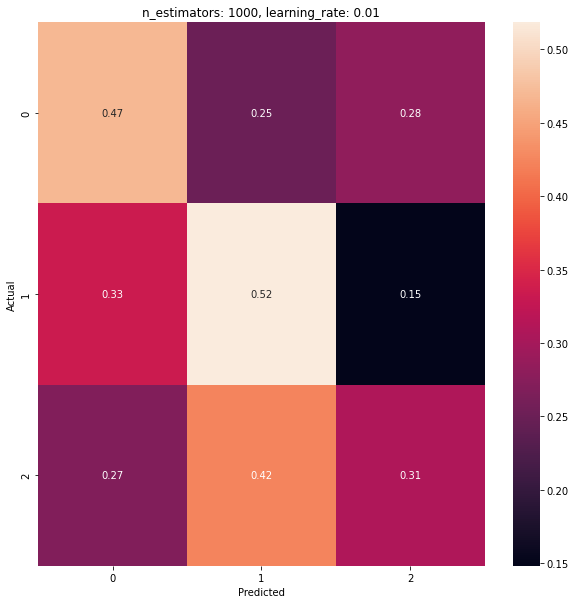

[0]	validation_0-mlogloss:1.09838
[1]	validation_0-mlogloss:1.09799
[2]	validation_0-mlogloss:1.09741
[3]	validation_0-mlogloss:1.09724
[4]	validation_0-mlogloss:1.09715
[5]	validation_0-mlogloss:1.09674
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09661
[8]	validation_0-mlogloss:1.09657
[9]	validation_0-mlogloss:1.09616
[10]	validation_0-mlogloss:1.09672
[11]	validation_0-mlogloss:1.09691
[12]	validation_0-mlogloss:1.09731
[13]	validation_0-mlogloss:1.09763
[14]	validation_0-mlogloss:1.09807
[15]	validation_0-mlogloss:1.09852
[16]	validation_0-mlogloss:1.09884
[17]	validation_0-mlogloss:1.09944
[18]	validation_0-mlogloss:1.09995
[19]	validation_0-mlogloss:1.10070


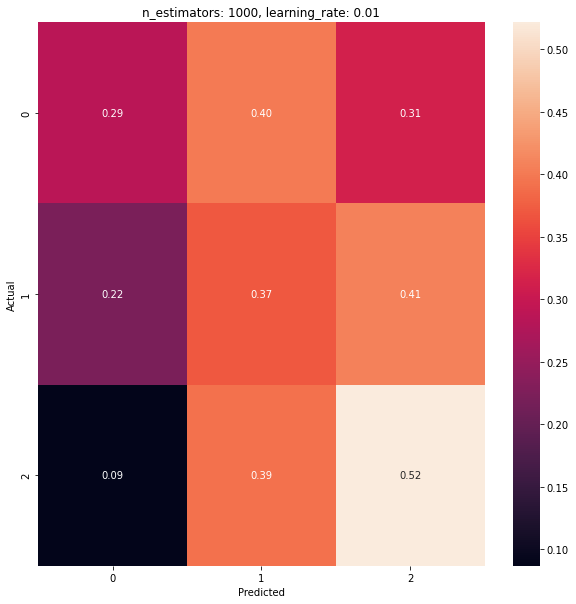

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09750
[2]	validation_0-mlogloss:1.09713
[3]	validation_0-mlogloss:1.09633
[4]	validation_0-mlogloss:1.09577
[5]	validation_0-mlogloss:1.09540
[6]	validation_0-mlogloss:1.09482
[7]	validation_0-mlogloss:1.09403
[8]	validation_0-mlogloss:1.09372
[9]	validation_0-mlogloss:1.09311
[10]	validation_0-mlogloss:1.09256
[11]	validation_0-mlogloss:1.09253
[12]	validation_0-mlogloss:1.09201
[13]	validation_0-mlogloss:1.09127
[14]	validation_0-mlogloss:1.09112
[15]	validation_0-mlogloss:1.09113
[16]	validation_0-mlogloss:1.09078
[17]	validation_0-mlogloss:1.09044
[18]	validation_0-mlogloss:1.09038
[19]	validation_0-mlogloss:1.09063
[20]	validation_0-mlogloss:1.09073
[21]	validation_0-mlogloss:1.09074
[22]	validation_0-mlogloss:1.09034
[23]	validation_0-mlogloss:1.09036
[24]	validation_0-mlogloss:1.09032
[25]	validation_0-mlogloss:1.09038
[26]	validation_0-mlogloss:1.09016
[27]	validation_0-mlogloss:1.09044
[28]	validation_0-mlogloss:1.0

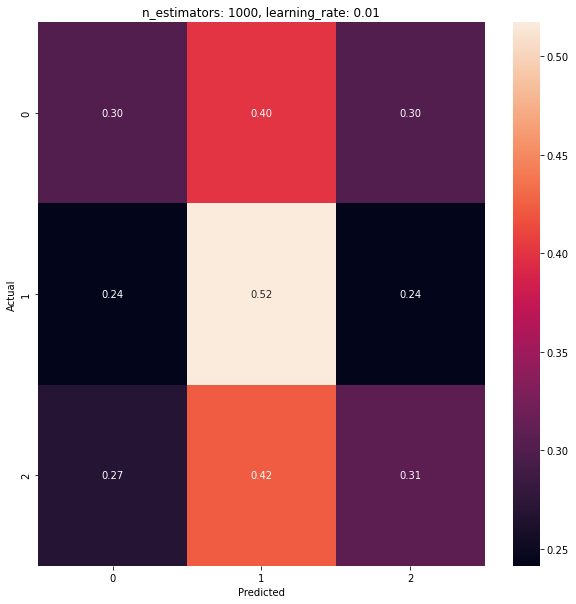

[0]	validation_0-mlogloss:1.09788
[1]	validation_0-mlogloss:1.09841
[2]	validation_0-mlogloss:1.09775
[3]	validation_0-mlogloss:1.09746
[4]	validation_0-mlogloss:1.09851
[5]	validation_0-mlogloss:1.09904
[6]	validation_0-mlogloss:1.10026
[7]	validation_0-mlogloss:1.10109
[8]	validation_0-mlogloss:1.10163
[9]	validation_0-mlogloss:1.10304
[10]	validation_0-mlogloss:1.10478
[11]	validation_0-mlogloss:1.10502
[12]	validation_0-mlogloss:1.10639
[13]	validation_0-mlogloss:1.10949


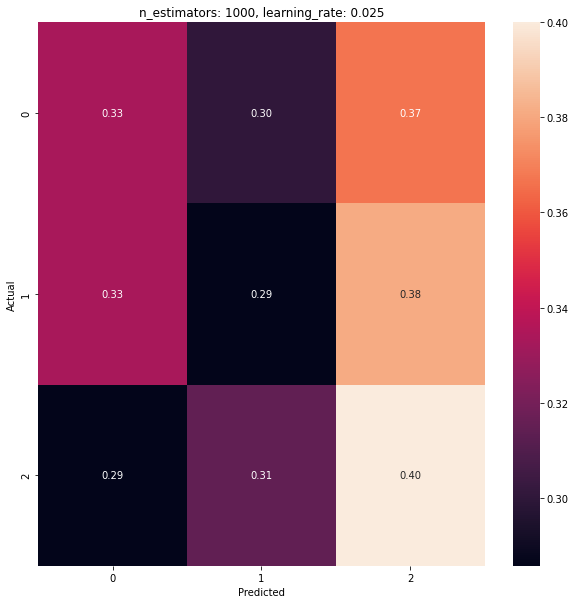

[0]	validation_0-mlogloss:1.09978
[1]	validation_0-mlogloss:1.09891
[2]	validation_0-mlogloss:1.09797
[3]	validation_0-mlogloss:1.09808
[4]	validation_0-mlogloss:1.09908
[5]	validation_0-mlogloss:1.09721
[6]	validation_0-mlogloss:1.09810
[7]	validation_0-mlogloss:1.09851
[8]	validation_0-mlogloss:1.10021
[9]	validation_0-mlogloss:1.10240
[10]	validation_0-mlogloss:1.10294
[11]	validation_0-mlogloss:1.10349
[12]	validation_0-mlogloss:1.10464
[13]	validation_0-mlogloss:1.10368
[14]	validation_0-mlogloss:1.10499


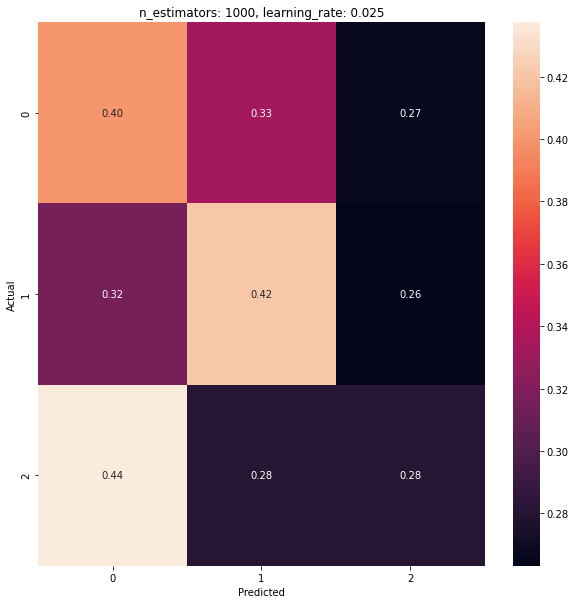

[0]	validation_0-mlogloss:1.09559
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09309
[3]	validation_0-mlogloss:1.09169
[4]	validation_0-mlogloss:1.08951
[5]	validation_0-mlogloss:1.08788
[6]	validation_0-mlogloss:1.08571
[7]	validation_0-mlogloss:1.08218
[8]	validation_0-mlogloss:1.08081
[9]	validation_0-mlogloss:1.07886
[10]	validation_0-mlogloss:1.07640
[11]	validation_0-mlogloss:1.07452
[12]	validation_0-mlogloss:1.07227
[13]	validation_0-mlogloss:1.07052
[14]	validation_0-mlogloss:1.07071
[15]	validation_0-mlogloss:1.06843
[16]	validation_0-mlogloss:1.06816
[17]	validation_0-mlogloss:1.06827
[18]	validation_0-mlogloss:1.06673
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06530
[21]	validation_0-mlogloss:1.06441
[22]	validation_0-mlogloss:1.06342
[23]	validation_0-mlogloss:1.06280
[24]	validation_0-mlogloss:1.06187
[25]	validation_0-mlogloss:1.06193
[26]	validation_0-mlogloss:1.06137
[27]	validation_0-mlogloss:1.06103
[28]	validation_0-mlogloss:1.0

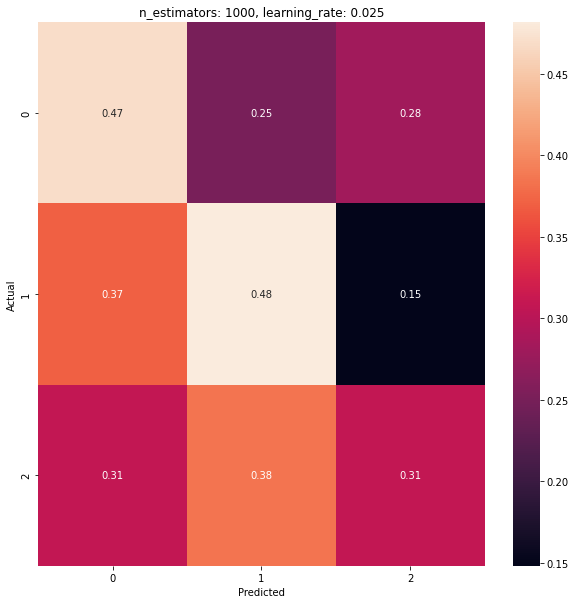

[0]	validation_0-mlogloss:1.09809
[1]	validation_0-mlogloss:1.09758
[2]	validation_0-mlogloss:1.09677
[3]	validation_0-mlogloss:1.09705
[4]	validation_0-mlogloss:1.09740
[5]	validation_0-mlogloss:1.09884
[6]	validation_0-mlogloss:1.09988
[7]	validation_0-mlogloss:1.10149
[8]	validation_0-mlogloss:1.10360
[9]	validation_0-mlogloss:1.10496
[10]	validation_0-mlogloss:1.10622
[11]	validation_0-mlogloss:1.10638
[12]	validation_0-mlogloss:1.10787


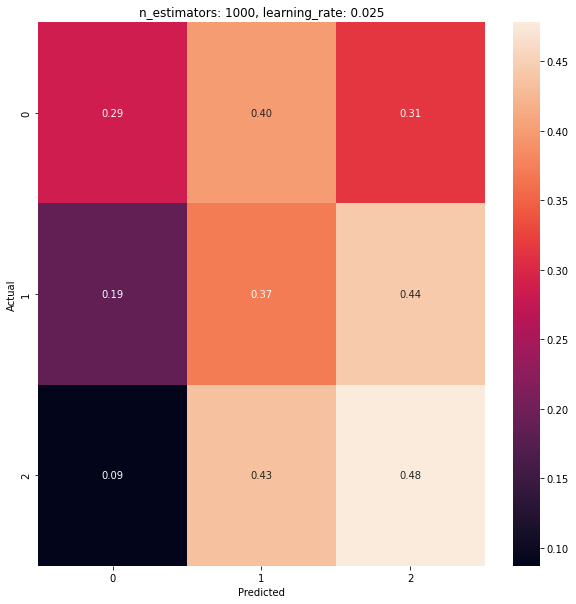

[0]	validation_0-mlogloss:1.09737
[1]	validation_0-mlogloss:1.09590
[2]	validation_0-mlogloss:1.09493
[3]	validation_0-mlogloss:1.09387
[4]	validation_0-mlogloss:1.09285
[5]	validation_0-mlogloss:1.09080
[6]	validation_0-mlogloss:1.08990
[7]	validation_0-mlogloss:1.09032
[8]	validation_0-mlogloss:1.09054
[9]	validation_0-mlogloss:1.09047
[10]	validation_0-mlogloss:1.08970
[11]	validation_0-mlogloss:1.08949
[12]	validation_0-mlogloss:1.08948
[13]	validation_0-mlogloss:1.08969
[14]	validation_0-mlogloss:1.09041
[15]	validation_0-mlogloss:1.09137
[16]	validation_0-mlogloss:1.09135
[17]	validation_0-mlogloss:1.09186
[18]	validation_0-mlogloss:1.09140
[19]	validation_0-mlogloss:1.09212
[20]	validation_0-mlogloss:1.09288
[21]	validation_0-mlogloss:1.09258
[22]	validation_0-mlogloss:1.09306


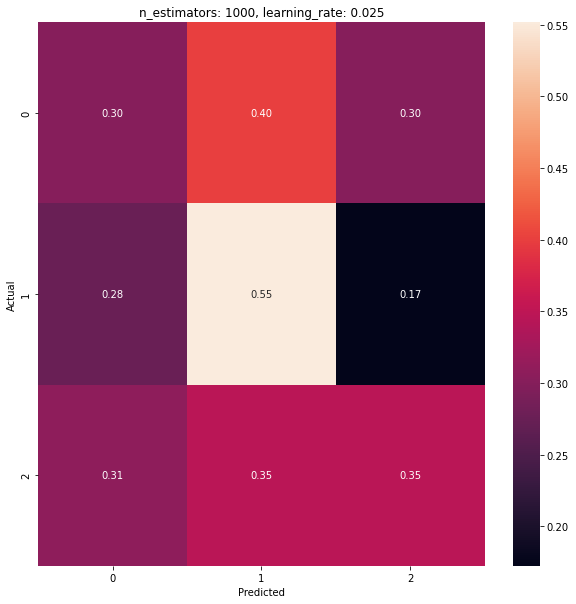

[0]	validation_0-mlogloss:1.09740
[1]	validation_0-mlogloss:1.09911
[2]	validation_0-mlogloss:1.10073
[3]	validation_0-mlogloss:1.10038
[4]	validation_0-mlogloss:1.10323
[5]	validation_0-mlogloss:1.10281
[6]	validation_0-mlogloss:1.10531
[7]	validation_0-mlogloss:1.10876
[8]	validation_0-mlogloss:1.11068
[9]	validation_0-mlogloss:1.11266
[10]	validation_0-mlogloss:1.11642


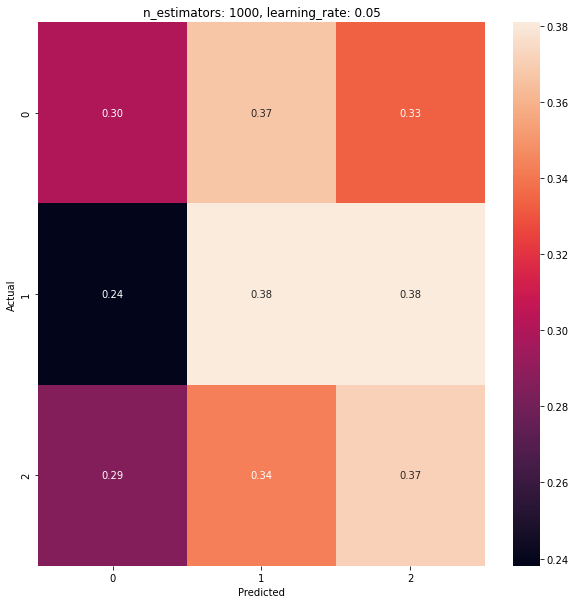

[0]	validation_0-mlogloss:1.10113
[1]	validation_0-mlogloss:1.10013
[2]	validation_0-mlogloss:1.10111
[3]	validation_0-mlogloss:1.09839
[4]	validation_0-mlogloss:1.10285
[5]	validation_0-mlogloss:1.10316
[6]	validation_0-mlogloss:1.10488
[7]	validation_0-mlogloss:1.10410
[8]	validation_0-mlogloss:1.10576
[9]	validation_0-mlogloss:1.10405
[10]	validation_0-mlogloss:1.10492
[11]	validation_0-mlogloss:1.10447
[12]	validation_0-mlogloss:1.10698


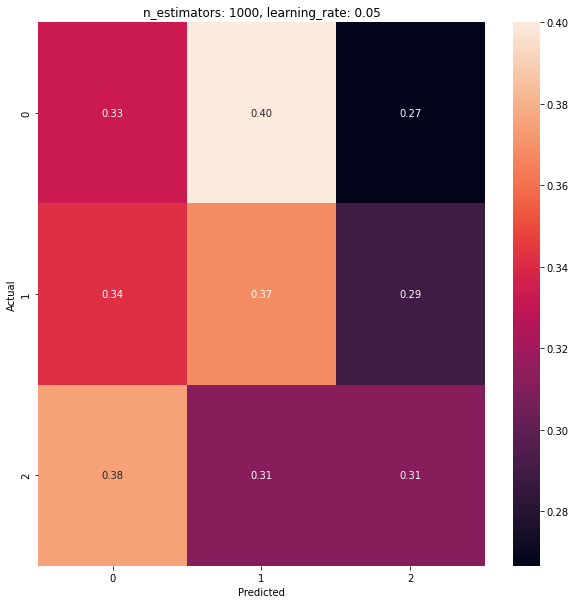

[0]	validation_0-mlogloss:1.09281
[1]	validation_0-mlogloss:1.08971
[2]	validation_0-mlogloss:1.08655
[3]	validation_0-mlogloss:1.08418
[4]	validation_0-mlogloss:1.07656
[5]	validation_0-mlogloss:1.07297
[6]	validation_0-mlogloss:1.06904
[7]	validation_0-mlogloss:1.06581
[8]	validation_0-mlogloss:1.06612
[9]	validation_0-mlogloss:1.06327
[10]	validation_0-mlogloss:1.06027
[11]	validation_0-mlogloss:1.06034
[12]	validation_0-mlogloss:1.06064
[13]	validation_0-mlogloss:1.05975
[14]	validation_0-mlogloss:1.06121
[15]	validation_0-mlogloss:1.06287
[16]	validation_0-mlogloss:1.06382
[17]	validation_0-mlogloss:1.06441
[18]	validation_0-mlogloss:1.06873
[19]	validation_0-mlogloss:1.07052
[20]	validation_0-mlogloss:1.07333
[21]	validation_0-mlogloss:1.07565
[22]	validation_0-mlogloss:1.07767
[23]	validation_0-mlogloss:1.08164


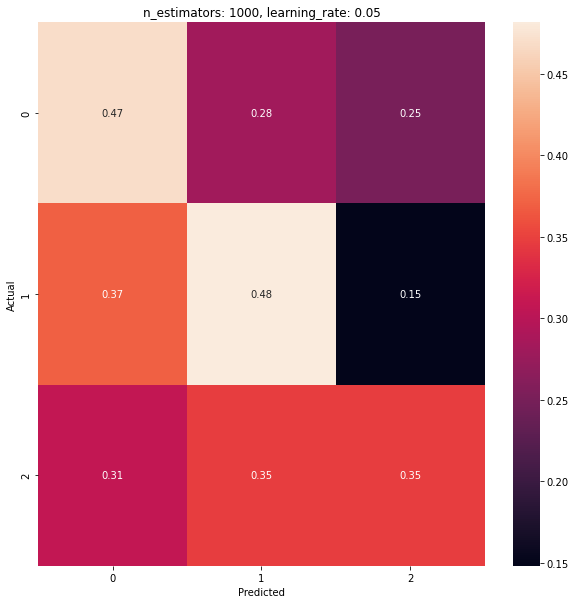

[0]	validation_0-mlogloss:1.09781
[1]	validation_0-mlogloss:1.09764
[2]	validation_0-mlogloss:1.10021
[3]	validation_0-mlogloss:1.10267
[4]	validation_0-mlogloss:1.10874
[5]	validation_0-mlogloss:1.11259
[6]	validation_0-mlogloss:1.11425
[7]	validation_0-mlogloss:1.11787
[8]	validation_0-mlogloss:1.12066
[9]	validation_0-mlogloss:1.12619
[10]	validation_0-mlogloss:1.12930
[11]	validation_0-mlogloss:1.13503


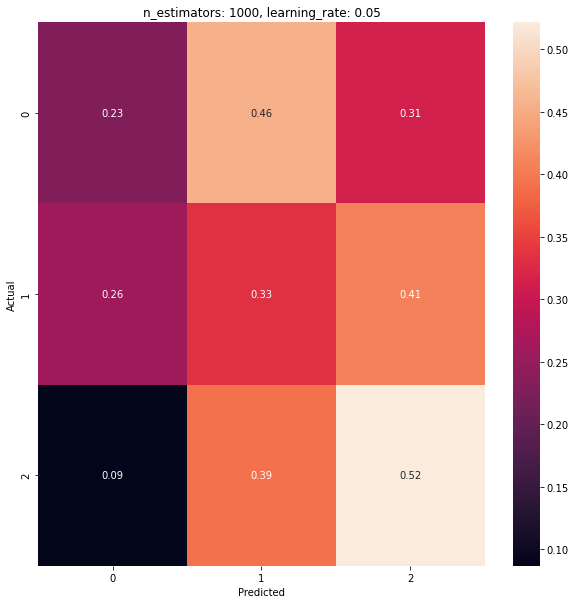

[0]	validation_0-mlogloss:1.09634
[1]	validation_0-mlogloss:1.09444
[2]	validation_0-mlogloss:1.09290
[3]	validation_0-mlogloss:1.09276
[4]	validation_0-mlogloss:1.09197
[5]	validation_0-mlogloss:1.09180
[6]	validation_0-mlogloss:1.09114
[7]	validation_0-mlogloss:1.09111
[8]	validation_0-mlogloss:1.09128
[9]	validation_0-mlogloss:1.09588
[10]	validation_0-mlogloss:1.09280
[11]	validation_0-mlogloss:1.09302
[12]	validation_0-mlogloss:1.08974
[13]	validation_0-mlogloss:1.08843
[14]	validation_0-mlogloss:1.08827
[15]	validation_0-mlogloss:1.08868
[16]	validation_0-mlogloss:1.08605
[17]	validation_0-mlogloss:1.08521
[18]	validation_0-mlogloss:1.08698
[19]	validation_0-mlogloss:1.08856
[20]	validation_0-mlogloss:1.08944
[21]	validation_0-mlogloss:1.09035
[22]	validation_0-mlogloss:1.09231
[23]	validation_0-mlogloss:1.09253
[24]	validation_0-mlogloss:1.09323
[25]	validation_0-mlogloss:1.09434
[26]	validation_0-mlogloss:1.09501


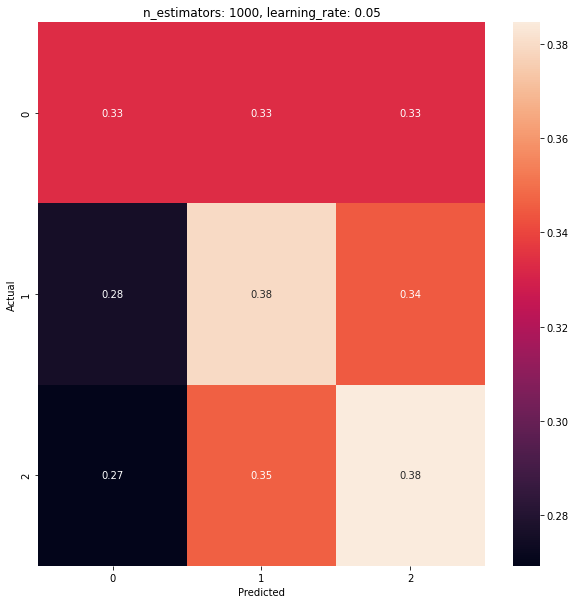

[0]	validation_0-mlogloss:1.09724
[1]	validation_0-mlogloss:1.10274
[2]	validation_0-mlogloss:1.10457
[3]	validation_0-mlogloss:1.11642
[4]	validation_0-mlogloss:1.12113
[5]	validation_0-mlogloss:1.12194
[6]	validation_0-mlogloss:1.12291
[7]	validation_0-mlogloss:1.12334
[8]	validation_0-mlogloss:1.12568
[9]	validation_0-mlogloss:1.13071


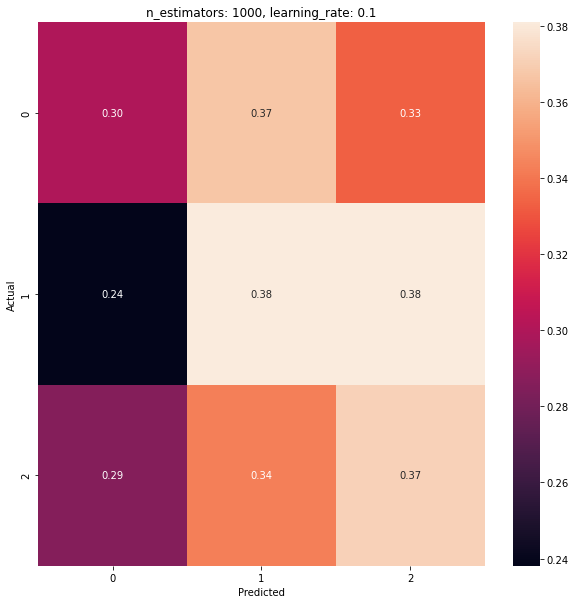

[0]	validation_0-mlogloss:1.10437
[1]	validation_0-mlogloss:1.09846
[2]	validation_0-mlogloss:1.09525
[3]	validation_0-mlogloss:1.10131
[4]	validation_0-mlogloss:1.10533
[5]	validation_0-mlogloss:1.10307
[6]	validation_0-mlogloss:1.10573
[7]	validation_0-mlogloss:1.11502
[8]	validation_0-mlogloss:1.10833
[9]	validation_0-mlogloss:1.11055
[10]	validation_0-mlogloss:1.11112
[11]	validation_0-mlogloss:1.11318


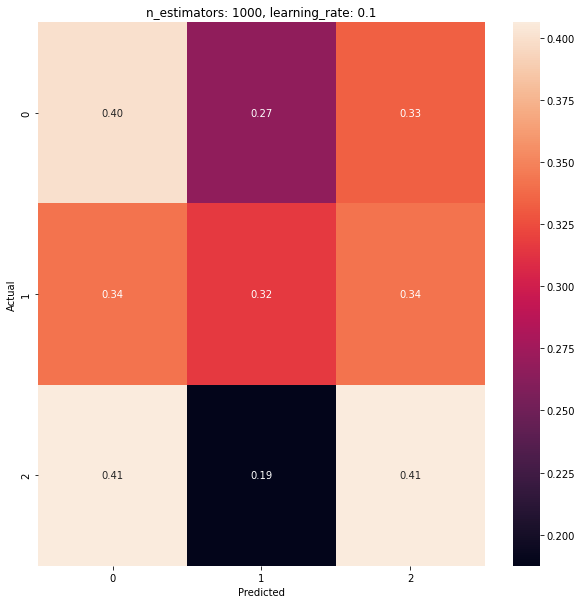

[0]	validation_0-mlogloss:1.08795
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07301
[3]	validation_0-mlogloss:1.06549
[4]	validation_0-mlogloss:1.06049
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05704
[7]	validation_0-mlogloss:1.05613
[8]	validation_0-mlogloss:1.05914
[9]	validation_0-mlogloss:1.05990
[10]	validation_0-mlogloss:1.06619
[11]	validation_0-mlogloss:1.07081
[12]	validation_0-mlogloss:1.07317
[13]	validation_0-mlogloss:1.07471
[14]	validation_0-mlogloss:1.07885
[15]	validation_0-mlogloss:1.07562
[16]	validation_0-mlogloss:1.07781


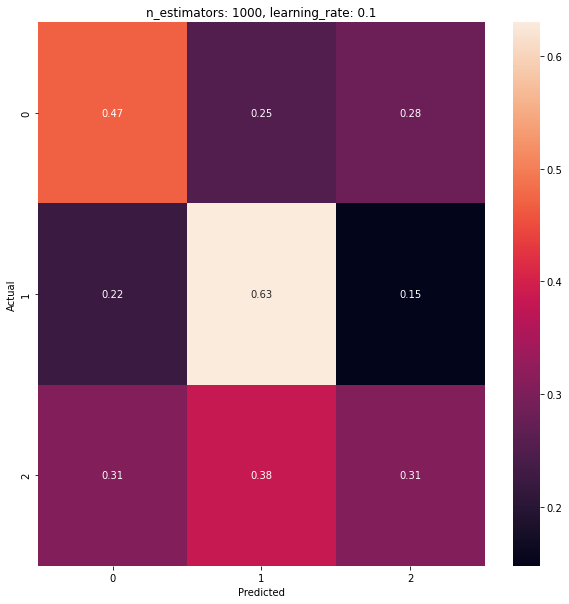

[0]	validation_0-mlogloss:1.09798
[1]	validation_0-mlogloss:1.10043
[2]	validation_0-mlogloss:1.11191
[3]	validation_0-mlogloss:1.11688
[4]	validation_0-mlogloss:1.12780
[5]	validation_0-mlogloss:1.13067
[6]	validation_0-mlogloss:1.13585
[7]	validation_0-mlogloss:1.13626
[8]	validation_0-mlogloss:1.13844
[9]	validation_0-mlogloss:1.14301


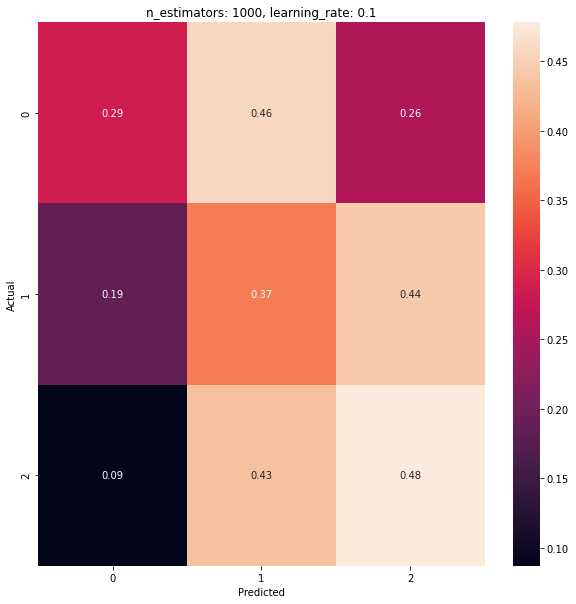

[0]	validation_0-mlogloss:1.09489
[1]	validation_0-mlogloss:1.09319
[2]	validation_0-mlogloss:1.09175
[3]	validation_0-mlogloss:1.09473
[4]	validation_0-mlogloss:1.09655
[5]	validation_0-mlogloss:1.09891
[6]	validation_0-mlogloss:1.09313
[7]	validation_0-mlogloss:1.09663
[8]	validation_0-mlogloss:1.09612
[9]	validation_0-mlogloss:1.09428
[10]	validation_0-mlogloss:1.09100
[11]	validation_0-mlogloss:1.09325
[12]	validation_0-mlogloss:1.09506
[13]	validation_0-mlogloss:1.09566
[14]	validation_0-mlogloss:1.10031
[15]	validation_0-mlogloss:1.09939
[16]	validation_0-mlogloss:1.10318
[17]	validation_0-mlogloss:1.10268
[18]	validation_0-mlogloss:1.10141
[19]	validation_0-mlogloss:1.10802
[20]	validation_0-mlogloss:1.11193


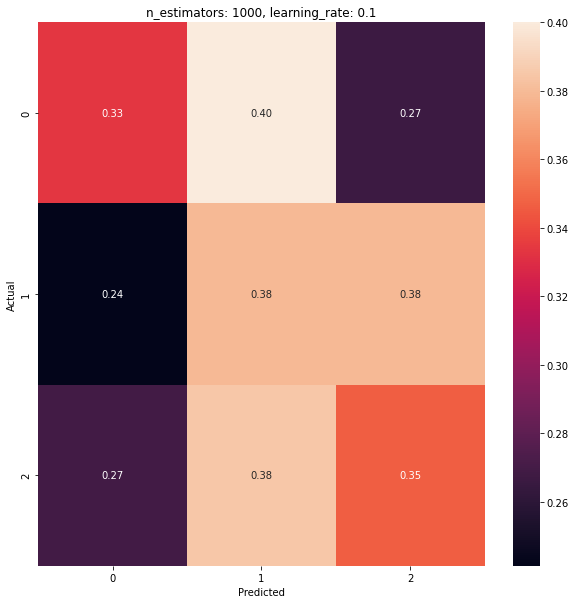

n_estimators: 10, learning_rate: 0.01, score: 0.3826812585499316
n_estimators: 10, learning_rate: 0.025, score: 0.3780027359781122
n_estimators: 10, learning_rate: 0.05, score: 0.3544733242134063
n_estimators: 10, learning_rate: 0.1, score: 0.38035567715458274
n_estimators: 50, learning_rate: 0.01, score: 0.380328317373461
n_estimators: 50, learning_rate: 0.025, score: 0.38035567715458274
n_estimators: 50, learning_rate: 0.05, score: 0.3662380300957593
n_estimators: 50, learning_rate: 0.1, score: 0.38035567715458274
n_estimators: 100, learning_rate: 0.01, score: 0.3826812585499316
n_estimators: 100, learning_rate: 0.025, score: 0.38035567715458274
n_estimators: 100, learning_rate: 0.05, score: 0.3662380300957593
n_estimators: 100, learning_rate: 0.1, score: 0.38035567715458274
n_estimators: 250, learning_rate: 0.01, score: 0.3826812585499316
n_estimators: 250, learning_rate: 0.025, score: 0.38035567715458274
n_estimators: 250, learning_rate: 0.05, score: 0.3662380300957593
n_estimators

In [203]:
# let's just do BTC USDC for now

random_state = 1

btc_df = df.loc[df['instrument']=='BTC_USDC']

# balance the classes first
min_sample = btc_df['label'].value_counts().min()
dfs = []
for label in btc_df['label'].unique():
    dfs.append(btc_df.loc[btc_df['label']==label].sample(min_sample))

btc_df = pd.concat(dfs)
btc_df = shuffle(btc_df, random_state=random_state)

X_cols = [col for col in btc_df.columns if ((col.startswith('o') or col.startswith('h') or col.startswith('l') or col.startswith('c') or col.startswith('v')) and col != 'label')]
y_col = 'label'

X = btc_df[X_cols]
y = btc_df[y_col]

kfolder = KFold(n_splits=5)


n_estimators = [10, 50, 100, 250, 500, 1000]
learning_rates = [0.01, 0.025, 0.05, 0.1]

results = []

for n in n_estimators:
    for lr in learning_rates:

        scores = []

        for train_index, test_index in kfolder.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1, 2], y=y_train)
            sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_test)

            # model = XGBClassifier(n_estimators=1000, learning_rate=0.1, early_stopping_rounds=10, scale_pos_weight=class_weights, random_state=random_state)
            model = XGBClassifier(n_estimators=n, learning_rate=lr, early_stopping_rounds=10, random_state=random_state, verbosity=0)
            
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
            predictions = model.predict(X_test)

            cm = confusion_matrix(y_test, predictions)
            cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title(f'n_estimators: {n}, learning_rate: {lr}')
            plt.show(block=False)

            # score = balanced_accuracy_score(y_test, predictions, sample_weight=sample_weights)
            score = accuracy_score(y_test, predictions)
            scores.append(score)

        results.append(f'n_estimators: {n}, learning_rate: {lr}, score: {np.mean(scores)}')

for result in results:
    print(result)



[0]	train-mlogloss:0.99811	test-mlogloss:1.02918
[1]	train-mlogloss:0.90991	test-mlogloss:0.96659
[2]	train-mlogloss:0.83469	test-mlogloss:0.91508
[3]	train-mlogloss:0.76711	test-mlogloss:0.86523
[4]	train-mlogloss:0.70848	test-mlogloss:0.82147
[0]	train-mlogloss:0.99961	test-mlogloss:1.04427
[1]	train-mlogloss:0.90630	test-mlogloss:0.98915
[2]	train-mlogloss:0.83289	test-mlogloss:0.95129


c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[3]	train-mlogloss:0.76341	test-mlogloss:0.90634
[4]	train-mlogloss:0.70023	test-mlogloss:0.86696
[0]	train-mlogloss:0.99659	test-mlogloss:1.04082
[1]	train-mlogloss:0.90868	test-mlogloss:0.98989
[2]	train-mlogloss:0.83194	test-mlogloss:0.94548
[3]	train-mlogloss:0.76253	test-mlogloss:0.90361
[4]	train-mlogloss:0.70192	test-mlogloss:0.85853
[0]	train-mlogloss:0.99316	test-mlogloss:1.04156
[1]	train-mlogloss:0.90229	test-mlogloss:0.99055
[2]	train-mlogloss:0.82605	test-mlogloss:0.95079
[3]	train-mlogloss:0.75812	test-mlogloss:0.91321
[4]	train-mlogloss:0.69864	test-mlogloss:0.87901
[0]	train-mlogloss:0.99462	test-mlogloss:1.03292
[1]	train-mlogloss:0.90564	test-mlogloss:0.97581
[2]	train-mlogloss:0.82544	test-mlogloss:0.92620
[3]	train-mlogloss:0.75547	test-mlogloss:0.88039
[4]	train-mlogloss:0.69178	test-mlogloss:0.83804
[0]	train-mlogloss:0.99228	test-mlogloss:1.03173
[1]	train-mlogloss:0.90415	test-mlogloss:0.98010
[2]	train-mlogloss:0.83214	test-mlogloss:0.94051
[3]	train-mlogloss:0

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[3]	train-mlogloss:0.77346	test-mlogloss:0.87842
[4]	train-mlogloss:0.71191	test-mlogloss:0.83542
[0]	train-mlogloss:0.99376	test-mlogloss:1.04519
[1]	train-mlogloss:0.90512	test-mlogloss:1.00306
[2]	train-mlogloss:0.82790	test-mlogloss:0.96538
[3]	train-mlogloss:0.75870	test-mlogloss:0.92630
[4]	train-mlogloss:0.69506	test-mlogloss:0.88715
[0]	train-mlogloss:0.99614	test-mlogloss:1.03227
[1]	train-mlogloss:0.90656	test-mlogloss:0.97210
[2]	train-mlogloss:0.83203	test-mlogloss:0.92102
[3]	train-mlogloss:0.76697	test-mlogloss:0.87815
[4]	train-mlogloss:0.69804	test-mlogloss:0.82337
[0]	train-mlogloss:0.99415	test-mlogloss:1.03616
[1]	train-mlogloss:0.90621	test-mlogloss:0.98619
[2]	train-mlogloss:0.82970	test-mlogloss:0.94610
[3]	train-mlogloss:0.76070	test-mlogloss:0.90435
[4]	train-mlogloss:0.69791	test-mlogloss:0.86941
[0]	train-mlogloss:0.99356	test-mlogloss:1.03132
[1]	train-mlogloss:0.90479	test-mlogloss:0.97632
[2]	train-mlogloss:0.82822	test-mlogloss:0.93065
[3]	train-mlogloss:0

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[2]	train-mlogloss:0.83626	test-mlogloss:0.95335
[3]	train-mlogloss:0.76741	test-mlogloss:0.91195
[4]	train-mlogloss:0.70832	test-mlogloss:0.87779
[0]	train-mlogloss:0.99947	test-mlogloss:1.04869
[1]	train-mlogloss:0.90865	test-mlogloss:0.99893
[2]	train-mlogloss:0.82919	test-mlogloss:0.95410
[3]	train-mlogloss:0.76350	test-mlogloss:0.92223
[4]	train-mlogloss:0.69765	test-mlogloss:0.88579
[0]	train-mlogloss:1.01020	test-mlogloss:1.04779
[1]	train-mlogloss:0.91983	test-mlogloss:0.98210
[2]	train-mlogloss:0.83868	test-mlogloss:0.92367
[3]	train-mlogloss:0.77363	test-mlogloss:0.87574
[4]	train-mlogloss:0.71086	test-mlogloss:0.83449
[0]	train-mlogloss:0.99620	test-mlogloss:1.02808
[1]	train-mlogloss:0.90335	test-mlogloss:0.97009
[2]	train-mlogloss:0.82468	test-mlogloss:0.92045
[3]	train-mlogloss:0.75463	test-mlogloss:0.87849
[4]	train-mlogloss:0.69657	test-mlogloss:0.84284
[0]	train-mlogloss:0.99602	test-mlogloss:1.03531
[1]	train-mlogloss:0.91654	test-mlogloss:0.98591
[2]	train-mlogloss:0

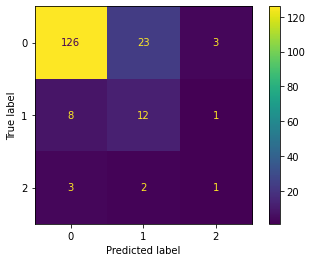

[0]	final-mlogloss:0.98388
[1]	final-mlogloss:0.88432
[2]	final-mlogloss:0.79825
[3]	final-mlogloss:0.72400
[4]	final-mlogloss:0.65432


c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


In [88]:
# balance classes

df2 = df.copy()

scaler = MinMaxScaler()

X_cols = [col for col in df2.columns if col != 'label']
y_col = 'label'

X = df2[X_cols]
y = df2[y_col]

X = scaler.fit_transform(X)

param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = 6
param['num_class'] = 3

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=0
# )

rskf = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=0)

error_rates = []

for train_index, test_index in rskf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    xg_train = xgb.DMatrix(X_train, label=y_train, weight=weights)
    xg_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 5
    bst = xgb.train(param, xg_train, num_round, watchlist)
    # get prediction
    pred = bst.predict(xg_test)
    error_rate = np.sum(pred != y_test) / y_test.shape[0]
    error_rates.append(error_rate)
    # print('Test error using softmax = {}'.format(error_rate))

print('Overall mean error rate:', np.mean(error_rates))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred))
cm.plot()
plt.show()

# will use train test split for convenience
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=np.round(1/6, 2), random_state=0
)



weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_test
)

xg = xgb.DMatrix(X_test, label=y_test, weight=weights)
watchlist = [(xg, 'final')]
num_round=5
bst = xgb.train(param, xg, num_round, watchlist)

In [89]:
windows = max(rsi_windows + sma_windows)

testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=windows+future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')
results_df = testing_df.copy()[-future_window:]
print(results_df['l'].min(), results_df['h'].max())
testing_df = testing_df[:-future_window]



testing_df = testing_df.set_index('dt')
testing_df = testing_df.drop('t', axis=1)

for w in rsi_windows:
    testing_df[f'rsi{w}'] = rsi(testing_df['c'], window=w)

for w in sma_windows:
    testing_df[f'sma{w}'] = sma_indicator(testing_df['c'], window=w)



X_cols = [col for col in testing_df.columns if col != 'label']
# # let's bring in the past values

dfs = [testing_df]

for i in range(1, past_window+1):

    dataframe = testing_df.copy().shift(i)
    new_cols = [f'{col}_{i}' for col in dataframe.columns]
    dataframe.columns = new_cols
    dfs.append(dataframe)
    # for col in X_cols:
    #     testing_df[f'{col}_{i}'] = testing_df[col].shift(i)

testing_df = pd.concat(dfs, axis=1)

testing_df

# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
testing_df = testing_df.dropna()

X = testing_df

X = scaler.transform(X)

X = xgb.DMatrix(X)

bst.predict(X)

19649.37 19900.99


array([0.], dtype=float32)

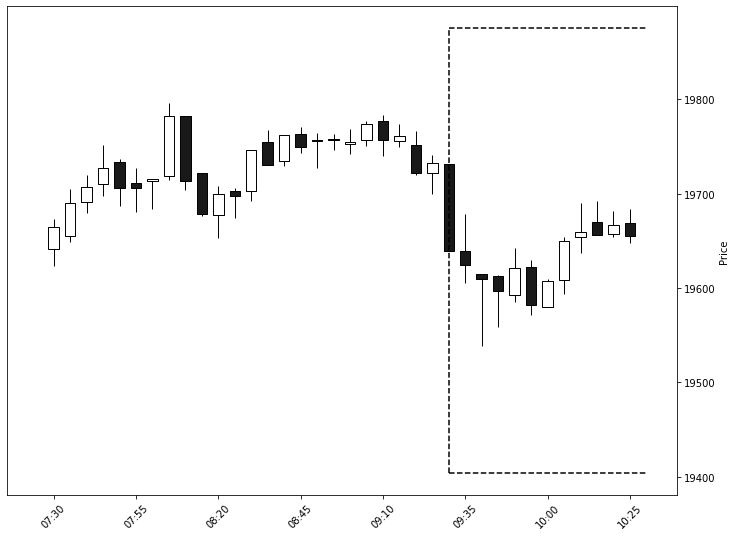

In [77]:
testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')

testing_df = testing_df.drop('t', axis=1).set_index('dt').rename({'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12,9))

mpl.plot(
    testing_df,
    type='candle',
    style='classic',
    ax=ax
)

plt.sca(ax)

vline_y_min = min(testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), testing_df['Low'].min())
vline_y_max = max(testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), testing_df['High'].max())

plt.vlines(x=past_window, ymin=vline_y_min, ymax=vline_y_max, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')

plt.show()